In [1]:
import os, sys
import numpy as np

from pathlib import Path

from astropy.io import fits, ascii
from astropy.table import Table, Column, vstack, hstack, join
from astropy.cosmology import FlatLambdaCDM

from scipy import interpolate
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D

%matplotlib inline

sys.path.append("./py")
from utils import *

sys.path.append("/Users/aberti/Desktop/research")
from plotutils import get_corners, fig_labels, get_colors, plot_settings
plt.rcParams.update(**plot_settings)

plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.family"] = "STIXGeneral"

from params import BASEDIR, DATADIR, SIMDIR, H0, Om0
h = H0/100.
from params import get_boxsize, get_zsnap_data, get_sham_var_bins, get_abs_mag_lim, get_abs_mag_bins_clust
z_snaps, snap_nums, snaps = get_zsnap_data("mdpl2")

cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)

import Corrfunc
from Corrfunc.theory.wp import wp as wp_corrfunc

#-- bins for clustering (data and mocks)
from params import bin_file_comoving#, bin_file
from params import bin_file_test as bin_file_zhou

def get_cs(band,zmin):
    if band=="Mz":
        return 0.6
    elif band=="MW1":
        if zmin==0.6:
            return 0.6
        elif (zmin==0.4) | (zmin==0.5):
            return 0.8
        else:
            raise Exception
    else:
        raise Exception
        

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/__init__.py:550: UserWarning: matplotlibrc text.usetex can not be used unless ghostscript-9.00 or later is installed on your system
  % gs_req)


# Set parameters

In [2]:
band   = "MW1"
zrange = (0.5,0.6)

print(band)
print(zrange)

zmag_lim = 20.7
sim_tag  = "mdpl2"
sham_tag = "vpeak"
d        = "south"
pimax    = 150

#========== BEGIN HOUSEKEEPING ==========#
hist_idx = [len(snaps)-i for i in snap_nums]
vol_sim  = get_boxsize(sim_tag)**3
a_snaps = [snaps["scale"][snaps["snapnum"]==sn].data[0] for sn in snap_nums]

sham_var_bins, sham_var_cens = get_sham_var_bins(sham_tag)

zmin, zmax  = zrange
cat_tag     = get_cat_tag(d,zrange)
abs_mag_lim = get_abs_mag_lim(zmin, band)
zsim        = np.array(z_snaps)[ np.round(z_snaps,1)==zmin ][0]
zsnap_tag   = get_zsnap_tag(zsim)
zmag_tag    = get_zmag_tag(zmag_lim)

MW1lim = get_abs_mag_lim(zmin,"MW1")
Mrlim  = get_abs_mag_lim(zmin,"Mr")
Mzlim  = get_abs_mag_lim(zmin,"Mz")
if band=="MW1":
    abs_mag_lim_tag = get_MW1_tag(MW1lim)
    abs_mag_range   = np.array((-24.5,-21.99))
    model_mag_range = np.array((-22.25,-25.35))
elif band=="Mr":
    abs_mag_lim_tag = get_Mr_tag(Mrlim)
    abs_mag_range   = np.array((-23,-20.49))
    model_mag_range = np.array((-20.8,-23.85))
elif band=="Mz":
    abs_mag_lim_tag = get_Mz_tag(Mzlim)
    abs_mag_range   = np.array((-23.75,-21.24))
    model_mag_range = np.array((-21.6,-24.6))
else:
    raise Exception()

abs_mag_ticks = np.arange(*abs_mag_range,0.5)

n_mag_bins_clust   = 4
abs_mag_bins_clust = get_abs_mag_bins_clust(zmin, band, nbins=n_mag_bins_clust)
abs_mag_bin_tags   = get_abs_mag_bin_tags(zmin, band)

lf_name = f"{BASEDIR}/data/stats/lum_func_{band}_{cat_tag}_{zmag_tag}_{abs_mag_lim_tag}.npy"
color_cdf_name = f"{BASEDIR}/data/stats/cdf_r-{band[1:]}_{cat_tag}_{zmag_tag}_{abs_mag_lim_tag}.npy"

color_cdf = Table(np.load(color_cdf_name))

lum_func_full = np.load(f"{BASEDIR}/data/stats/lum_func_{band}_{cat_tag}_{zmag_tag}_full.npy").item()
"""
V_zphot [N_gal]: volume corresponding to zphot for each galaxy in sample (N_gal total galaxies in sample)
V_eff   [N_gal]: effective volume for each galaxy in sample
abs_mag_bins [len(abs_mag_bins)]: absolute magnitude bins corresponding to ng_eff and gal_counts
ng_eff       [len(abs_mag_bins)]: (cumulative) effective galaxy number density as function of maximum absolute r- or W1-band magnitude 
gal_counts   [len(abs_mag_bins)]: (cumulative) galaxy number counts as function of maximum aboslute r- or W1-band magnitude
"""    
    
params = dict(abs_mag_bins_clust=abs_mag_bins_clust,
              abs_mag_bin_tags=abs_mag_bin_tags,
              abs_mag_lim=abs_mag_lim,
              abs_mag_lim_tag=abs_mag_lim_tag,
              abs_mag_range=abs_mag_range,
              abs_mag_ticks=abs_mag_ticks,
              a_snaps=a_snaps,
              band=band,
              # bin_file=bin_file,
              cat_tag=cat_tag,
              color_cdf=color_cdf,
              d=d, # north, south
              h=h,
              hist_idx=hist_idx,
              # lum_func=lum_func,
              lum_func_full=lum_func_full,
              model_mag_range=model_mag_range,
              Mrlim=Mrlim,
              Mzlim=Mzlim,
              MW1lim=MW1lim,
              # nbins=nbins,
              n_mag_bins_clust=n_mag_bins_clust,
              pimax=pimax,
              # rp_bins=rp_bins,
              # rp_max=rp_max,
              # rp_mids=rp_mids,
              # rp_min=rp_min,
              sham_tag=sham_tag,
              sham_var_bins=sham_var_bins,
              sham_var_cens=np.round(sham_var_cens,3),
              sim_tag=sim_tag,
              snap_nums=snap_nums,
              snaps=snaps,
              vol_sim=vol_sim,
              zmag_tag=zmag_tag,
              zmag_lim=zmag_lim,
              zmax=zmax,
              zmin=zmin,
              zrange=zrange,
              zsim=zsim,
              zsnap_tag=zsnap_tag,
              z_snaps=z_snaps,
             )

def param_list(values=False):
    for k in params.keys():
        ktype = str(type(params[k]))[8:-2]
        if values:
            if ktype in ("str","float","int","numpy.float64","numpy.ndarray","list","tuple","bool"):
                print(f"{k} ({ktype})\n{params[k]}\n")
            elif ktype=="dict":
                print(f"{k} ({ktype})\n{list(params[k].keys())}\n")
            elif "table" in ktype:
                print(f"{k} (table)\n{params[k].colnames}\n")
            else:
                print(f"{k} ({ktype})\n")
        else:
            print(f"{k}")
#=========== END HOUSEKEEPING ===========#


# print("snap\tz\tscale\n")
# for i,sn,z,a in zip(range(len(snap_nums)), snap_nums, z_snaps, a_snaps):
#     print("{}\t{:.5f}\t{:.5f}".format(sn,z,a))
#     if (i-1)%2==0:
#         print("")

# param_list(values=True)


MW1
(0.5, 0.6)


<a class="anchor" id="outline"></a>

* [Load mock catalog](#load_mock)
* [Mock LRG satellite radial distribtions](#sat_dist)
* [Vpeak vs model magnitude](#vpeak_vs_mag)
* [Mock color-magnitude diagrams](#mock_cmd)
* [LRG fraction in color-mag space](#lrg_frac_cmd)
* [Starvation redshift](#zstarve)
  * [Histograms by type](#zstarve_by_type)
  * [$z_{\rm starve}$ vs halo mass accretion history](#accretion_hist)
* [Color / age distributions](#color)
  * [Mock histogram](#color_mock_hist)
  * [Mock color CDFs](#color_mock_cdf)
* [Mock LRG HODs](#hod)
  * [HOD models by row](#hod_models_by_row)
  * [HOD LRG selections by row](#hod_selections_by_row)
  * [Comparison to Hernandez-Aguayo+ 2021 DESI-like LRGs](#hod_compare_h-a)
  * [Comparison to Zhou+ 2021 DESI-like LRG HODs](#hod_compare_zhou)
  * [Combined comparison](#hod_compare_all)
  * [Analytic HOD parameter fits for my models](#hod_fit_my_model)
* [Clustering](#clust)
  * [Mock LRGs](#clust_mock_lrg)
* [Centrals in massive halos but not LRGs](#not_lrg)
  * [Load DR9 catalog](#dr9)
* [Data LRG color-color mag-mag comparison](#color-color_mag-mag)
* [Dim red not LRG test](#dim_not-lrg)
* [Absolute magnitude vs zphot](#mag_fig)

In [ ]:
t = Table(np.load("mags_z0p40-0p70.npy"))

# n_mag_bins_clust   = 4
# abs_mag_bins_clust = get_abs_mag_bins_clust(zmin, band, nbins=n_mag_bins_clust)
# abs_mag_bin_tags   = get_abs_mag_bin_tags(zmin, band)

# pz_mask = ((t["pz"]) >= zmin) & (t["pz"] < zmax)

# abs_mag_bin_cens  = [np.mean(abs_mag_bins_clust[i:i+2]) for i in range(len(abs_mag_bins_clust)-1)]
# abs_mag_bin_means = [np.round(np.mean(t[band][pz_mask & (t[band] < abs_mag_bins_clust[i+1]) & (t[band] >= abs_mag_bins_clust[i])]),3) for i in range(len(abs_mag_bins_clust)-1)]
# abs_mag_bin_meds  = [np.round(np.median(t[band][pz_mask & (t[band] < abs_mag_bins_clust[i+1]) & (t[band] >= abs_mag_bins_clust[i])]),3) for i in range(len(abs_mag_bins_clust)-1)]

# print(abs_mag_bin_cens)
# print(abs_mag_bin_means)
# print(abs_mag_bin_meds)


In [ ]:
# DS = 1000
# r, z, W1, pz = t["r"], t["z"], t["W1"], t["pz"]

# fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8,8))

# ax = axes[0]
# ax.scatter(pz[::DS], (r-z)[::DS], s=1)
# ax.set_ylim(0,2)

# ax = axes[1]
# ax.scatter(pz[::DS], (r-W1)[::DS], s=1)
# ax.set_ylim(0,4)

# plt.tight_layout()

# plt.show()


In [ ]:
%%time

c_opt, c_IR = get_colors(2)

fig, axes = plt.subplots(3, 2, figsize=(8,12))

bins = np.arange(-25.5,-19.5,0.02)

lrg_ir_mask  = t["LRG_IR"]==True
lrg_opt_mask = t["LRG_opt"]==True

for row,zmin,xlabel in zip(range(3),(0.4,0.5,0.6),(r"$^{0.43}$",r"$^{0.52}$",r"$^{0.63}$")):
    zphot_label = f"${zmin}$" + r"$\ <z_{\rm phot}<\ $" + f"${zmin + 0.1}$"

    for col,band in zip(range(2),("Mz","MW1")):
        ax = axes[row][col]
        ax.tick_params(axis="both", which="both", labelsize=16)

        lim = get_abs_mag_lim(zmin, band)
        bins_clust = get_abs_mag_bins_clust(zmin, band)[-4:-1]
        pz_mask = (t["pz"] >= zmin) & (t["pz"] < (zmin + 0.1))

        ymax = 1.05*np.max(np.histogram(t[band][pz_mask & (t[band] < lim)], bins=bins)[0])
        ax.set_ylim(0,ymax)

        if band=="Mz":
            ax.set_xlabel(xlabel + r"$M_{\rm z}$", fontsize=18)
            ax.set_xlim(-21,-24.5)
            yticks = np.arange(0,3e5,5e4)
            ax.set_yticks(yticks[yticks < ymax])
            #ax.set_xticks(np.arange(-21,-25,-1))
        else:
            ax.set_xlabel(xlabel + r"$M_{\rm W1}$", fontsize=18)
            ax.set_xlim(-22,-25.5)
            yticks = np.arange(0,3e5,2e4)
            if row==0:
                ax.set_yticks(yticks[yticks < ymax][1::2])
            else:
                ax.set_yticks(yticks[yticks < ymax])
            #ax.set_xticks(np.arange(-22,-26,-1))

        p = t[band][pz_mask]
        ax.hist(p, bins=bins[bins <= lim], color="gray", alpha=0.4, label="parent sample")
        ax.hist(p, bins=bins[bins >= lim], color="gray", alpha=0.15, label="")

        lrg_opt = t[band][pz_mask & lrg_opt_mask]
        lrg_ir  = t[band][pz_mask & lrg_ir_mask]
        ax.hist(lrg_ir, bins=bins, color=c_IR, label="IR LRG")
        ax.hist(lrg_opt, bins=bins, color=c_opt, histtype="step", hatch="////", lw=1, label="optical LRG")

        print(zmin, band)
#         print(f"opt\t{100*len(lrg_opt[lrg_opt <= lim])/len(lrg_opt):.2f}")
#         print(f"IR\t{100*len(lrg_ir[lrg_ir <= lim])/len(lrg_ir):.2f}")
#         print(len(p[p <= lim]))

        ax.plot(lim*np.ones(2), ax.get_ylim(), ls="--", lw=1, color="black")
        for b in bins_clust:
            ax.plot(b*np.ones(2), ax.get_ylim(), ls=":", lw=1, color="black")
        ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
        y0, y1 = ax.get_ylim()
        # ax.text(bins_clust[0]+0.1, 0.5*(y0 + y1), r"$\rightarrow$", ha="left", va="center", fontsize=30)

        if col==0:
            ax.text(*get_corners(ax)["upper_right"], zphot_label, ha="right", va="top", fontsize=16)
            ax.set_ylabel(r"$N_{\rm gal}$ / mag", fontsize=20)

axes[0][1].legend(loc=1, markerfirst=False, fontsize=16, handletextpad=0.25, labelspacing=0.3, borderpad=0.025)

plt.subplots_adjust(wspace=0.15,hspace=0.25)

fname = f"{BASEDIR}/figures/abs_mag_cuts.png"
print(fname)

plt.savefig(fname, bbox_inches="tight", pad_inches=0.1, dpi=300)

plt.show()


In [ ]:
# %%time

# colors = get_colors(2)

# fig, axes = plt.subplots(2, 3, figsize=(12,8))

# bins = np.arange(-25.5,-19.5,0.01)

# lrg_ir_mask  = t["LRG_IR"]==True
# lrg_opt_mask = t["LRG_opt"]==True

# for col,zmin,xlabel in zip(range(3),(0.4,0.5,0.6),(r"$^{0.43}$",r"$^{0.52}$",r"$^{0.63}$")):
#     zphot_label = f"${zmin}$" + r"$\ <z_{\rm phot}<\ $" + f"${zmin+0.1}$"

#     for row,band in zip(range(2),("Mz","MW1")):
#         ax = axes[row][col]
#         ax.tick_params(axis="both", which="both", labelsize=18)

#         lim = get_abs_mag_lim(zmin, band)

#         pz_mask = ((t["pz"]) >= zmin) & (t["pz"] < zmin+0.1)

#         # if row==0 and col==2:
#         p = t[band][pz_mask]
#         ax.hist(p, bins=bins[bins <= lim], color="gray", alpha=0.4, label="parent sample")
#         ax.hist(p, bins=bins[bins >= lim], color="gray", alpha=0.15, label="")

#         lrg_opt = t[band][pz_mask & lrg_opt_mask]
#         lrg_ir  = t[band][pz_mask & lrg_ir_mask]
#         ax.hist(lrg_ir, bins=bins, color=colors[1], label="LRGs (IR selection)")
#         ax.hist(lrg_opt, bins=bins, color=colors[0], histtype="step", hatch="\\\\\\\\", lw=1, label="LRGs (optical selection)")

#         print(zmin, band)
#         print(f"opt\t{100*len(lrg_opt[lrg_opt <= lim])/len(lrg_opt):.2f}")
#         print(f"IR\t{100*len(lrg_ir[lrg_ir <= lim])/len(lrg_ir):.2f}")
#         print(len(p[p <= lim]))

#         if col==2:
#             ax.set_ylim(0,1.7*np.max(np.histogram(t[band][pz_mask], bins=bins)[0]))
#             if row==0:
#                 ax.legend(loc=1, frameon=True, markerfirst=False, fontsize=17, handletextpad=0.25, labelspacing=0.3)
#         else:
#             ax.set_ylim(0,1.02*np.max(np.histogram(t[band][pz_mask], bins=bins)[0]))
        
#         ax.plot(lim*np.ones(2), ax.get_ylim(), ls="--", lw=2, color="black")

#         ax.set_xlim(-20.5,-24.5) if (band=="Mz") else ax.set_xlim(-20.5,-25.5)
#         if band=="Mz":
#             ax.set_xlabel(xlabel + r"$M_{\rm z}$", fontsize=20)
#         else:
#             ax.set_xlabel(xlabel + r"$M_{\rm W1}$", fontsize=20)
#         ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
        
#         if row==0:
#             ax.set_title(zphot_label, fontsize=20)
#             #ax.text(*get_corners(ax)["upper_right"], zphot_label, ha="right", va="top", fontsize=20)

# axes[0][1].set_yticks(np.arange(0,100001,20000))

# plt.tight_layout()
# plt.subplots_adjust(wspace=0.15,hspace=0.25)

# fname = f"{BASEDIR}/figures/abs_mag_cuts.png"
# print(fname)

# plt.savefig(fname, bbox_inches="tight", pad_inches=0.1, dpi=300)

# plt.show()


In [ ]:
# zmin = 0.6
# band = "MW1"

# abs_mag_bins_clust = get_abs_mag_bins_clust(zmin, band, nbins=4)
# counts, bins = np.histogram(t[(t["pz"]>zmin) & (t["pz"]<=zmin+0.1)][band], bins=abs_mag_bins_clust)

# print(bins, counts)


In [ ]:
# print(zmin,band)
# for i in range(len(bins)-1):
#     bmin, bmax = bins[::-1][i:i+2]
#     N = counts[::-1][i]
#     if i < 3:
#         print(f"$({bmin:.2f},{bmax:.2f})$ & {N} &")
#     else:
#         print(f"$<{bmin:.2f}$ & {N} &")


<a class="anchor" id="load_mock"></a>
# Load mock

[BACK TO TOP](#outline)

[JUMP TO LOAD HALO CATALOG](#hod)

In [3]:
%%time

# f = f"{BASEDIR}/mocks/{sim_tag}/{sham_tag}/{d}/{zsnap_tag}_{abs_mag_lim_tag}"
f = f"{BASEDIR}/mocks/{sim_tag}/{sham_tag}/{d}/color_scatter/{zsnap_tag}_{abs_mag_lim_tag}"

# galcat_fname = f"{f}_galcat-hist-LRG.npy"
galcat_fname = f"{f}_galcat-LRG.npy"

print(galcat_fname)

cat = Table(np.load(galcat_fname))
    

/Users/aberti/Desktop/research/desi_lrg_sham/mocks/mdpl2/vpeak/south/color_scatter/zsnap0p52323_MW1limn22p85_galcat-LRG.npy
CPU times: user 863 ms, sys: 622 ms, total: 1.48 s
Wall time: 1.5 s


<a class="anchor" id="sat_dist"></a>
# Mock LRG satellite radial distributions

[BACK TO TOP](#outline)


In [4]:
is_cen = cat["upid"]==-1
is_sat = ~is_cen

is_LRG_opt = cat["LRG_opt_csrand"]
is_LRG_IR  = cat["LRG_IR_csrand"]

sat_LRG_opt = cat[is_sat & is_LRG_opt]
sat_LRG_IR  = cat[is_sat & is_LRG_IR]


In [5]:
print(len(cat[is_LRG_opt]))

print(len(cat[is_LRG_opt & (cat["pid"]==-1)]))

print(len(cat[is_LRG_opt & (cat["upid"]==-1)]))

print(len(cat[is_LRG_opt & (cat["pid"]==-1) & (cat["upid"]==-1)]))


542006
462444
462444
462444


In [47]:
%%time

# upid_coords_opt = {}
# upid_coords_IR  = {}
upid_coords = {}

# cen_LRG_opt = cat[is_LRG_opt & is_cen]
# cen_LRG_IR  = cat[is_LRG_IR & is_cen]
cen_all = cat[is_cen]

upid_coords = dict(zip(np.array(cen_all["halo_id"]),
                   np.array([cen_all["x"],cen_all["y"],cen_all["z"],cen_all["rvir"]]).T))

# upid_coords_opt = dict(zip(np.array(cen_LRG_opt["halo_id"]),
#                   np.array([cen_LRG_opt["x"],cen_LRG_opt["y"],cen_LRG_opt["z"],cen_LRG_opt["rvir"]]).T))

# np.save(f"cen_coords_z{str(zmin).replace('.','p')}_{band}_opt.npy", upid_coords_opt)
# print("opt saved")

# upid_coords_IR = dict(zip(np.array(cen_LRG_IR["halo_id"]),
#                  np.array([cen_LRG_IR["x"],cen_LRG_IR["y"],cen_LRG_IR["z"],cen_LRG_IR["rvir"]]).T))

# np.save(f"cen_coords_z{str(zmin).replace('.','p')}_{band}_IR.npy", upid_coords_IR)
# print("IR saved")


CPU times: user 1.81 s, sys: 1.82 s, total: 3.63 s
Wall time: 5.82 s


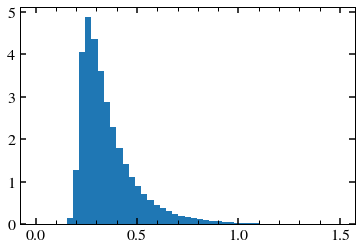

In [50]:
plt.hist(cen_all["rvir"]/1000, bins=np.linspace(0,1.5), density=True)
# plt.hist(cen_LRG_opt["rvir"]/1000, bins=np.linspace(0,1.5), density=True, alpha=0.5)
# plt.hist(cen_LRG_IR["rvir"]/1000, bins=np.linspace(0,1.5), alpha=0.5, density=True)

plt.show()


In [51]:
%%time

table_opt = Table(data=[sat_LRG_opt["halo_id"],sat_LRG_opt["upid"],
                        np.array([sat_LRG_opt["x"],sat_LRG_opt["y"],sat_LRG_opt["z"]]).T,
                        np.zeros([len(sat_LRG_opt),3]),np.zeros(len(sat_LRG_opt))],
                  names=("sat_halo_id","upid","sat_coords","cen_coords","cen_rvir"))

table_IR = Table(data=[sat_LRG_IR["halo_id"],sat_LRG_IR["upid"],
                       np.array([sat_LRG_IR["x"],sat_LRG_IR["y"],sat_LRG_IR["z"]]).T,
                       np.zeros([len(sat_LRG_IR),3]),np.zeros(len(sat_LRG_IR))],
                 names=("sat_halo_id","upid","sat_coords","cen_coords","cen_rvir"))


CPU times: user 9.13 ms, sys: 15.4 ms, total: 24.6 ms
Wall time: 21.9 ms


In [52]:
%%time

for i in range(len(table_opt)):
    this_upid = table_opt["upid"][i]
    if this_upid in upid_coords.keys():
        table_opt["cen_coords"][i] = upid_coords[this_upid][:3]
        table_opt["cen_rvir"][i]   = upid_coords[this_upid][-1]

for i in range(len(table_IR)):
    this_upid = table_IR["upid"][i]
    if this_upid in upid_coords.keys():
        table_IR["cen_coords"][i] = upid_coords[this_upid][:3]
        table_IR["cen_rvir"][i]   = upid_coords[this_upid][-1]


CPU times: user 2.27 s, sys: 31.4 ms, total: 2.3 s
Wall time: 2.35 s


In [53]:
table_opt_masked = table_opt[[np.sum(table_opt[i]["cen_coords"].data)>0 for i in range(len(table_opt))]]
table_IR_masked  = table_IR[[np.sum(table_IR[i]["cen_coords"].data)>0 for i in range(len(table_IR))]]


In [54]:
len(table_opt_masked)/len(table_opt)


0.9264221613332998

In [55]:
len(table_IR_masked)/len(table_IR)


0.9346649269890622

In [56]:
radii_opt = np.sqrt(np.sum( (np.array(table_opt_masked["cen_coords"]) - np.array(table_opt_masked["sat_coords"]))**2, axis=1 ))
radii_IR  = np.sqrt(np.sum( (np.array(table_IR_masked["cen_coords"]) - np.array(table_IR_masked["sat_coords"]))**2, axis=1 ))


In [57]:
radii_opt_scaled = radii_opt / (table_opt_masked["cen_rvir"]/1000)
radii_IR_scaled = radii_IR / (table_IR_masked["cen_rvir"]/1000)


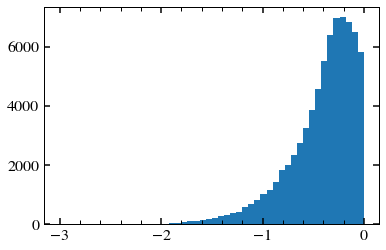

In [58]:
plt.hist(np.log10(radii_opt_scaled[radii_opt_scaled < 2]), bins=50)

plt.show()


In [59]:
H_opt, bins = np.histogram((radii_opt_scaled[radii_opt_scaled < 2]), bins=30, density=True)
H_IR,_      = np.histogram((radii_IR_scaled[radii_IR_scaled < 2]), bins=bins, density=True)


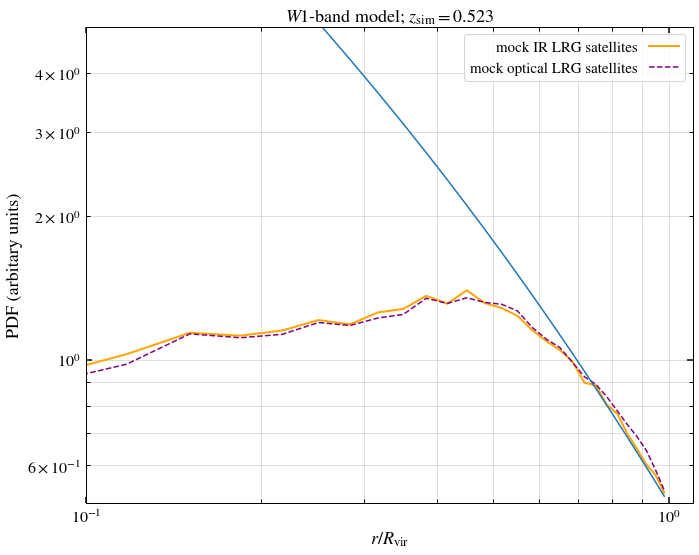

In [60]:
# bins = np.logspace(np.log10(0.1),np.log10(2.0),30)

# H_opt,_ = np.histogram(radii_opt[radii_opt < 2], bins=bins, density=True)
# H_IR,_  = np.histogram(radii_IR[radii_IR < 2], bins=bins, density=True)

fig, ax = plt.subplots(1, 1, figsize=(10,8))

ax.loglog((bins[1:]+bins[:-1])/2, H_IR, color="orange", lw=2, label="mock IR LRG satellites")
ax.loglog((bins[1:]+bins[:-1])/2, H_opt, color="purple", lw=1.5, ls="--", label="mock optical LRG satellites")

ax.legend(markerfirst=False, frameon=True)
ax.set_xlabel(r"$r / R_{\rm vir}$")
ax.set_ylabel("PDF (arbitary units)")

ax.set_xlim(0.1,1.1)
ax.set_ylim(0.5,5)

ax.grid(which="both", alpha=0.5)
ax.set_title(f"${band[1:]}$-band model; " + r"$z_{\rm sim}$" + f"$={zsim:.3f}$")

plt.tight_layout()

figname = f"{BASEDIR}/figures/sat-dist_{band}_{zsnap_tag}.png"
# print(figname)
# plt.savefig(figname, bbox_inches="tight", pad_inches=0.1, dpi=200)

p0 = 2

r_scaled = (bins[1:]+bins[:-1])/2
p = p0/(r_scaled*(1 + r_scaled)**2)

ax.loglog(r_scaled,p)

plt.show()


<a class="anchor" id="vpeak_vs_mag"></a>
# Vpeak vs model magnitude

[BACK TO TOP](#outline)

In [ ]:
%%time

plt.rcParams["savefig.dpi"] = 200
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.colors as colors

assert(band in cat.colnames)

fig, ax = plt.subplots(1, 1, figsize=(7,6.5))

ax.set_xlim(2.1,3.1)
ax.set_xticks(np.arange(2.1,3.11,0.2))
ylim = (-21.65,-24.5) if band=="Mz" else (-22.3,-25)
ax.set_ylim(ylim)

cmap = plt.get_cmap("binary")

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

new_cmap = truncate_colormap(cmap, 0.0, 0.8)

DS = 1

bins = np.logspace(1.1,6,30)

X, Y = np.log10(cat[sham_tag])[::DS], cat[band][::DS]
ax.hexbin(X, Y, gridsize=100, xscale="linear", yscale="linear", cmap=new_cmap, extent=(*ax.get_xlim(), *ax.get_ylim()[::-1]), bins=bins)

line_kwargs = dict(color="magenta", lw=2.5, ls="--")
X.sort()
v = cat[f"{band}_no_scatter"][::DS].data.copy()
v.sort()
ax.plot(X, v[::-1], **line_kwargs)

ax.legend( [Line2D([0], [0], **line_kwargs)], ["without scatter"], handletextpad=0.4, handlelength=2, fontsize=24, loc=2)#, framealpha=0.9)
#ax.text(*get_corners(ax, margin=0.05)["lower_right"], r"$z_{\rm sim}=\ $" + f"${zsim:.3f}$", ha="right", va="bottom", fontsize=26)#, bbox=dict(boxstyle="round", facecolor="white", alpha=0.9))
ymin, ymax = ylim
yt = ymin + 0.85*(ymax-ymin)
ax.text(2.15, yt, r"$z_{\rm sim}=\ $" + f"${zsim:.3f}$", ha="left", va="top", fontsize=26)#, bbox=dict(boxstyle="round", facecolor="white", alpha=0.9))

ax.set_xlabel(r"$\log_{10}[v_{\rm peak}\ ({\rm km}^{-1}\ {\rm s})]$", fontsize=28)
ylabel = r"${\rm model}\ ^{0.43}M_z$" if band=="Mz" else r"${\rm model}\ ^{0.43}M_{W1}$"
ax.set_ylabel(ylabel, fontsize=28)
ax.tick_params(axis="both", which="both", labelsize=24)

ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))

plt.tight_layout()

fname = f"{BASEDIR}/figures/vpeak_{cat_tag[:-6]}_{abs_mag_lim_tag}.png"
print(fname)

plt.savefig(fname, bbox_inches="tight", pad_inches=0.1, dpi=200)

plt.show()


<a class="anchor" id="mock_cmd"></a>
# Mock color-magnitude diagrams

[BACK TO TOP](#outline)

In [ ]:
from matplotlib.colors import LogNorm
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

def _plot_model_cmd(band, selection="", save=False, LRG=True):
    if ("opt" in selection):
        selection = "opt"
        
    fig, ax = plt.subplots(1, 1, figsize=(6,6))

    ax.tick_params(axis="both", which="both", labelsize=20, direction="in", color="white")
    if band=="Mz":
        ax.set_xlim(-21.5,-25.25)
        ax.set_ylim(0.25,1.6)
        band_label = r"$M_z$"
    elif band=="MW1":
        ax.set_xlim(-22.15,-25.25)
        ax.set_ylim(0.4,3.6)
        band_label = r"$M_{W1}$"
    else:
        raise Exception()

    xticks = np.arange(-26,-19,0.5)
    xticks = xticks[(xticks >= ax.get_xlim()[-1]) & (xticks <= ax.get_xlim()[0])]
    ax.set_xticks( xticks )
    ax.set_xticklabels( [f"${i}$" for i in xticks], rotation=45 )

    if band=="MW1":
        yticks = np.arange(0.5,3.51,0.5)
        # yticks = yticks[(yticks >= ax.get_ylim()[0]) & (yticks <= ax.get_ylim()[-1])]
        ax.set_yticks( yticks )
        # ax.set_yticklabels( [f"${i}$" for i in yticks] )

    xx, yy = cat[band], cat[f"r-{band[1:]}"]

    hexbins   = np.logspace(1.8,4,50)
    hexkwargs = dict(bins=hexbins, xscale="linear", yscale="linear", gridsize=50, cmap="plasma")
    ax.hexbin(xx, yy, extent=(*ax.get_xlim(), *ax.get_ylim()), **hexkwargs)

    if selection != "":
        lrg_mask = cat[f"LRG_{selection}"]==True
        txt = r"${\rm IR\ LRG\ selection}$" if (selection=="IR") else r"${\rm optical\ LRG\ selection}$"

        ww, zz = xx[lrg_mask], yy[lrg_mask]
        rr = (ax.get_xlim()[::-1], ax.get_ylim())
        H, X, Y = np.histogram2d(ww, zz, bins=30, range=rr, density=True)
        x_cen = [np.mean([X[i],X[i+1]]) for i in range(len(X)-1)]
        y_cen = [np.mean([Y[i],Y[i+1]]) for i in range(len(Y)-1)]

        lrg_levels = np.quantile(H[H > 0], np.arange(0.5,1.01,0.1))
        ax.contour(x_cen, y_cen, H.T, colors="white", levels=lrg_levels, linewidths=1.5, density=True)
        ax.contourf(x_cen, y_cen, H.T, colors="white", alpha=0.4, levels=lrg_levels, density=True)

    ax.set_xlabel(r"${\rm model}\ $" + band_label, fontsize=24)
    ax.set_ylabel(r"${\rm model}$ " + f"$r-{band[1:]}$" + r" $({\rm K}$-${\rm corrected})$", fontsize=24)

    if ("W" in band) or (("z" in band) & (zmin==0.4)):
        ax.text(*get_corners(ax, margin=0.05)["upper_left"], r"$z_{\rm sim}=\ $" + f"${zsim:.3f}$", ha="left", va="top", fontsize=24, bbox=dict(boxstyle="round", facecolor="white", alpha=0.9))
        if selection != "":
            ax.text(*get_corners(ax, margin=0.05)["lower_right"], txt, ha="right", va="bottom", fontsize=24, bbox=dict(boxstyle="round", facecolor="white", alpha=0.9))
    else:
        if selection=="":
            ax.text(*get_corners(ax, margin=0.05)["lower_right"], r"$z_{\rm sim}=\ $" + f"${zsim:.3f}$", ha="right", va="bottom", fontsize=24, bbox=dict(boxstyle="round", facecolor="white", alpha=0.9))
        else:
            ax.text(*get_corners(ax, margin=0.05)["lower_right"], r"$z_{\rm sim}=\ $" + f"${zsim:.3f}$\n" + txt, ha="right", va="bottom", fontsize=24, bbox=dict(boxstyle="round", facecolor="white", alpha=0.9))
    plt.tight_layout()
    
    y1 = 4.0
    if (zmin==0.4):
        x0 = -22.7
        x1 = -23.9
        y0 = 2.0
    elif (zmin==0.5):
        x0 = -23.0
        x1 = -24.2
        y0 = 2.4
    else:
        x0 = -23.3
        x1 = -24.5
        y0 = 2.8
    #if selection=="opt":
#     ax.plot((x0,x0,x1,x1), (y1,y0,y0,y1), color="cyan", lw=3, ls="--")
#     ax.plot((x0,x0,x1,x1), (y0,y0-0.8,y0-0.8,y0), color="cyan", lw=3, ls="--")
#     ax.text(x0-0.05, y0, "A", color="k", fontsize=30, va="bottom", ha="left")
#     ax.text(x0-0.05, y0-0.05, "B", color="k", fontsize=30, va="top", ha="left")
#     ax.yaxis.set_major_locator(MultipleLocator(0.5))
#     ax.yaxis.set_minor_locator(MultipleLocator(0.1))

    if save:
        if selection=="":
            figname = f"{BASEDIR}/figures/cmd_M{band[1:]}-r{band[1:]}_{zsnap_tag}_model.png"
        else:
            figname = f"{BASEDIR}/figures/cmd_M{band[1:]}-r{band[1:]}_{zsnap_tag}_{selection}-lrg_model.png"
        
        print(figname)
        fig.savefig(figname, bbox_inches="tight", pad_inches=0.1, dpi=200)


In [ ]:
%%time

#-- no LRG contours
# _plot_model_cmd(band, save=True)

#-- optical LRG contours
_plot_model_cmd(band, selection="optical", save=True)

#-- IR LRG contours
_plot_model_cmd(band, selection="IR", save=True)

plt.show()


<a class="anchor" id="data_cmd"></a>
# Data color-magnitude diagrams

[BACK TO TOP](#outline)

In [ ]:
t = Table(np.load(f"{BASEDIR}/mags_z0p40-0p50_south.npy"))

r, W1 = t["r"], t["W1"]
Kr, KW1 = t["Kr"], t["KW1"]

MW1  = t["MW1"]
r_W1 = (r-Kr) - (W1-KW1)

lrg_mask_opt = t["LRG_opt"]==True
lrg_mask_IR  = t["LRG_IR"]==True

abs_mag_mask = MW1 < -22.25


In [ ]:
from matplotlib.colors import LogNorm
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

save = True

fig, ax = plt.subplots(1, 1, figsize=(6,6))

ax.tick_params(axis="both", which="both", labelsize=20, direction="in", color="white")

ax.set_xlim(-22.15,-25.25)
ax.set_ylim(0.4,3.6)

xticks = np.arange(-26,-19,0.5)
xticks = xticks[(xticks >= ax.get_xlim()[-1]) & (xticks <= ax.get_xlim()[0])]
ax.set_xticks( xticks )
ax.set_xticklabels( [f"${i}$" for i in xticks], rotation=45 )

yticks = np.arange(0.5,3.51,0.5)
ax.set_yticks( yticks )

xx, yy = MW1[abs_mag_mask], r_W1[abs_mag_mask]

hexbins   = np.logspace(1.8,4,50)
hexkwargs = dict(bins=hexbins, xscale="linear", yscale="linear", gridsize=50, cmap="plasma")
ax.hexbin(xx, yy, extent=(*ax.get_xlim(), *ax.get_ylim()), **hexkwargs)

ww, zz = MW1[abs_mag_mask & lrg_mask_IR], r_W1[abs_mag_mask & lrg_mask_IR]
rr = (ax.get_xlim()[::-1], ax.get_ylim())
H, X, Y = np.histogram2d(ww, zz, bins=30, range=rr, density=True)
x_cen = [np.mean([X[i],X[i+1]]) for i in range(len(X)-1)]
y_cen = [np.mean([Y[i],Y[i+1]]) for i in range(len(Y)-1)]

lrg_levels = np.quantile(H[H > 0], np.arange(0.5,1.01,0.1))
ax.contour(x_cen, y_cen, H.T, colors="white", levels=lrg_levels, linewidths=1.5, density=True)
ax.contourf(x_cen, y_cen, H.T, colors="white", alpha=0.4, levels=lrg_levels, density=True)

ax.set_xlabel(r"$M_{W1}$ (K-corrected)", fontsize=24)
ax.set_ylabel(r"$r-W1$ (K-corrected)", fontsize=24)

txt = "IR LRG selection"
            
ax.text(*get_corners(ax, margin=0.025)["lower_right"], txt, ha="right", va="bottom", fontsize=28, color="white")#, bbox=dict(boxstyle="round", facecolor="white", alpha=0.9))

plt.tight_layout()

y1 = 4.0
x0 = -22.7
x1 = -23.9
y0 = 2.0

ax.plot((x0,x0,x1,x1), (y1,y0,y0,y1), color="cyan", lw=3, ls="--")
ax.plot((x0,x0,x1,x1), (y0,y0-0.8,y0-0.8,y0), color="cyan", lw=3, ls="--")
ax.text(x0-0.05, y0, "A", color="k", fontsize=30, va="bottom", ha="left")
ax.text(x0-0.05, y0-0.05, "B", color="k", fontsize=30, va="top", ha="left")
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))

if save:
    figname = f"{BASEDIR}/figures/cmd_MW1-rW1_z0p40-0p50_IR-lrg_AB.png"

    print(figname)
    fig.savefig(figname, bbox_inches="tight", pad_inches=0.1, dpi=200)


<a class="anchor" id="lrg_frac_cmd"></a>

[JUMP TO LOAD HALO CATALOG / HOD](#hod)

# Color-magnitude space LRG fraction plots

[BACK TO TOP](#outline)


In [ ]:
t = Table(np.load(f"{BASEDIR}/mags_z0p40-0p70.npy"))

r, z, W1, pz = t["r"], t["z"], t["W1"], t["pz"]
Mz, MW1 = t["Mz"], t["MW1"]

lrg_mask_opt = t["LRG_opt"]==True
lrg_mask_IR  = t["LRG_IR"]==True


In [ ]:
def vert(this_zmin, this_band):
    if this_band=="Mz":
        mlim = (-23.7,-30)
        if this_zmin==0.4:
            clim = (0.85,1.3)
        elif this_zmin==0.5:
            clim = (1.025,1.475)
        elif this_zmin==0.6:
            clim = (1.23,1.68)
        else:
            raise Exception()
    elif this_band=="MW1":
        mlim = (-24.9,-30)
        if this_zmin==0.4:
            clim = (1.25,2.25)
        elif this_zmin==0.5:
            clim = (1.7,2.7)
        elif this_zmin==0.6:
            clim = (2.15,3.15)
        else:
            raise Exception()
    else:
        raise Exception()

    v = np.array([(mlim[1],clim[1]),(mlim[0],clim[1]),
                  (mlim[0],clim[0]),(mlim[1],clim[0])])
    return v.T, mlim, clim


def box(this_zmin, this_band):
    mlim, clim = vert(this_zmin, this_band)[1:]

    this_pz_mask = (t["pz"] >= this_zmin) & (t["pz"] < this_zmin + 0.1)

    if this_band=="Mz":
        mag = Mz
        col = r-z
    elif this_band=="MW1":
        mag = MW1
        col = r-W1
    else:
        raise Exception()

    return this_pz_mask & (mag < mlim[0]) & (col > clim[0]) & (col < clim[1])


In [ ]:
from matplotlib.colors import LogNorm
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

cmap = mpl.cm.get_cmap("viridis")

for this_band in ("Mz","MW1")[:1]:
    for this_zmin in (0.4,0.5,0.6):
        print(this_band, this_zmin)

        pz_mask = (t["pz"] >= this_zmin) & (t["pz"] < this_zmin + 0.1)

        if this_band=="Mz":
            xlim        = (-21.6,-25)
            xticks      = np.arange(-25,-21.9,0.5)
            ylim        = (0.25,1.7)
            mag         = Mz
            col         = r-z
            abs_mag_cut = mag < Mzlim
            l0          = r"$M_z$ "
        elif this_band=="MW1":
            xlim        = (-22.5,-26.2)
            xticks      = np.arange(-26,-22.4,0.5)
            ylim        = (1,4.5)
            mag         = MW1
            col         = r-W1
            abs_mag_cut = mag < MW1lim
            l0          = r"$M_{W1}$ "
        else:
            raise Exception()

        def f(mag, col, abs_mag_cut, lrg_mask, pz_mask):
            xx, yy = mag[abs_mag_cut & lrg_mask & pz_mask], col[abs_mag_cut & lrg_mask & pz_mask]
            xbw = 0.025 if "W1" in this_band else 0.05
            ybw = 0.025

            xmin, xmax = np.floor(np.min(xx)/xbw)*xbw, np.ceil(np.max(xx)/xbw)*xbw
            xbins = np.arange(xmin, xmax+xbw, xbw)

            ymin, ymax = np.floor(np.min(yy)/ybw)*ybw, np.ceil(np.max(yy)/ybw)*ybw 
            ybins = np.arange(ymin, ymax+ybw, ybw)

            H_lrg, X, Y = np.histogram2d(xx, yy, bins=(xbins,ybins))
            x_cen = [np.mean([X[i],X[i+1]]) for i in range(len(X)-1)]
            y_cen = [np.mean([Y[i],Y[i+1]]) for i in range(len(Y)-1)]

            xx, yy = mag[abs_mag_cut & pz_mask], col[abs_mag_cut & pz_mask]

            H_full,_,_ = np.histogram2d(xx, yy, bins=(xbins,ybins))

            return (x_cen, y_cen, (H_lrg/H_full).T)

        opt = f(mag, col, abs_mag_cut, lrg_mask_opt, pz_mask)
        IR  = f(mag, col, abs_mag_cut, lrg_mask_IR, pz_mask)

        fig, axes = plt.subplots(1, 2, figsize=(12,6), sharey=True)

        for ax in axes:
            ax.xaxis.set_major_locator(MultipleLocator(0.5))
            ax.xaxis.set_minor_locator(MultipleLocator(0.5))
            ax.yaxis.set_major_locator(MultipleLocator(0.5))
            ax.yaxis.set_minor_locator(MultipleLocator(0.5))
            ax.tick_params(axis="both", which="both", labelsize=20, direction="in", color="white", width=2)
            ax.set_xlim(xlim)
            ax.set_xticks(xticks)
            ax.set_ylim(ylim)
            ax.set_xticklabels(ax.get_xticks(), rotation=45)
            ax.set_facecolor(cmap(0.0))
            ax.set_xlabel(l0 + r"($K$-corrected)", fontsize=24)

        levels = np.arange(0,1.01,0.02)

        ### OPTICAL SELECTION ###
        ax = axes[0]
        ax.set_ylabel(f"$r-{this_band[1:]}$ " + r"($K$-corrected)", fontsize=24)

        ax.contourf(*opt, cmap="viridis", levels=levels)
        ax.plot(*vert(this_zmin,this_band)[0], color="magenta", lw=3, ls="--")

        if ("W1" in this_band):
            txt = "Optical LRG selection\n" + f"${this_zmin}$" + r"$<z_{\rm phot}<$" + f"${this_zmin+0.1}$"
            ax.text(*get_corners(ax, margin=0.05)["upper_left"], txt, ha="left", va="top", fontsize=24, color="black", bbox=dict(boxstyle="round", facecolor="white", alpha=0.9))
        else:
            txt = f"${this_zmin}$" + r"$<z_{\rm phot}<$" + f"${this_zmin+0.1}$" + "\nOptical LRG selection"
            ax.text(*get_corners(ax, margin=0.05)["lower_left"], txt, ha="left", va="bottom", fontsize=24, color="black", bbox=dict(boxstyle="round", facecolor="white", alpha=0.9))

        print("opt\t{:.3f}".format(len(t[box(this_zmin,this_band) & lrg_mask_opt])/len(t[box(this_zmin,this_band)])))

        ### IR SELECTION ###
        ax = axes[1]
        cbar = ax.contourf(*IR, cmap="viridis", levels=levels)
        ax.plot(*vert(this_zmin,this_band)[0], color="magenta", lw=3, ls="--")

        txt = "IR LRG selection"
        if ("W1" in this_band):# & (zmin==0.6)
            ax.text(*get_corners(ax, margin=0.05)["upper_left"], txt, ha="left", va="top", fontsize=24, color="black", bbox=dict(boxstyle="round", facecolor="white", alpha=0.9))
        else:
            ax.text(*get_corners(ax, margin=0.05)["lower_left"], txt, ha="left", va="bottom", fontsize=24, color="black",  bbox=dict(boxstyle="round", facecolor="white", alpha=0.9))

        print("IR\t{:.3f}".format(len(t[box(this_zmin,this_band) & lrg_mask_IR])/len(t[box(this_zmin,this_band)])))

        cax = plt.axes([0.9125,0.125,0.02,0.755])
        fig.colorbar(cbar, cax=cax).set_ticks(levels[0::5])

        cax.set_ylabel("LRG fraction", fontsize=24)
        cax.tick_params(labelsize=18, color="white")

        this_cat_tag = get_cat_tag(d,(this_zmin,this_zmin+0.1))
        figname = f"{BASEDIR}/figures/lrgfrac_{this_band}_r-{this_band[1:]}_{this_cat_tag}.png"
        #print(figname)

        plt.subplots_adjust(wspace=0.05)
        fig.savefig(figname, bbox_inches="tight", pad_inches=0.1, dpi=300)

        #plt.show()


In [ ]:
# r, z, W1, pz = t["r"], t["z"], t["W1"], t["pz"]
# Mz, MW1 = t["Mz"], t["MW1"]

# pz_mask = (t["pz"] >= zmin) & (t["pz"] < zmax)
# lrg_mask_opt = t["LRG_opt"]==True
# lrg_mask_IR  = t["LRG_IR"]==True

# cmap = mpl.cm.get_cmap("viridis")

# if band=="Mz":
#     xlim        = (-21.6,-25)
#     xticks      = np.arange(-25,-21.9,0.5)
#     ylim        = (0.25,1.7)
#     mag         = Mz
#     col         = r-z
#     abs_mag_cut = mag < Mzlim
#     l0          = r"$M_z$ "
# elif band=="MW1":
#     xlim        = (-22.5,-26.2)
#     xticks      = np.arange(-26,-22.4,0.5)
#     ylim        = (1,5)
#     mag         = MW1
#     col         = r-W1
#     abs_mag_cut = mag < MW1lim
#     l0          = r"$M_{W1}$ "
# else:
#     raise Exception()
    

# def f(mag, col, abs_mag_cut, lrg_mask, pz_mask):
#     xx, yy = mag[abs_mag_cut & lrg_mask & pz_mask], col[abs_mag_cut & lrg_mask & pz_mask]
#     xbw = 0.025 if "W1" in band else 0.05
#     ybw = 0.025

#     xmin, xmax = np.floor(np.min(xx)/xbw)*xbw, np.ceil(np.max(xx)/xbw)*xbw
#     xbins = np.arange(xmin, xmax+xbw, xbw)

#     ymin, ymax = np.floor(np.min(yy)/ybw)*ybw, np.ceil(np.max(yy)/ybw)*ybw 
#     ybins = np.arange(ymin, ymax+ybw, ybw)

#     H_lrg, X, Y = np.histogram2d(xx, yy, bins=(xbins,ybins))
#     x_cen = [np.mean([X[i],X[i+1]]) for i in range(len(X)-1)]
#     y_cen = [np.mean([Y[i],Y[i+1]]) for i in range(len(Y)-1)]
    
#     xx, yy = mag[abs_mag_cut & pz_mask], col[abs_mag_cut & pz_mask]

#     H_full,_,_ = np.histogram2d(xx, yy, bins=(xbins,ybins))

#     return (x_cen, y_cen, (H_lrg/H_full).T)


# opt = f(mag, col, abs_mag_cut, lrg_mask_opt, pz_mask)
# IR  = f(mag, col, abs_mag_cut, lrg_mask_IR, pz_mask)


In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10,10), sharex=True, sharey=True)

ds = 100
pz_bins = np.linspace(0.4,0.7,20)
pz_cens = 0.5*(pz_bins[:-1]+pz_bins[1:])

ax = axes[0]
x, y = t["pz"][::ds],(t["r"]-t["z"])[::ds]
ax.scatter(x, y, s=2, c=y, alpha=0.02)
#ax.hexbin(x, y)#, s=5, c=y, alpha=0.4)

mean = np.array([np.nanmean(y[(x>pz_bins[i]) & (x<=pz_bins[i+1])]) for i in range(len(pz_bins)-1)])
std  = np.array([np.nanstd(y[(x>pz_bins[i]) & (x<=pz_bins[i+1])]) for i in range(len(pz_bins)-1)])

ax.fill_between(pz_cens, mean-std, mean+std, alpha=0.5, color="gray")
ax.plot(pz_cens, mean, color="black", lw=2)
ax.set_xlim(0.4,0.7)
ax.set_ylim(-0.5,3.5)

ax = axes[1]
y = (t["r"]-t["W1"])[::ds]
#ax.scatter(x, y, s=2, c=y, alpha=0.02)
#ax.hexbin(x, y)#, s=5, c=y, alpha=0.4)

mean = np.array([np.nanmean(y[(x>pz_bins[i]) & (x<=pz_bins[i+1])]) for i in range(len(pz_bins)-1)])
std  = np.array([np.nanstd(y[(x>pz_bins[i]) & (x<=pz_bins[i+1])]) for i in range(len(pz_bins)-1)])

ax.fill_between(pz_cens, mean-std, mean+std, alpha=0.5, color="gray")
ax.plot(pz_cens, mean, color="black", lw=2)

plt.show()


<a class="anchor" id="zstarve"></a>
# $z_{\rm starve}$ plots

[BACK TO TOP](#outline)

<a class="anchor" id="zstarve_by_type"></a>
### By type: $z_{\rm acc}$ vs $z_{\rm form}$ vs $z_{\rm char}$ histograms

In [ ]:
# N = len(cat)

# form_frac = 100*len(cat[cat["zform"]==cat["zstarve"]])/N
# char_frac = 100*len(cat[cat["zchar"]==cat["zstarve"]])/N
# acc_frac  = 100*len(cat[cat["zacc"]==cat["zstarve"]])/N


In [ ]:
# %%time

# fig, ax = plt.subplots(1, 1, figsize=(6,5))
# colors = get_colors(2)
# ax.tick_params(axis="both", which="both", labelsize=20)

# bins = snaps["redshift"].data[::-1]

# ax.hist(cat["zacc"], bins=np.arange(0,8,0.1), color="gray", alpha=0.6, label=r"$z_{\rm acc}$ " + f"$({acc_frac:.2f}\%)$")
# ax.hist(cat["zchar"], bins=bins, color=colors[-1], alpha=0.6, label=r"$z_{\rm char}$ " + f"$({char_frac:.1f}\%)$")
# ax.hist(cat["zform"], bins=bins, color=colors[0], histtype="step", hatch="\\\\\\", lw=1.5, label=r"$z_{\rm form}$ " + f"$({form_frac:.1f}\%)$")
# ax.hist(cat["zstarve"], bins=bins, color="black", histtype="step", lw=1.5, label=r"$z_{\rm starve}$")

# ax.set_xlim(-0.1,8)
# ax.set_ylim(0,1.4e5)

# ax.set_xticks(np.arange(0,9,1))
# ax.set_xlabel(r"${\rm Redshift}$", fontsize=20)
# ax.set_ylabel(r"${\rm Number\ of\ (sub)halos}$", fontsize=20)

# ax.legend(fontsize=24, handletextpad=0.5, loc="upper right", markerfirst=False, labelspacing=0.2)
# plt.title(f"${band[1:]}$-" + r"${\rm band\ model}$", fontsize=24)
# plt.tight_layout()

# figname = f"{BASEDIR}/figures/zstarve_dist_{d}_{zsnap_tag}_{abs_mag_lim_tag}_{rp_use_tag}.png"
# print(figname)
# fig.savefig( figname, bbox_inches="tight", pad_inches=0.1, dpi=200 )

# plt.show()


In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(8,8))

# zform = cat["zstarve"]==cat["zform"]
# zchar = cat["zstarve"]==cat["zchar"]

# ax.set_xlim(0,10)
# ax.set_ylim(1,5.5)
# # ax.hexbin(cat["zstarve"], cat[f"r-{band[1:]}"], cmap="plasma", gridsize=200, extent=(*ax.get_xlim(),*ax.get_ylim()), bins="log") #s=1, c=cat[band][::10])
# ax.scatter(cat["zstarve"][::10], cat[f"r-{band[1:]}"][::10], s=2, c=cat[band][::10], cmap="plasma")
# # ax.scatter(cat["zstarve"][zform][::10], cat[f"r-{band[1:]}"][zform][::10], s=1, c=np.abs(cat[band][zform][::10]))
# # ax.scatter(cat["zstarve"][zchar][::10], cat[f"r-{band[1:]}"][zchar][::10], s=1, c=np.abs(cat[band][zchar][::10]))

# plt.show()


<a class="anchor" id="accretion_hist"></a>
### Halo mass accretion history

In [ ]:
# %%time

# fname = f"{BASEDIR}/figures/halo_history_zstarve_example_{zsnap_tag}.png"

# hist_len = len(cat["mvir_hist"][0])

# these_snaps     = snaps[:hist_len]
# these_redshifts = these_snaps["redshift"].data

# fig, ax = plt.subplots(1, 1, figsize=(8,6.5))

# ax.set_xlim(10,0.4)
# ax.semilogx()
# xticks = [10,4,2,1,0.6,0.4]
# ax.set_xticks(xticks)
# ax.set_xticklabels([r"${:.1f}$".format(i) for i in xticks])
# ax.tick_params(axis="both", which="both", labelsize=22)

# ax.set_ylim(10.4,14)
# ax.set_yticks(np.arange(10.5,14.1,0.5))
# ax.set_ylabel(r"$\log\left(M_{\rm vir}\ h\ {\rm M}_{\odot}^{-1}\right)$", fontsize=28)

# colors = get_colors(4)[::-1]
# ls = ["-", "--", ":", "dashdot"]
# lw = [   2, 2.5,    3,      2.5]

# halo_indices = np.array([20,100,1,51])

# for j,halo in enumerate(cat[np.log10(cat["mpeak"])>12][halo_indices]):
#     z_starve    = halo["zstarve"]
#     lg_z_starve = np.log10(z_starve)
#     ax.plot(these_redshifts, np.log10(halo["mvir_hist"])[::-1], color=colors[j], lw=lw[j], ls=ls[j],
#                  label=r"$z_{\rm starve}=\ $" + f"${z_starve:.2f}$")
#     ax.plot((z_starve,z_starve), ax.get_ylim(), color="gray", lw=1, alpha=0.5, ls=":")
#     mask = these_redshifts >= z_starve
#     ax.fill_between(these_redshifts[mask], np.log10(halo["mvir_hist"])[::-1][mask], alpha=0.075, color=colors[j])

# ax.legend(fontsize=24, handletextpad=0.2, handlelength=1.5, loc=(0.58,0.02), borderpad=0.3, labelspacing=0.22)#, frameon=True)
# ax.text(*get_corners(ax, margin=0.05)["upper_left"], r"$\ z_{\rm sim}=\ $" + f"${zsim:.3f}$", ha="left", va="top", fontsize=28)#, bbox=dict(facecolor="white", alpha=0.9))

# ax.set_xlabel(f"simulation redshift snapshot", fontsize=26)

# plt.tight_layout()

# fig.savefig(fname, bbox_inches="tight", pad_inches=0.1, dpi=200)

# plt.show()



<a class="anchor" id="color"></a>
# Color distributions

[BACK TO TOP](#outline)

<a class="anchor" id="color_mock_hist"></a>
### Mock color histogram

In [ ]:
# if band == "Mr":
#     bins = np.arange(0.35,2.25,0.05)
# elif band == "Mz":
#     bins = np.arange(0.35,1.75,0.05)    
# elif band == "MW1":
#     bins = np.arange(0.35,5.25,0.1)

# colors = get_colors(2)

# color_key = f"r-{band[1:]}"

# plt.hist(cat[color_key], bins=bins, color="gray", alpha=0.5, label="full mock")
# plt.hist(cat[color_key][cat["LRG_opt"]==1], bins=bins, color=colors[0], alpha=0.5, label="optical LRGs") 
# plt.hist(cat[color_key][cat["LRG_IR"]==1], bins=bins, color=colors[1], alpha=0.5, label="IR LRGs")

# plt.xlabel(r"${\rm K}$-${\rm corrected\ color}$")
# plt.legend()

# plt.show()


<a class="anchor" id="color_mock_cdf"></a>
### Mock color and $z_{\rm starve}$ CDFs (magnitude-binned)

In [ ]:
# if (zmin != 0.4) | (band=="MW1"):
#     raise Exception()

# from matplotlib.lines import Line2D
# from scipy.signal import savgol_filter

# age_tag = "zstarve"
# plot_colors = get_colors(2)

# if band=="Mr":
#     abs_mags_to_plot = [-21.0,-21.5,-22.0]
# elif band=="Mz":
#     abs_mags_to_plot = np.arange(-24.0, -20.0, 0.05)[::2]
# elif band=="MW1":
#     abs_mags_to_plot = [-23.0,-23.5,-24.0]

# zstarve_bins = np.arange(0,16.1,0.01)
# zstarve_cens = [np.mean(zstarve_bins[i:i+2]) for i in range(len(zstarve_bins)-1)]

# log_zstarve_bins = np.logspace(np.log10(0.1*np.floor(10*zsim)),np.log10(15),40)
# log_zstarve_cens = [np.log10(np.mean((10**log_zstarve_bins)[i:i+2])) for i in range(len(log_zstarve_bins)-1)]

# color_cens   = color_cdf["color_cens"]
# abs_mag_bins = [ -1*float(i.split("-")[0][1:].replace("p",".")) for i in color_cdf.colnames[1:] ]

# fig, ax = plt.subplots(1, 1, figsize=(8,8))

# ax.set_xlabel("model color $^{0.43}(r-z)$", fontsize=28)
# #ax.set_xlabel(f"model color $(r-{band[1:]})$", fontsize=28)
# ax.set_ylabel("cumulative distribution", fontsize=28)
# zstarve_label = "redshift"

# if age_tag=="zform":
#     zstarve_label += r"$\ \equiv z_{\rm form}$"
# zstarve_axis = ax.twiny()
# zstarve_axis.set_xlabel(zstarve_label, fontsize=28)

# zstarve_axis.semilogx()
# zstarve_axis.set_xticks( [0.6,1,2,4,10] )
# zstarve_axis.set_xticklabels( [f"${t:.1f}$" for t in zstarve_axis.get_xticks()] )
# zstarve_axis.set_xlim(0.6,10)

# for a in (ax,zstarve_axis):
#     a.tick_params(axis="both", which="major", labelsize=24)
#     a.set_ylim(-0.025,1.15)
# abs_mag_min, abs_mag_max = -22.50, -22.55

# # label_mag = r"$M_{W1}$" if band=="MW1" else f"$M_{band[1:]}$"
# # label     = f"${abs_mag_max:.2f} <\ $" + label_mag + f"$\ < {abs_mag_min:.2f}$"

# abs_mag_bin_label = "n{:.2f}-n{:.2f}".format(np.abs(abs_mag_min), np.abs(abs_mag_max))
# abs_mag_bin_label = abs_mag_bin_label.replace(".","p")

# this_bin_color_cdf = color_cdf[abs_mag_bin_label]

# abs_mag_assigned = cat[f"{band}"]
# z_starve = cat[age_tag]

# abs_mag_mask = (abs_mag_assigned < abs_mag_min) & (abs_mag_assigned >= abs_mag_max)

# this_bin_zstarve = z_starve[abs_mag_mask]
# H,_ = np.histogram(this_bin_zstarve, bins=log_zstarve_bins)
# this_bin_zstarve_cdf = np.cumsum(H)/np.cumsum(H)[-1]

# zstarve_axis.plot(log_zstarve_cens, this_bin_zstarve_cdf, color=plot_colors[0], lw=3, ls=":")
# ax.plot(color_cens, savgol_filter(this_bin_color_cdf,9,2), color="gray", lw=2)

# t = this_bin_color_cdf

# for i in range(len(abs_mags_to_plot)-1):
#     abs_mag_max, abs_mag_min = abs_mags_to_plot[i], abs_mags_to_plot[i]+0.05

#     #label_mag = r"$M_{W1}$" if band=="MW1" else f"$M_{band[1:]}$"
#     #label = f"${abs_mag_max} <\ $" + label_mag + f"$\ < {abs_mag_min}$"
#     label = f"${abs_mag_max} < $" + r"$^{0.43}M_{\rm z}$" + f"$ < {abs_mag_min}$"

#     abs_mag_bin_label = "n{:.2f}-n{:.2f}".format(np.abs(abs_mag_min), np.abs(abs_mag_max))
#     abs_mag_bin_label = abs_mag_bin_label.replace(".","p")

#     this_bin_color_cdf = color_cdf[abs_mag_bin_label]

#     abs_mag_assigned = cat[f"{band}"]
#     z_starve = cat[age_tag]

#     abs_mag_mask = (abs_mag_assigned < abs_mag_min) & (abs_mag_assigned >= abs_mag_max)

#     this_bin_zstarve = z_starve[abs_mag_mask]
#     H,_ = np.histogram(this_bin_zstarve, bins=log_zstarve_bins)
#     this_bin_zstarve_cdf = np.cumsum(H)/np.cumsum(H)[-1]

#     zstarve_axis.plot(log_zstarve_cens, this_bin_zstarve_cdf, color=plot_colors[0], lw=1, alpha=0.15)
#     #ax.plot(color_cens, savgol_filter(this_bin_color_cdf,7,5), color="gray", lw=1, alpha=0.2)
#     ax.plot(color_cens, this_bin_color_cdf, color="gray", lw=1.5, alpha=0.2)

# arrow_kwargs = dict(color="magenta", alpha=0.4, zorder=0, length_includes_head=True)

# x0, y0 = 2.8, zstarve_axis.get_ylim()[-1]
# x1, y1 = x0, 0.56
# zstarve_axis.arrow(x0, y0, x1-x0, y1-y0, width=0.05, head_length=0.0375, head_width=0.25, **arrow_kwargs)

# x0, y0 = 2.8, 0.56
# x1, y1 = 3.75, y0
# zstarve_axis.arrow(x0, y0, x1-x0, y1-y0, width=0.008, head_length=0.25, head_width=0.04, **arrow_kwargs)

# x0, y0, = x1, y0
# x1, y1 = x0, zstarve_axis.get_ylim()[0]
# zstarve_axis.arrow(x0, y0, x1-x0, y1-y0, width=0.075, head_length=0.04, head_width=0.375, **arrow_kwargs)

# zstarve_axis.arrow(1.76, 1.12, 0, -0.115, width=0.011, head_length=0, head_width=0, color="k")

# zstarve_axis.legend(loc=2, fontsize=22, handletextpad=0.2, handlelength=1.5)

# if band=="Mr":
#     ax.set_xlim(0.4,2.2)
#     ax.set_xticks(np.arange(0.4,2.3,0.2))
# elif band=="Mz":
#     ax.set_xlim(0.4,1.2)
#     ax.set_xticks(np.arange(0.4,1.21,0.1))
# elif band=="MW1":
#     ax.set_xlim(1.5,5.0)
#     ax.set_xticks(np.arange(1.5,5.1,0.5))

# handles = [Line2D([0], [0], color="gray", lw=3), Line2D([0], [0], color=plot_colors[0], ls=":", lw=3)]
# ax.legend(handles, [r"$^{0.43}(r-z)$ $\ ($-$22.5 > ^{0.43}M_{\rm z} > $-$22.55)$", r"${\rm halo}\ z_{\rm starve}$"], loc=2, fontsize=27, labelspacing=0.1, borderpad=0.1, handletextpad=0.4, handlelength=1.5)
# # ax.legend(handles, [f"$r-{band[1:]}$" + r"$\ (-22.50\!>\!{\rm M}_z\!>\!-22.55)$", r"${\rm halo}\ z_{\rm starve}$"], loc=2, fontsize=28, labelspacing=0.1, borderpad=0.1, handletextpad=0.4, handlelength=1.5)
# ax.text(*get_corners(ax, margin=0.025)["lower_right"], r"$z_{\rm sim}=\ $" + f"${zsim:.3f}$", ha="right", va="bottom", fontsize=28)

# plt.tight_layout()

# figname = f"{BASEDIR}/figures/model_color_CDF_{cat_tag[:-6]}_{abs_mag_lim_tag}_{age_tag}.png"
# print(figname)
# fig.savefig( figname, bbox_inches="tight", pad_inches=0.1, dpi=200 )

# plt.show()


<a class="anchor" id="hod"></a>

# Mock LRG HODs

[BACK TO TOP](#outline)

### Load halo catalog and combine with mock


In [ ]:
%%time

f = f"{BASEDIR}/mocks/{sim_tag}/{sham_tag}/{d}/{zsnap_tag}_{abs_mag_lim_tag}"

halocat_fname = f"{f}_extra-halos.npy"
print(halocat_fname)

halocat = Table(np.load(halocat_fname))

cat = vstack([cat, halocat])


In [ ]:
cat

In [ ]:
cat_lumcut

### Define masks and parent halo Mvir bins

In [ ]:
log_parent_mvir = np.log10(cat["parent_mvir"])

# cs = 1.0 #get_cs(band,zmin)
cs_tag = "csrand" #f"cs{cs}".replace(".","p")

print("{:.2f}\t{:.2f}".format( np.min(log_parent_mvir), np.max(log_parent_mvir) ))
print(band, zmin)

mvir_bins = np.round(np.concatenate([np.arange(11.0,15,0.1),[15,15.5]]),2)

mvir_mids = 0.5*(mvir_bins[:-1] + mvir_bins[1:])


### Mean LRG HODs by luminosity threshold

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

c_opt, c_IR = get_colors(2)

bins = np.arange(-26,-23,0.05)

ax.hist(cat[band], bins=bins, color="gray", alpha=0.5, label="mag lim")
ax.hist(cat[lrg_mask_IR][band], bins=bins, color=c_IR, alpha=0.5, label="IR LRG")
ax.hist(cat[lrg_mask_opt][band], bins=bins, color=c_opt, alpha=0.5, label="optical LRG")

ax.set_xlim(bins[-1],bins[0])

plt.show()



In [ ]:
lrg_mask_opt = cat[f"LRG_opt_{cs_tag}"]==True
lrg_mask_IR  = cat[f"LRG_IR_{cs_tag}"]==True

lum_limits_IR  = np.round(np.quantile(cat[lrg_mask_IR][band], np.arange(0.1,1.0,0.1)),2)
lum_limits_opt = np.round(np.quantile(cat[lrg_mask_opt][band], np.arange(0.1,1.0,0.1)),2)

print(lum_limits_IR)
print(lum_limits_opt)


In [ ]:
lum_limits_mean = np.mean(np.array([lum_limits_IR, lum_limits_opt]), axis=0)
lum_limits_mean


In [ ]:
%%time

hod_data_lum_cuts = {}desi

for lum_lim in np.round(lum_limits_mean,3):
    cat_lumcut = cat[cat[band] < lum_lim]

    print(len(cat_lumcut))
    cenmask = cat_lumcut["upid"] == -1
    galmask = cat_lumcut["galaxy"]==True

    lrg_mask_opt = cat_lumcut[f"LRG_opt_{cs_tag}"]==True
    lrg_mask_IR  = cat_lumcut[f"LRG_IR_{cs_tag}"]==True

    log_parent_mvir = np.log10(cat_lumcut["parent_mvir"])
    
    halos_per_mvir_bin,_               = np.histogram(log_parent_mvir, bins=mvir_bins)
    parent_halos_per_parent_mvir_bin,_ = np.histogram(log_parent_mvir[cenmask], bins=mvir_bins)


    #-- NO LRG
    central_galaxies_per_parent_mvir_bin,_   = np.histogram(log_parent_mvir[cenmask & galmask], bins=mvir_bins)
    satellite_galaxies_per_parent_mvir_bin,_ = np.histogram(log_parent_mvir[~cenmask & galmask], bins=mvir_bins)
    galaxies_per_parent_mvir_bin,_           = np.histogram(log_parent_mvir[galmask], bins=mvir_bins)

    mean_num_cen_per_parent_mvir_bin = central_galaxies_per_parent_mvir_bin / parent_halos_per_parent_mvir_bin
    mean_num_sat_per_parent_mvir_bin = satellite_galaxies_per_parent_mvir_bin / parent_halos_per_parent_mvir_bin
    mean_num_gal_per_parent_mvir_bin = galaxies_per_parent_mvir_bin / parent_halos_per_parent_mvir_bin
    sat_frac_per_parent_mvir_bin     = satellite_galaxies_per_parent_mvir_bin / galaxies_per_parent_mvir_bin


    #-- OPTICAL LRG
    central_opt_lrg_per_parent_mvir_bin,_   = np.histogram(log_parent_mvir[cenmask & galmask & lrg_mask_opt], bins=mvir_bins)
    satellite_opt_lrg_per_parent_mvir_bin,_ = np.histogram(log_parent_mvir[~cenmask & galmask & lrg_mask_opt], bins=mvir_bins)
    opt_lrg_per_parent_mvir_bin,_           = np.histogram(log_parent_mvir[galmask & lrg_mask_opt], bins=mvir_bins)

    mean_num_cen_opt_lrg_per_parent_mvir_bin = central_opt_lrg_per_parent_mvir_bin / parent_halos_per_parent_mvir_bin
    mean_num_sat_opt_lrg_per_parent_mvir_bin = satellite_opt_lrg_per_parent_mvir_bin / parent_halos_per_parent_mvir_bin
    mean_num_opt_lrg_per_parent_mvir_bin     = opt_lrg_per_parent_mvir_bin / parent_halos_per_parent_mvir_bin
    sat_frac_opt_lrg_per_parent_mvir_bin     = satellite_opt_lrg_per_parent_mvir_bin / opt_lrg_per_parent_mvir_bin


    #-- IR LRG
    central_IR_lrg_per_parent_mvir_bin,_   = np.histogram(log_parent_mvir[cenmask & galmask & lrg_mask_IR], bins=mvir_bins)
    satellite_IR_lrg_per_parent_mvir_bin,_ = np.histogram(log_parent_mvir[~cenmask & galmask & lrg_mask_IR], bins=mvir_bins)
    IR_lrg_per_parent_mvir_bin,_           = np.histogram(log_parent_mvir[galmask & lrg_mask_IR], bins=mvir_bins)

    mean_num_cen_IR_lrg_per_parent_mvir_bin = central_IR_lrg_per_parent_mvir_bin / parent_halos_per_parent_mvir_bin
    mean_num_sat_IR_lrg_per_parent_mvir_bin = satellite_IR_lrg_per_parent_mvir_bin / parent_halos_per_parent_mvir_bin
    mean_num_IR_lrg_per_parent_mvir_bin     = IR_lrg_per_parent_mvir_bin / parent_halos_per_parent_mvir_bin
    sat_frac_IR_lrg_per_parent_mvir_bin     = satellite_IR_lrg_per_parent_mvir_bin / IR_lrg_per_parent_mvir_bin

    hod_data = dict(mvir_mids=np.round(mvir_mids,2),

                    mean_num_gal_per_parent_mvir_bin=mean_num_gal_per_parent_mvir_bin,
                    mean_num_opt_lrg_per_parent_mvir_bin=mean_num_opt_lrg_per_parent_mvir_bin,
                    mean_num_IR_lrg_per_parent_mvir_bin=mean_num_IR_lrg_per_parent_mvir_bin,

                    mean_num_cen_per_parent_mvir_bin=mean_num_cen_per_parent_mvir_bin,
                    mean_num_cen_opt_lrg_per_parent_mvir_bin=mean_num_cen_opt_lrg_per_parent_mvir_bin,
                    mean_num_cen_IR_lrg_per_parent_mvir_bin=mean_num_cen_IR_lrg_per_parent_mvir_bin,

                    mean_num_sat_per_parent_mvir_bin=mean_num_sat_per_parent_mvir_bin,
                    mean_num_sat_opt_lrg_per_parent_mvir_bin=mean_num_sat_opt_lrg_per_parent_mvir_bin,
                    mean_num_sat_IR_lrg_per_parent_mvir_bin=mean_num_sat_IR_lrg_per_parent_mvir_bin,

                    sat_frac_per_parent_mvir_bin=sat_frac_per_parent_mvir_bin,
                    sat_frac_opt_lrg_per_parent_mvir_bin=sat_frac_opt_lrg_per_parent_mvir_bin,
                    sat_frac_IR_lrg_per_parent_mvir_bin=sat_frac_IR_lrg_per_parent_mvir_bin,
                   )

    hod_data_lum_cuts[lum_lim] = Table(hod_data)

fname = f"{BASEDIR}/data/hod_zsim{str(zsim).replace('.','p')}_{band}_csrand_lum-cuts.npy"
print(fname)

np.save(fname, hod_data_lum_cuts)


In [ ]:
hod_data_lum_cuts = np.load(f"{BASEDIR}/data/hod_zsim{str(zsim).replace('.','p')}_{band}_csrand_lum-cuts.npy")
                            

In [ ]:
from scipy.signal import savgol_filter

fig, ax = plt.subplots(1, 1, figsize=(10,8))

ax.tick_params(axis="both", which="major", labelsize=20)
ax.set_xlim(11.3,15.0)
ax.set_xticks(np.arange(12.0,15.1,1.0))
ax.set_ylim(0.5,2)
ax.semilogy()

ax.set_xlabel(fig_labels["log_mvir"], fontsize=24)
ax.set_ylabel(r"$\langle N\ |\ M_{\rm vir}\rangle$", fontsize=24)
ax.set_yticklabels(("",0.01,0.1,1.0,10))

colors = ("C0","C1","C2","C3","C4","C5")

for lum_lim,color in zip(list(hod_data_lum_cuts.keys())[::2],colors):
    this_hod_dat = hod_data_lum_cuts[lum_lim]
    
    mvir_mids = this_hod_dat["mvir_mids"]
    
    mean_num_gal_per_parent_mvir_bin     = this_hod_dat["mean_num_gal_per_parent_mvir_bin"]
    mean_num_opt_lrg_per_parent_mvir_bin = this_hod_dat["mean_num_opt_lrg_per_parent_mvir_bin"]
    mean_num_IR_lrg_per_parent_mvir_bin  = this_hod_dat["mean_num_IR_lrg_per_parent_mvir_bin"]

    mean_num_cen_per_parent_mvir_bin         = this_hod_dat["mean_num_cen_per_parent_mvir_bin"]
    mean_num_cen_opt_lrg_per_parent_mvir_bin = this_hod_dat["mean_num_cen_opt_lrg_per_parent_mvir_bin"]
    mean_num_cen_IR_lrg_per_parent_mvir_bin  = this_hod_dat["mean_num_cen_IR_lrg_per_parent_mvir_bin"]

    mean_num_sat_per_parent_mvir_bin         = this_hod_dat["mean_num_sat_per_parent_mvir_bin"]
    mean_num_sat_opt_lrg_per_parent_mvir_bin = this_hod_dat["mean_num_sat_opt_lrg_per_parent_mvir_bin"]
    mean_num_sat_IR_lrg_per_parent_mvir_bin  = this_hod_dat["mean_num_sat_IR_lrg_per_parent_mvir_bin"]

    ax.plot(mvir_mids, savgol_filter(mean_num_cen_IR_lrg_per_parent_mvir_bin,5,3), label=lum_lim, color=color)#, color=c_opt_ml, lw=1.5, alpha=aml, label="")
    ax.plot(mvir_mids, savgol_filter(mean_num_sat_IR_lrg_per_parent_mvir_bin,5,3), ls="--", label="", color=color)#, color=c_opt_ml,  lw=2, alpha=aml, label="")

ax.legend()

plt.show()


In [ ]:
this_hod_dat

In [ ]:
from matplotlib.lines import Line2D
from scipy.signal import savgol_filter

c_opt, c_IR = get_colors(2)

# mvir_bins = np.round(np.concatenate([np.arange(11.0,15,0.1),[15,15.5]]),2)
# mvir_mids = 0.5*(mvir_bins[:-1] + mvir_bins[1:])

fig, axes = plt.subplots(2, 3, figsize=(15,10))

for ax in axes.flat:
    ax.tick_params(axis="both", which="major", labelsize=20)
    ax.set_xlim(11.3,15.0)
    ax.set_xticks(np.arange(12.0,15.1,1.0))
    ax.set_ylim(0.01,100)
    ax.semilogy()

for ax in axes[1,:]:
    ax.set_xlabel(fig_labels["log_mvir"], fontsize=24)
for ax in axes[0,:]:
    ax.set_xticklabels([])
for ax in axes[:,0]:
    ax.set_ylabel(r"$\langle N\ |\ M_{\rm vir}\rangle$", fontsize=24)
for ax in axes[:,1:].flat:
    ax.set_yticklabels([])
axes[0][0].set_yticklabels(("",0.01,0.1,1.0,10,100))
axes[1][0].set_yticklabels(("",0.01,0.1,1.0,10))
    
# axes[0][0].text(*get_corners(axes[0][0], logy=True)["upper_left"], r"IR LRG selection $\rightarrow$", fontsize=23, va="top")
# axes[1][0].text(*get_corners(axes[1][0], logy=True)["upper_left"], r"Optical LRG selection $\rightarrow$", fontsize=23, va="top")

for col,this_zmin in zip((0,1,2),(0.4,0.5,0.6)):
    this_zsim = np.array(z_snaps)[ np.round(z_snaps,1)==this_zmin ][0]

    ax_IR  = axes[0][col]
    ax_opt = axes[1][col]
    ax_IR.text(*get_corners(ax_IR, logy=True, margin=0.04)["lower_right"], r"$z_{\rm sim}=\ $" + f"${this_zsim:.3f}\ $", ha="right", va="bottom", fontsize=22)

    #-- z-band model
    this_hod_fname = f"{BASEDIR}/data/hod_zsim{str(this_zsim).replace('.','p')}_Mz_csrand.npy"
    print(this_hod_fname)
    this_hod_dat = Table(np.load(this_hod_fname))

    mean_num_gal_per_parent_mvir_bin     = this_hod_dat["mean_num_gal_per_parent_mvir_bin"]
    mean_num_opt_lrg_per_parent_mvir_bin = this_hod_dat["mean_num_opt_lrg_per_parent_mvir_bin"]
    mean_num_IR_lrg_per_parent_mvir_bin  = this_hod_dat["mean_num_IR_lrg_per_parent_mvir_bin"]

    mean_num_cen_per_parent_mvir_bin         = this_hod_dat["mean_num_cen_per_parent_mvir_bin"]
    mean_num_cen_opt_lrg_per_parent_mvir_bin = this_hod_dat["mean_num_cen_opt_lrg_per_parent_mvir_bin"]
    mean_num_cen_IR_lrg_per_parent_mvir_bin  = this_hod_dat["mean_num_cen_IR_lrg_per_parent_mvir_bin"]

    mean_num_sat_per_parent_mvir_bin         = this_hod_dat["mean_num_sat_per_parent_mvir_bin"]
    mean_num_sat_opt_lrg_per_parent_mvir_bin = this_hod_dat["mean_num_sat_opt_lrg_per_parent_mvir_bin"]
    mean_num_sat_IR_lrg_per_parent_mvir_bin  = this_hod_dat["mean_num_sat_IR_lrg_per_parent_mvir_bin"]

    #-- z-band model magnitude-limited (TOP row)
    #ax_IR.plot(mvir_mids, savgol_filter(mean_num_gal_per_parent_mvir_bin,5,3), color=c_opt_ml, ls="dashdot", alpha=aml, lw=1.5, label="")
    ax_IR.plot(mvir_mids, savgol_filter(mean_num_cen_per_parent_mvir_bin,5,3), color=c_opt_ml, lw=1.5, alpha=aml, label="")
    ax_IR.plot(mvir_mids, savgol_filter(mean_num_sat_per_parent_mvir_bin,5,3), color=c_opt_ml, ls=":", lw=2, alpha=aml, label="")

    #-- z-band model magnitude-limited (BOTTOM row)
    #ax_opt.plot(mvir_mids, savgol_filter(mean_num_gal_per_parent_mvir_bin,5,3), color=c_opt_ml, ls="dashdot", alpha=aml, lw=1.5, label="")
    ax_opt.plot(mvir_mids, savgol_filter(mean_num_cen_per_parent_mvir_bin,5,3), color=c_opt_ml, lw=1.5, alpha=aml, label="")
    ax_opt.plot(mvir_mids, savgol_filter(mean_num_sat_per_parent_mvir_bin,5,3), color=c_opt_ml, ls=":", lw=2, alpha=aml, label="")

    #-- z-band model IR LRGs (TOP row)
    #ax_IR.plot(mvir_mids, savgol_filter(mean_num_IR_lrg_per_parent_mvir_bin,5,3), ls="dashdot", color=c_opt, lw=2, label="")
    ax_IR.plot(mvir_mids, savgol_filter(mean_num_cen_IR_lrg_per_parent_mvir_bin,5,3), color=c_opt, lw=2, label="")
    ax_IR.plot(mvir_mids, savgol_filter(mean_num_sat_IR_lrg_per_parent_mvir_bin,5,3), color=c_opt, ls=":", lw=2.5, label="")

    #-- z-band model optical LRGs (BOTTOM row)
    #ax_opt.plot(mvir_mids, savgol_filter(mean_num_opt_lrg_per_parent_mvir_bin,5,3), ls="dashdot", color=c_opt, lw=2, label="")
    ax_opt.plot(mvir_mids, savgol_filter(mean_num_cen_opt_lrg_per_parent_mvir_bin,5,3), color=c_opt, lw=2, label="")
    ax_opt.plot(mvir_mids, savgol_filter(mean_num_sat_opt_lrg_per_parent_mvir_bin,5,3), color=c_opt, ls=":", lw=2.5, label="")
    
    
    #-- W1-band model
    this_hod_fname = f"{BASEDIR}/data/hod_zsim{str(this_zsim).replace('.','p')}_MW1_csrand.npy"
    print(this_hod_fname)
    this_hod_dat = Table(np.load(this_hod_fname))

    mean_num_gal_per_parent_mvir_bin     = this_hod_dat["mean_num_gal_per_parent_mvir_bin"]
    mean_num_opt_lrg_per_parent_mvir_bin = this_hod_dat["mean_num_opt_lrg_per_parent_mvir_bin"]
    mean_num_IR_lrg_per_parent_mvir_bin  = this_hod_dat["mean_num_IR_lrg_per_parent_mvir_bin"]

    mean_num_cen_per_parent_mvir_bin         = this_hod_dat["mean_num_cen_per_parent_mvir_bin"]
    mean_num_cen_opt_lrg_per_parent_mvir_bin = this_hod_dat["mean_num_cen_opt_lrg_per_parent_mvir_bin"]
    mean_num_cen_IR_lrg_per_parent_mvir_bin  = this_hod_dat["mean_num_cen_IR_lrg_per_parent_mvir_bin"]

    mean_num_sat_per_parent_mvir_bin         = this_hod_dat["mean_num_sat_per_parent_mvir_bin"]
    mean_num_sat_opt_lrg_per_parent_mvir_bin = this_hod_dat["mean_num_sat_opt_lrg_per_parent_mvir_bin"]
    mean_num_sat_IR_lrg_per_parent_mvir_bin  = this_hod_dat["mean_num_sat_IR_lrg_per_parent_mvir_bin"]

    #-- W1-band model magnitude-limited (TOP row)
    #ax_IR.plot(mvir_mids, savgol_filter(mean_num_gal_per_parent_mvir_bin,5,3), color=c_IR_ml, ls="dashdot", alpha=aml, lw=1.5, label="")
    ax_IR.plot(mvir_mids, savgol_filter(mean_num_cen_per_parent_mvir_bin,5,3), color=c_IR_ml, lw=1.5, alpha=aml, label="")
    ax_IR.plot(mvir_mids, savgol_filter(mean_num_sat_per_parent_mvir_bin,5,3), color=c_IR_ml, ls=":", lw=2, alpha=aml, label="")

    #-- W1-band model magnitude-limited (BOTTOM row)
    #ax_opt.plot(mvir_mids, savgol_filter(mean_num_gal_per_parent_mvir_bin,5,3), color=c_IR_ml, ls="dashdot", alpha=aml, lw=1.5, label="")
    ax_opt.plot(mvir_mids, savgol_filter(mean_num_cen_per_parent_mvir_bin,5,3), color=c_IR_ml, lw=1.5, alpha=aml, label="")
    ax_opt.plot(mvir_mids, savgol_filter(mean_num_sat_per_parent_mvir_bin,5,3), color=c_IR_ml, ls=":", lw=2, alpha=aml, label="")

    #-- W1-band model IR LRGs (TOP row)
    #ax_IR.plot(mvir_mids, savgol_filter(mean_num_IR_lrg_per_parent_mvir_bin,5,3), ls="dashdot", color=c_IR, lw=2, label="")
    ax_IR.plot(mvir_mids, savgol_filter(mean_num_cen_IR_lrg_per_parent_mvir_bin,5,3), color=c_IR, lw=2, label="")
    ax_IR.plot(mvir_mids, savgol_filter(mean_num_sat_IR_lrg_per_parent_mvir_bin,5,3), color=c_IR, ls=":", lw=2.5, label="")

    #-- W1-band model optical LRGs (BOTTOM row)
    #ax_opt.plot(mvir_mids, savgol_filter(mean_num_opt_lrg_per_parent_mvir_bin,5,3), ls="dashdot", color=c_IR, lw=2, label="")
    ax_opt.plot(mvir_mids, savgol_filter(mean_num_cen_opt_lrg_per_parent_mvir_bin,5,3), color=c_IR, lw=2, label="")
    ax_opt.plot(mvir_mids, savgol_filter(mean_num_sat_opt_lrg_per_parent_mvir_bin,5,3), color=c_IR, ls=":", lw=2.5, label="")

legend_elements = [Line2D([0], [0], color=c_IR, lw=2.5, label="$W1$-band model (LRGs)"),
                   Line2D([0], [0], color=c_IR_ml, alpha=aml, lw=2, label="$W1$-band (mag. limited)"),
                   Line2D([0], [0], color=c_opt, lw=2.5, label="$z$-band model (LRGs)"),
                   Line2D([0], [0], color=c_opt_ml, alpha=aml, lw=2, label="$z$-band (mag. limited)"),]
axes[0][2].legend(handles=legend_elements, fontsize=16, handlelength=2, labelspacing=0.1, handletextpad=0.5, loc=2)

legend_elements = [Line2D([0], [0], color="black", lw=2, label=r"${\rm centrals}$"),
                   Line2D([0], [0], color="black", lw=2.5, ls=":", label=r"${\rm satellites}$"),
                   #Line2D([0], [0], color="black", lw=2, ls="dashdot", label=r"${\rm cens + sats}$"),
                  ]
axes[0][1].legend(handles=legend_elements, fontsize=20, handlelength=2, labelspacing=0.15, handletextpad=0.25, loc=2)

plt.subplots_adjust(hspace=0.025, wspace=0.025)
                             
figname = f"{BASEDIR}/figures/hod-lrg_cs-v2.png"
print(figname)

#plt.savefig(figname, dpi=200, bbox_inches="tight", pad_inches=0.1)

plt.show()


### Calculate satellite fractions

In [ ]:
cenmask = cat["upid"] == -1
galmask = cat["galaxy"]==True

# cs = 1.0 #get_cs(band,zmin)
cs_tag = "csrand" #f"cs{cs}".replace(".","p")

print(zmin,band,cs_tag)

lrg_mask_opt = cat[f"LRG_opt_{cs_tag}"]==True
lrg_mask_IR  = cat[f"LRG_IR_{cs_tag}"]==True


In [ ]:
print(zmin, band)
print("IR\t{:.2f}".format( 100*len(cat[lrg_mask_IR & ~cenmask])/len(cat[lrg_mask_IR]) ))
print("opt\t{:.2f}".format( 100*len(cat[lrg_mask_opt & ~cenmask])/len(cat[lrg_mask_opt]) ))


### Compute statistics to plot

In [ ]:
%%time

halos_per_mvir_bin,_               = np.histogram(log_parent_mvir, bins=mvir_bins)
parent_halos_per_parent_mvir_bin,_ = np.histogram(log_parent_mvir[cenmask], bins=mvir_bins)


#-- NO LRG
central_galaxies_per_parent_mvir_bin,_   = np.histogram(log_parent_mvir[cenmask & galmask], bins=mvir_bins)
satellite_galaxies_per_parent_mvir_bin,_ = np.histogram(log_parent_mvir[~cenmask & galmask], bins=mvir_bins)
galaxies_per_parent_mvir_bin,_           = np.histogram(log_parent_mvir[galmask], bins=mvir_bins)

mean_num_cen_per_parent_mvir_bin = central_galaxies_per_parent_mvir_bin / parent_halos_per_parent_mvir_bin
mean_num_sat_per_parent_mvir_bin = satellite_galaxies_per_parent_mvir_bin / parent_halos_per_parent_mvir_bin
mean_num_gal_per_parent_mvir_bin = galaxies_per_parent_mvir_bin / parent_halos_per_parent_mvir_bin
sat_frac_per_parent_mvir_bin     = satellite_galaxies_per_parent_mvir_bin / galaxies_per_parent_mvir_bin


#-- OPTICAL LRG
central_opt_lrg_per_parent_mvir_bin,_   = np.histogram(log_parent_mvir[cenmask & galmask & lrg_mask_opt], bins=mvir_bins)
satellite_opt_lrg_per_parent_mvir_bin,_ = np.histogram(log_parent_mvir[~cenmask & galmask & lrg_mask_opt], bins=mvir_bins)
opt_lrg_per_parent_mvir_bin,_           = np.histogram(log_parent_mvir[galmask & lrg_mask_opt], bins=mvir_bins)

mean_num_cen_opt_lrg_per_parent_mvir_bin = central_opt_lrg_per_parent_mvir_bin / parent_halos_per_parent_mvir_bin
mean_num_sat_opt_lrg_per_parent_mvir_bin = satellite_opt_lrg_per_parent_mvir_bin / parent_halos_per_parent_mvir_bin
mean_num_opt_lrg_per_parent_mvir_bin     = opt_lrg_per_parent_mvir_bin / parent_halos_per_parent_mvir_bin
sat_frac_opt_lrg_per_parent_mvir_bin     = satellite_opt_lrg_per_parent_mvir_bin / opt_lrg_per_parent_mvir_bin


#-- IR LRG
central_IR_lrg_per_parent_mvir_bin,_   = np.histogram(log_parent_mvir[cenmask & galmask & lrg_mask_IR], bins=mvir_bins)
satellite_IR_lrg_per_parent_mvir_bin,_ = np.histogram(log_parent_mvir[~cenmask & galmask & lrg_mask_IR], bins=mvir_bins)
IR_lrg_per_parent_mvir_bin,_           = np.histogram(log_parent_mvir[galmask & lrg_mask_IR], bins=mvir_bins)

mean_num_cen_IR_lrg_per_parent_mvir_bin = central_IR_lrg_per_parent_mvir_bin / parent_halos_per_parent_mvir_bin
mean_num_sat_IR_lrg_per_parent_mvir_bin = satellite_IR_lrg_per_parent_mvir_bin / parent_halos_per_parent_mvir_bin
mean_num_IR_lrg_per_parent_mvir_bin     = IR_lrg_per_parent_mvir_bin / parent_halos_per_parent_mvir_bin
sat_frac_IR_lrg_per_parent_mvir_bin     = satellite_IR_lrg_per_parent_mvir_bin / IR_lrg_per_parent_mvir_bin

hod_data = dict(mvir_mids=np.round(mvir_mids,2),
                
                mean_num_gal_per_parent_mvir_bin=mean_num_gal_per_parent_mvir_bin,
                mean_num_opt_lrg_per_parent_mvir_bin=mean_num_opt_lrg_per_parent_mvir_bin,
                mean_num_IR_lrg_per_parent_mvir_bin=mean_num_IR_lrg_per_parent_mvir_bin,

                mean_num_cen_per_parent_mvir_bin=mean_num_cen_per_parent_mvir_bin,
                mean_num_cen_opt_lrg_per_parent_mvir_bin=mean_num_cen_opt_lrg_per_parent_mvir_bin,
                mean_num_cen_IR_lrg_per_parent_mvir_bin=mean_num_cen_IR_lrg_per_parent_mvir_bin,

                mean_num_sat_per_parent_mvir_bin=mean_num_sat_per_parent_mvir_bin,
                mean_num_sat_opt_lrg_per_parent_mvir_bin=mean_num_sat_opt_lrg_per_parent_mvir_bin,
                mean_num_sat_IR_lrg_per_parent_mvir_bin=mean_num_sat_IR_lrg_per_parent_mvir_bin,

                sat_frac_per_parent_mvir_bin=sat_frac_per_parent_mvir_bin,
                sat_frac_opt_lrg_per_parent_mvir_bin=sat_frac_opt_lrg_per_parent_mvir_bin,
                sat_frac_IR_lrg_per_parent_mvir_bin=sat_frac_IR_lrg_per_parent_mvir_bin,
               )

hod_data = Table(hod_data)

# fname = f"{BASEDIR}/data/hod_zsim{str(zsim).replace('.','p')}_{band}.npy"
fname = f"{BASEDIR}/data/hod_zsim{str(zsim).replace('.','p')}_{band}_{cs_tag}.npy"
print(fname)

np.save(fname, hod_data)


### Make the actual plot

[BACK TO TOP](#outline)


In [ ]:
# from matplotlib.lines import Line2D
# from scipy.signal import savgol_filter

# this_zsim = zsim
# this_band = band

# # this_hod_fname = f"{BASEDIR}/data/hod_zsim{str(this_zsim).replace('.','p')}_{this_band}.npy"
# this_hod_fname = f"{BASEDIR}/data/hod_zsim{str(this_zsim).replace('.','p')}_{this_band}_{cs_tag}.npy"
# print(this_hod_fname)
# this_hod_dat = Table(np.load(this_hod_fname))

# mean_num_gal_per_parent_mvir_bin     = this_hod_dat["mean_num_gal_per_parent_mvir_bin"]
# mean_num_opt_lrg_per_parent_mvir_bin = this_hod_dat["mean_num_opt_lrg_per_parent_mvir_bin"]
# mean_num_IR_lrg_per_parent_mvir_bin  = this_hod_dat["mean_num_IR_lrg_per_parent_mvir_bin"]

# mean_num_cen_per_parent_mvir_bin         = this_hod_dat["mean_num_cen_per_parent_mvir_bin"]
# mean_num_cen_opt_lrg_per_parent_mvir_bin = this_hod_dat["mean_num_cen_opt_lrg_per_parent_mvir_bin"]
# mean_num_cen_IR_lrg_per_parent_mvir_bin  = this_hod_dat["mean_num_cen_IR_lrg_per_parent_mvir_bin"]

# mean_num_sat_per_parent_mvir_bin         = this_hod_dat["mean_num_sat_per_parent_mvir_bin"]
# mean_num_sat_opt_lrg_per_parent_mvir_bin = this_hod_dat["mean_num_sat_opt_lrg_per_parent_mvir_bin"]
# mean_num_sat_IR_lrg_per_parent_mvir_bin  = this_hod_dat["mean_num_sat_IR_lrg_per_parent_mvir_bin"]

# sat_frac_per_parent_mvir_bin         = this_hod_dat["sat_frac_per_parent_mvir_bin"]
# sat_frac_opt_lrg_per_parent_mvir_bin = this_hod_dat["sat_frac_opt_lrg_per_parent_mvir_bin"]
# sat_frac_IR_lrg_per_parent_mvir_bin  = this_hod_dat["sat_frac_IR_lrg_per_parent_mvir_bin"]


# #fig, axes = plt.subplots(1, 2, figsize=(12,6))
# fig, ax = plt.subplots(1, 1, figsize=(6.5,6))

# colors = get_colors(2)
# #for ax in axes:
# ax.tick_params(axis="both", which="major", labelsize=20)
# ax.set_xlabel(fig_labels["log_mvir"], fontsize=28)

# #ax = axes[0]
# ax.set_xlim(11.5,15.0)
# ax.set_xticks(np.arange(11.0,15.1,0.5))
# ax.set_ylim(0.01,100)
# ax.semilogy()

# ax.plot(mvir_mids, savgol_filter(mean_num_gal_per_parent_mvir_bin,5,3), color="gray", ls="dashdot", alpha=0.8, lw=2, label="")#r"${\rm centrals + satellites}$")
# ax.plot(mvir_mids, savgol_filter(mean_num_opt_lrg_per_parent_mvir_bin,5,3), ls="dashdot", color=colors[0], lw=2, label="")#r"${\rm optical\ LRGs}$")
# ax.plot(mvir_mids, savgol_filter(mean_num_IR_lrg_per_parent_mvir_bin,5,3), ls="dashdot", color=colors[1], lw=2, label="")#r"${\rm IR\ LRGs}$")

# ax.plot(mvir_mids, savgol_filter(mean_num_cen_per_parent_mvir_bin,5,3), color="gray", lw=2, alpha=0.8, label=r"${\rm full\ mock}$")
# ax.plot(mvir_mids, savgol_filter(mean_num_cen_opt_lrg_per_parent_mvir_bin,5,3), color=colors[0], lw=2, label=r"${\rm optical\ LRGs}$")
# ax.plot(mvir_mids, savgol_filter(mean_num_cen_IR_lrg_per_parent_mvir_bin,5,3), color=colors[1], lw=2, label=r"${\rm IR\ LRGs}$")

# ax.plot(mvir_mids, savgol_filter(mean_num_sat_per_parent_mvir_bin,5,3), color="gray", ls=":", lw=2.5, alpha=0.8, label="")
# ax.plot(mvir_mids, savgol_filter(mean_num_sat_opt_lrg_per_parent_mvir_bin,5,3), color=colors[0], ls=":", lw=2.5, label="")#r"${\rm optical\ LRGs\ (satellites)}$")
# ax.plot(mvir_mids, savgol_filter(mean_num_sat_IR_lrg_per_parent_mvir_bin,5,3), color=colors[1], ls=":", lw=2.5, label="")#r"${\rm IR\ LRGs\ (satellites)}$")

# ax.text(*get_corners(ax, logy=True, margin=0.05)["upper_left"], r"$z_{\rm sim}=\ $" + f"${this_zsim:.3f}\ $", ha="left", va="top", fontsize=24)

# if (np.round(this_zsim,1)==0.4) & (this_band=="Mz"):
#     legend_elements = [Line2D([0], [0], color="black", lw=2.5, label=r"${\rm centrals}$"),
#                        Line2D([0], [0], color="black", lw=3, ls=":", label=r"${\rm satellites}$"),
#                        Line2D([0], [0], color="black", lw=2.5, ls="dashdot", label=r"${\rm cens + sats}$"),]
#     ax.legend(handles=legend_elements, fontsize=22, handlelength=1.6, markerfirst=False, labelspacing=0.15, handletextpad=0.25, loc=(0.5,0.0))

#     legend_elements = [Line2D([0], [0], color="gray", lw=2, label="full mock"),
#                        Line2D([0], [0], color=colors[0], lw=2, label="optical LRGs"),
#                        Line2D([0], [0], color=colors[1], lw=2, label="IR LRGs"),]
#     ax2 = ax.twinx()
#     ax2.set_yticks([])
#     ax2.legend(handles=legend_elements, fontsize=22, handlelength=1.6, labelspacing=0.2, handletextpad=0.25, loc=(0.025,0.575))

# ax.set_ylabel(r"$\langle N\ |\ M_{\rm vir}\rangle$", fontsize=32)

# # ax = axes[1]
# # ax.set_xlim(12,15.1)
# # ax.set_xticks(np.arange(12,15.2,0.5))
# # ax.set_ylim(-0.02,1.05)
# # ax.set_ylabel(r"${\rm satellite\ fraction}$", fontsize=28)
# # ax.plot(mvir_mids, savgol_filter(sat_frac_per_parent_mvir_bin,5,3), color="gray", lw=2, label=r"${\rm full\ mock}$")
# # ax.plot(mvir_mids, savgol_filter(sat_frac_opt_lrg_per_parent_mvir_bin,7,3), color=colors[0], lw=2, label=r"${\rm optical\ LRGs}$")
# # ax.plot(mvir_mids, savgol_filter(sat_frac_IR_lrg_per_parent_mvir_bin,7,3), color=colors[1], lw=2, label=r"${\rm IR\ LRGs}$")

# plt.tight_layout()

# this_MW1lim = get_abs_mag_lim(np.round(this_zsim,1),"MW1")
# this_Mzlim  = get_abs_mag_lim(np.round(this_zsim,1),"Mz")
# if this_band=="MW1":
#     this_abs_mag_lim_tag = get_MW1_tag(this_MW1lim)
# elif this_band=="Mz":
#     this_abs_mag_lim_tag = get_Mz_tag(this_Mzlim)
                             
# if "cs" in this_hod_fname:
#     figname = f"{BASEDIR}/figures/color_scatter/hod-lrg_{get_zsnap_tag(this_zsim)}_{this_abs_mag_lim_tag}.png"
# else:
#     figname = f"{BASEDIR}/figures/hod-lrg_{get_zsnap_tag(this_zsim)}_{this_abs_mag_lim_tag}.png"

# print(figname)

# plt.savefig(figname, dpi=200, bbox_inches="tight", pad_inches=0.1)

# plt.show()


<a class="anchor" id="hod_models_by_row"></a>

## Combined HOD figure with MODELS by row

[BACK TO TOP](#outline)

In [ ]:
from matplotlib.lines import Line2D
from scipy.signal import savgol_filter

c_opt, c_IR = get_colors(2)

mvir_bins = np.round(np.concatenate([np.arange(11.0,15,0.1),[15,15.5]]),2)
mvir_mids = 0.5*(mvir_bins[:-1] + mvir_bins[1:])

fig, axes = plt.subplots(2, 3, figsize=(15,10))

for ax in axes.flat:
    ax.tick_params(axis="both", which="major", labelsize=20)
    ax.set_xlim(11.3,15.0)
    ax.set_xticks(np.arange(12.0,15.1,1.0))
    ax.set_ylim(0.01,100)
    ax.semilogy()

for ax in axes[1,:]:
    ax.set_xlabel(fig_labels["log_mvir"], fontsize=24)
for ax in axes[0,:]:
    ax.set_xticklabels([])
for ax in axes[:,0]:
    ax.set_ylabel(r"$\langle N\ |\ M_{\rm vir}\rangle$", fontsize=24)
for ax in axes[:,1:].flat:
    ax.set_yticklabels([])
axes[0][0].set_yticklabels(("",0.01,0.1,1.0,10,100))
axes[1][0].set_yticklabels(("",0.01,0.1,1.0,10))
    
axes[0][0].text(*get_corners(axes[0][0], logy=True)["upper_left"], r"$z$-band (optical) model $\rightarrow$", fontsize=23, va="top")
axes[1][0].text(*get_corners(axes[1][0], logy=True)["upper_left"], r"$W1$-band (IR) model $\rightarrow$", fontsize=23, va="top")

for row,this_band in zip((0,1),("Mz","MW1")):
    for col,this_zmin in zip((0,1,2),(0.4,0.5,0.6)):
        ax = axes[row][col]
        #this_cs = get_cs(this_band, this_zmin)
        this_cs_tag = "csrand" #f"cs{this_cs}".replace(".","p")

        this_zsim = np.array(z_snaps)[ np.round(z_snaps,1)==this_zmin ][0]

        # this_hod_fname = f"{BASEDIR}/data/hod_zsim{str(this_zsim).replace('.','p')}_{this_band}.npy"
        this_hod_fname = f"{BASEDIR}/data/hod_zsim{str(this_zsim).replace('.','p')}_{this_band}_{this_cs_tag}.npy"
        print(this_hod_fname)
        this_hod_dat = Table(np.load(this_hod_fname))

        mean_num_gal_per_parent_mvir_bin     = this_hod_dat["mean_num_gal_per_parent_mvir_bin"]
        mean_num_opt_lrg_per_parent_mvir_bin = this_hod_dat["mean_num_opt_lrg_per_parent_mvir_bin"]
        mean_num_IR_lrg_per_parent_mvir_bin  = this_hod_dat["mean_num_IR_lrg_per_parent_mvir_bin"]

        mean_num_cen_per_parent_mvir_bin         = this_hod_dat["mean_num_cen_per_parent_mvir_bin"]
        mean_num_cen_opt_lrg_per_parent_mvir_bin = this_hod_dat["mean_num_cen_opt_lrg_per_parent_mvir_bin"]
        mean_num_cen_IR_lrg_per_parent_mvir_bin  = this_hod_dat["mean_num_cen_IR_lrg_per_parent_mvir_bin"]

        mean_num_sat_per_parent_mvir_bin         = this_hod_dat["mean_num_sat_per_parent_mvir_bin"]
        mean_num_sat_opt_lrg_per_parent_mvir_bin = this_hod_dat["mean_num_sat_opt_lrg_per_parent_mvir_bin"]
        mean_num_sat_IR_lrg_per_parent_mvir_bin  = this_hod_dat["mean_num_sat_IR_lrg_per_parent_mvir_bin"]

        sat_frac_per_parent_mvir_bin         = this_hod_dat["sat_frac_per_parent_mvir_bin"]
        sat_frac_opt_lrg_per_parent_mvir_bin = this_hod_dat["sat_frac_opt_lrg_per_parent_mvir_bin"]
        sat_frac_IR_lrg_per_parent_mvir_bin  = this_hod_dat["sat_frac_IR_lrg_per_parent_mvir_bin"]

        ax.plot(mvir_mids, savgol_filter(mean_num_gal_per_parent_mvir_bin,5,3), color="gray", ls="dashdot", alpha=0.8, lw=2, label="")#r"${\rm centrals + satellites}$")
        ax.plot(mvir_mids, savgol_filter(mean_num_opt_lrg_per_parent_mvir_bin,5,3), ls="dashdot", color=c_opt, lw=2, label="")#r"${\rm optical\ LRGs}$")
        ax.plot(mvir_mids, savgol_filter(mean_num_IR_lrg_per_parent_mvir_bin,5,3), ls="dashdot", color=c_IR, lw=2, label="")#r"${\rm IR\ LRGs}$")

        ax.plot(mvir_mids, savgol_filter(mean_num_cen_per_parent_mvir_bin,5,3), color="gray", lw=2, alpha=0.8, label=r"${\rm full\ mock}$")
        ax.plot(mvir_mids, savgol_filter(mean_num_cen_opt_lrg_per_parent_mvir_bin,5,3), color=c_opt, lw=2, label=r"${\rm optical\ LRGs}$")
        ax.plot(mvir_mids, savgol_filter(mean_num_cen_IR_lrg_per_parent_mvir_bin,5,3), color=c_IR, lw=2, label=r"${\rm IR\ LRGs}$")

        ax.plot(mvir_mids, savgol_filter(mean_num_sat_per_parent_mvir_bin,5,3), color="gray", ls=":", lw=2.5, alpha=0.8, label="")
        ax.plot(mvir_mids, savgol_filter(mean_num_sat_opt_lrg_per_parent_mvir_bin,5,3), color=c_opt, ls=":", lw=2.5, label="")#r"${\rm optical\ LRGs\ (satellites)}$")
        ax.plot(mvir_mids, savgol_filter(mean_num_sat_IR_lrg_per_parent_mvir_bin,5,3), color=c_IR, ls=":", lw=2.5, label="")#r"${\rm IR\ LRGs\ (satellites)}$")
        
        if (row==0): # != 1) | (col != 2):
            ax.text(*get_corners(ax, logy=True, margin=0.04)["lower_right"], r"$z_{\rm sim}=\ $" + f"${this_zsim:.3f}\ $", ha="right", va="bottom", fontsize=22)

legend_elements = [Line2D([0], [0], color="black", lw=2.5, label=r"${\rm centrals}$"),
                   Line2D([0], [0], color="black", lw=3, ls=":", label=r"${\rm satellites}$"),
                   Line2D([0], [0], color="black", lw=2.5, ls="dashdot", label=r"${\rm cens + sats}$"),]
axes[-1][-1].legend(handles=legend_elements, fontsize=20, handlelength=2, markerfirst=False, labelspacing=0.15, borderpad=0.05, handletextpad=0.25, loc=4)

legend_elements = [Line2D([0], [0], color="gray", lw=2, label="full mock"),
                   Line2D([0], [0], color=c_opt, lw=2, label="optical LRGs"),
                   Line2D([0], [0], color=c_IR, lw=2, label="IR LRGs"),]
ax2 = axes[-1][-1].twinx()
ax2.semilogy()
ax2.set_ylim(0.01,100)
ax2.set_yticks(axes[-1][-1].get_yticks()[1:-1])
ax2.set_yticklabels([])
ax2.legend(handles=legend_elements, fontsize=20, handlelength=2, labelspacing=0.2, handletextpad=0.5, loc=2)

plt.subplots_adjust(hspace=0.025, wspace=0.025)
                             
if "cs" in this_hod_fname:
    figname = f"{BASEDIR}/figures/hod-lrg_cs.png"
else:
    figname = f"{BASEDIR}/figures/hod-lrg.png"

print(figname)

#plt.savefig(figname, dpi=200, bbox_inches="tight", pad_inches=0.1)

plt.show()


<a class="anchor" id="hod_selections_by_row"></a>

## Combined HOD figure with LRG SELECTIONS by row

[BACK TO TOP](#outline)

In [ ]:
from matplotlib.lines import Line2D
from scipy.signal import savgol_filter

c_opt, c_IR = get_colors(2)
c_opt_ml = c_opt
c_IR_ml  = c_IR
aml = 0.4

mvir_bins = np.round(np.concatenate([np.arange(11.0,15,0.1),[15,15.5]]),2)
mvir_mids = 0.5*(mvir_bins[:-1] + mvir_bins[1:])

fig, axes = plt.subplots(2, 3, figsize=(15,10))

for ax in axes.flat:
    ax.tick_params(axis="both", which="major", labelsize=20)
    ax.set_xlim(11.3,15.0)
    ax.set_xticks(np.arange(12.0,15.1,1.0))
    ax.set_ylim(0.01,100)
    ax.semilogy()

for ax in axes[1,:]:
    ax.set_xlabel(fig_labels["log_mvir"], fontsize=24)
for ax in axes[0,:]:
    ax.set_xticklabels([])
for ax in axes[:,0]:
    ax.set_ylabel(r"$\langle N\ |\ M_{\rm vir}\rangle$", fontsize=24)
for ax in axes[:,1:].flat:
    ax.set_yticklabels([])
axes[0][0].set_yticklabels(("",0.01,0.1,1.0,10,100))
axes[1][0].set_yticklabels(("",0.01,0.1,1.0,10))
    
axes[0][0].text(*get_corners(axes[0][0], logy=True)["upper_left"], r"IR LRG selection $\rightarrow$", fontsize=23, va="top")
axes[1][0].text(*get_corners(axes[1][0], logy=True)["upper_left"], r"Optical LRG selection $\rightarrow$", fontsize=23, va="top")

for col,this_zmin in zip((0,1,2),(0.4,0.5,0.6)):
    this_zsim = np.array(z_snaps)[ np.round(z_snaps,1)==this_zmin ][0]

    ax_IR  = axes[0][col]
    ax_opt = axes[1][col]
    ax_IR.text(*get_corners(ax_IR, logy=True, margin=0.04)["lower_right"], r"$z_{\rm sim}=\ $" + f"${this_zsim:.3f}\ $", ha="right", va="bottom", fontsize=22)

    #-- z-band model
    this_hod_fname = f"{BASEDIR}/data/hod_zsim{str(this_zsim).replace('.','p')}_Mz_csrand.npy"
    print(this_hod_fname)
    this_hod_dat = Table(np.load(this_hod_fname))

    mean_num_gal_per_parent_mvir_bin     = this_hod_dat["mean_num_gal_per_parent_mvir_bin"]
    mean_num_opt_lrg_per_parent_mvir_bin = this_hod_dat["mean_num_opt_lrg_per_parent_mvir_bin"]
    mean_num_IR_lrg_per_parent_mvir_bin  = this_hod_dat["mean_num_IR_lrg_per_parent_mvir_bin"]

    mean_num_cen_per_parent_mvir_bin         = this_hod_dat["mean_num_cen_per_parent_mvir_bin"]
    mean_num_cen_opt_lrg_per_parent_mvir_bin = this_hod_dat["mean_num_cen_opt_lrg_per_parent_mvir_bin"]
    mean_num_cen_IR_lrg_per_parent_mvir_bin  = this_hod_dat["mean_num_cen_IR_lrg_per_parent_mvir_bin"]

    mean_num_sat_per_parent_mvir_bin         = this_hod_dat["mean_num_sat_per_parent_mvir_bin"]
    mean_num_sat_opt_lrg_per_parent_mvir_bin = this_hod_dat["mean_num_sat_opt_lrg_per_parent_mvir_bin"]
    mean_num_sat_IR_lrg_per_parent_mvir_bin  = this_hod_dat["mean_num_sat_IR_lrg_per_parent_mvir_bin"]

    #-- z-band model magnitude-limited (TOP row)
    #ax_IR.plot(mvir_mids, savgol_filter(mean_num_gal_per_parent_mvir_bin,5,3), color=c_opt_ml, ls="dashdot", alpha=aml, lw=1.5, label="")
    ax_IR.plot(mvir_mids, savgol_filter(mean_num_cen_per_parent_mvir_bin,5,3), color=c_opt_ml, lw=1.5, alpha=aml, label="")
    ax_IR.plot(mvir_mids, savgol_filter(mean_num_sat_per_parent_mvir_bin,5,3), color=c_opt_ml, ls=":", lw=2, alpha=aml, label="")

    #-- z-band model magnitude-limited (BOTTOM row)
    #ax_opt.plot(mvir_mids, savgol_filter(mean_num_gal_per_parent_mvir_bin,5,3), color=c_opt_ml, ls="dashdot", alpha=aml, lw=1.5, label="")
    ax_opt.plot(mvir_mids, savgol_filter(mean_num_cen_per_parent_mvir_bin,5,3), color=c_opt_ml, lw=1.5, alpha=aml, label="")
    ax_opt.plot(mvir_mids, savgol_filter(mean_num_sat_per_parent_mvir_bin,5,3), color=c_opt_ml, ls=":", lw=2, alpha=aml, label="")

    #-- z-band model IR LRGs (TOP row)
    #ax_IR.plot(mvir_mids, savgol_filter(mean_num_IR_lrg_per_parent_mvir_bin,5,3), ls="dashdot", color=c_opt, lw=2, label="")
    ax_IR.plot(mvir_mids, savgol_filter(mean_num_cen_IR_lrg_per_parent_mvir_bin,5,3), color=c_opt, lw=2, label="")
    ax_IR.plot(mvir_mids, savgol_filter(mean_num_sat_IR_lrg_per_parent_mvir_bin,5,3), color=c_opt, ls=":", lw=2.5, label="")

    #-- z-band model optical LRGs (BOTTOM row)
    #ax_opt.plot(mvir_mids, savgol_filter(mean_num_opt_lrg_per_parent_mvir_bin,5,3), ls="dashdot", color=c_opt, lw=2, label="")
    ax_opt.plot(mvir_mids, savgol_filter(mean_num_cen_opt_lrg_per_parent_mvir_bin,5,3), color=c_opt, lw=2, label="")
    ax_opt.plot(mvir_mids, savgol_filter(mean_num_sat_opt_lrg_per_parent_mvir_bin,5,3), color=c_opt, ls=":", lw=2.5, label="")
    
    
    #-- W1-band model
    this_hod_fname = f"{BASEDIR}/data/hod_zsim{str(this_zsim).replace('.','p')}_MW1_csrand.npy"
    print(this_hod_fname)
    this_hod_dat = Table(np.load(this_hod_fname))

    mean_num_gal_per_parent_mvir_bin     = this_hod_dat["mean_num_gal_per_parent_mvir_bin"]
    mean_num_opt_lrg_per_parent_mvir_bin = this_hod_dat["mean_num_opt_lrg_per_parent_mvir_bin"]
    mean_num_IR_lrg_per_parent_mvir_bin  = this_hod_dat["mean_num_IR_lrg_per_parent_mvir_bin"]

    mean_num_cen_per_parent_mvir_bin         = this_hod_dat["mean_num_cen_per_parent_mvir_bin"]
    mean_num_cen_opt_lrg_per_parent_mvir_bin = this_hod_dat["mean_num_cen_opt_lrg_per_parent_mvir_bin"]
    mean_num_cen_IR_lrg_per_parent_mvir_bin  = this_hod_dat["mean_num_cen_IR_lrg_per_parent_mvir_bin"]

    mean_num_sat_per_parent_mvir_bin         = this_hod_dat["mean_num_sat_per_parent_mvir_bin"]
    mean_num_sat_opt_lrg_per_parent_mvir_bin = this_hod_dat["mean_num_sat_opt_lrg_per_parent_mvir_bin"]
    mean_num_sat_IR_lrg_per_parent_mvir_bin  = this_hod_dat["mean_num_sat_IR_lrg_per_parent_mvir_bin"]

    #-- W1-band model magnitude-limited (TOP row)
    #ax_IR.plot(mvir_mids, savgol_filter(mean_num_gal_per_parent_mvir_bin,5,3), color=c_IR_ml, ls="dashdot", alpha=aml, lw=1.5, label="")
    ax_IR.plot(mvir_mids, savgol_filter(mean_num_cen_per_parent_mvir_bin,5,3), color=c_IR_ml, lw=1.5, alpha=aml, label="")
    ax_IR.plot(mvir_mids, savgol_filter(mean_num_sat_per_parent_mvir_bin,5,3), color=c_IR_ml, ls=":", lw=2, alpha=aml, label="")

    #-- W1-band model magnitude-limited (BOTTOM row)
    #ax_opt.plot(mvir_mids, savgol_filter(mean_num_gal_per_parent_mvir_bin,5,3), color=c_IR_ml, ls="dashdot", alpha=aml, lw=1.5, label="")
    ax_opt.plot(mvir_mids, savgol_filter(mean_num_cen_per_parent_mvir_bin,5,3), color=c_IR_ml, lw=1.5, alpha=aml, label="")
    ax_opt.plot(mvir_mids, savgol_filter(mean_num_sat_per_parent_mvir_bin,5,3), color=c_IR_ml, ls=":", lw=2, alpha=aml, label="")

    #-- W1-band model IR LRGs (TOP row)
    #ax_IR.plot(mvir_mids, savgol_filter(mean_num_IR_lrg_per_parent_mvir_bin,5,3), ls="dashdot", color=c_IR, lw=2, label="")
    ax_IR.plot(mvir_mids, savgol_filter(mean_num_cen_IR_lrg_per_parent_mvir_bin,5,3), color=c_IR, lw=2, label="")
    ax_IR.plot(mvir_mids, savgol_filter(mean_num_sat_IR_lrg_per_parent_mvir_bin,5,3), color=c_IR, ls=":", lw=2.5, label="")

    #-- W1-band model optical LRGs (BOTTOM row)
    #ax_opt.plot(mvir_mids, savgol_filter(mean_num_opt_lrg_per_parent_mvir_bin,5,3), ls="dashdot", color=c_IR, lw=2, label="")
    ax_opt.plot(mvir_mids, savgol_filter(mean_num_cen_opt_lrg_per_parent_mvir_bin,5,3), color=c_IR, lw=2, label="")
    ax_opt.plot(mvir_mids, savgol_filter(mean_num_sat_opt_lrg_per_parent_mvir_bin,5,3), color=c_IR, ls=":", lw=2.5, label="")

legend_elements = [Line2D([0], [0], color=c_IR, lw=2.5, label="$W1$-band model (LRGs)"),
                   Line2D([0], [0], color=c_IR_ml, alpha=aml, lw=2, label="$W1$-band (mag. limited)"),
                   Line2D([0], [0], color=c_opt, lw=2.5, label="$z$-band model (LRGs)"),
                   Line2D([0], [0], color=c_opt_ml, alpha=aml, lw=2, label="$z$-band (mag. limited)"),]
axes[0][2].legend(handles=legend_elements, fontsize=16, handlelength=2, labelspacing=0.1, handletextpad=0.5, loc=2)

legend_elements = [Line2D([0], [0], color="black", lw=2, label=r"${\rm centrals}$"),
                   Line2D([0], [0], color="black", lw=2.5, ls=":", label=r"${\rm satellites}$"),
                   #Line2D([0], [0], color="black", lw=2, ls="dashdot", label=r"${\rm cens + sats}$"),
                  ]
axes[0][1].legend(handles=legend_elements, fontsize=20, handlelength=2, labelspacing=0.15, handletextpad=0.25, loc=2)

plt.subplots_adjust(hspace=0.025, wspace=0.025)
                             
figname = f"{BASEDIR}/figures/hod-lrg_cs-v2.png"
print(figname)

plt.savefig(figname, dpi=200, bbox_inches="tight", pad_inches=0.1)

plt.show()


<a class="anchor" id="hod_compare_h-a"></a>
## Comparison to Hernandez-Aguayo+ 2021 "DESI-like" LRGs

Requires saved HOD statistics for $z_{\rm sim}=0.628$ and both bands

[BACK TO TOP](#outline)


In [ ]:
# from matplotlib.lines import Line2D
# from scipy.signal import savgol_filter

# this_zsim = zsim
# this_band = band

# this_hod_fname = f"{BASEDIR}/data/hod_zsim{str(this_zsim).replace('.','p')}_{this_band}.npy"
# print(this_hod_fname)
# this_hod_dat = Table(np.load(this_hod_fname))

# mvir_mids = this_hod_dat["mvir_mids"]

# mean_num_gal_per_parent_mvir_bin     = this_hod_dat["mean_num_gal_per_parent_mvir_bin"]
# mean_num_opt_lrg_per_parent_mvir_bin = this_hod_dat["mean_num_opt_lrg_per_parent_mvir_bin"]
# mean_num_IR_lrg_per_parent_mvir_bin  = this_hod_dat["mean_num_IR_lrg_per_parent_mvir_bin"]

# mean_num_cen_per_parent_mvir_bin         = this_hod_dat["mean_num_cen_per_parent_mvir_bin"]
# mean_num_cen_opt_lrg_per_parent_mvir_bin = this_hod_dat["mean_num_cen_opt_lrg_per_parent_mvir_bin"]
# mean_num_cen_IR_lrg_per_parent_mvir_bin  = this_hod_dat["mean_num_cen_IR_lrg_per_parent_mvir_bin"]

# mean_num_sat_per_parent_mvir_bin         = this_hod_dat["mean_num_sat_per_parent_mvir_bin"]
# mean_num_sat_opt_lrg_per_parent_mvir_bin = this_hod_dat["mean_num_sat_opt_lrg_per_parent_mvir_bin"]
# mean_num_sat_IR_lrg_per_parent_mvir_bin  = this_hod_dat["mean_num_sat_IR_lrg_per_parent_mvir_bin"]

# sat_frac_per_parent_mvir_bin         = this_hod_dat["sat_frac_per_parent_mvir_bin"]
# sat_frac_opt_lrg_per_parent_mvir_bin = this_hod_dat["sat_frac_opt_lrg_per_parent_mvir_bin"]
# sat_frac_IR_lrg_per_parent_mvir_bin  = this_hod_dat["sat_frac_IR_lrg_per_parent_mvir_bin"]

ha_data = ascii.read("ha_lrg_hod.csv")


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,6), sharey=True)

c_opt, c_IR = get_colors(2)[:2]

for ax in axes:
    ax.set_xlabel(fig_labels["log_mvir"], fontsize=20)
    ax.tick_params(axis="both", which="major", labelsize=20)

    ax.set_xlim(11.8,15)
    ax.set_xticks(np.arange(12,15.1,0.5))
    ax.set_ylim(0.01,30)
    ax.semilogy()
    
    ax.plot(ha_data["Mvir"], ha_data["Ncen"], lw=2, color="k", label="centrals")
    ax.plot(ha_data["Mvir"], ha_data["Nsat"], ls=":", lw=2.5, color="k", label="satellites")
    ax.plot(ha_data["Mvir"], ha_data["Ntot"], lw=2, ls="dashdot", color="k", label="cens + sats")
    

axes[0].set_ylabel(r"$\langle N\ |\ M_{\rm vir}\rangle$", fontsize=24)

ax = axes[0]
for this_band,color in zip(("Mz","MW1"),(c_opt,c_IR)):
    #this_cs = get_cs(this_band, 0.6)
    this_cs_tag = "csrand" #f"cs{this_cs}".replace(".","p")

    this_hod_fname = f"{BASEDIR}/data/hod_zsim{str(this_zsim).replace('.','p')}_{this_band}_{this_cs_tag}.npy"
    print(this_hod_fname)
    this_hod_dat = Table(np.load(this_hod_fname))

    mvir_mids = this_hod_dat["mvir_mids"]

    mean_num_opt_lrg_per_parent_mvir_bin = this_hod_dat["mean_num_opt_lrg_per_parent_mvir_bin"]
    mean_num_cen_opt_lrg_per_parent_mvir_bin = this_hod_dat["mean_num_cen_opt_lrg_per_parent_mvir_bin"]
    mean_num_sat_opt_lrg_per_parent_mvir_bin = this_hod_dat["mean_num_sat_opt_lrg_per_parent_mvir_bin"]
    
    ax.plot(mvir_mids, savgol_filter(mean_num_opt_lrg_per_parent_mvir_bin,5,3), ls="dashdot", color=color, lw=2, label="")#r"${\rm optical\ LRGs}$")
    ax.plot(mvir_mids, savgol_filter(mean_num_cen_opt_lrg_per_parent_mvir_bin,5,3), color=color, lw=2, label=r"${\rm optical\ LRGs}$")
    ax.plot(mvir_mids, savgol_filter(mean_num_sat_opt_lrg_per_parent_mvir_bin,5,3), color=color, ls=":", lw=3, label="")#r"${\rm optical\ LRGs\ (satellites)}$")

ax = axes[1]
for this_band,color in zip(("Mz","MW1"),(c_opt,c_IR)):
    #this_cs = get_cs(this_band, 0.6)
    this_cs_tag = "csrand" #{this_cs}".replace(".","p")

    this_hod_fname = f"{BASEDIR}/data/hod_zsim{str(this_zsim).replace('.','p')}_{this_band}_{this_cs_tag}.npy"
    this_hod_dat = Table(np.load(this_hod_fname))

    mvir_mids = this_hod_dat["mvir_mids"]

    mean_num_IR_lrg_per_parent_mvir_bin  = this_hod_dat["mean_num_IR_lrg_per_parent_mvir_bin"]
    mean_num_cen_IR_lrg_per_parent_mvir_bin  = this_hod_dat["mean_num_cen_IR_lrg_per_parent_mvir_bin"]
    mean_num_sat_IR_lrg_per_parent_mvir_bin  = this_hod_dat["mean_num_sat_IR_lrg_per_parent_mvir_bin"]
    
    ax.plot(mvir_mids, savgol_filter(mean_num_IR_lrg_per_parent_mvir_bin,5,3), ls="dashdot", color=color, lw=2, label="")#r"${\rm IR\ LRGs}$")
    ax.plot(mvir_mids, savgol_filter(mean_num_cen_IR_lrg_per_parent_mvir_bin,5,3), color=color, lw=2, label=r"${\rm IR\ LRGs}$")
    ax.plot(mvir_mids, savgol_filter(mean_num_sat_IR_lrg_per_parent_mvir_bin,5,3), color=color, ls=":", lw=3, label="")#r"${\rm IR\ LRGs\ (satellites)}$")
        
legend_elements = [Line2D([0], [0], color="gray", lw=2, label=r"${\rm centrals}$"),
                   Line2D([0], [0], color="gray", lw=2.5, ls=":", label=r"${\rm satellites}$"),
                   Line2D([0], [0], color="gray", lw=2, ls="dashdot", label=r"${\rm cens + sats}$"),]
axes[0].legend(handles=legend_elements, fontsize=20, labelspacing=0.2, handletextpad=0.3, loc=4, borderpad=0.01, handlelength=2, markerfirst=False)

legend_elem = [Line2D([0], [0], color="k", lw=2, label="Hernández-Aguayo et al. (2021)"),
               Line2D([0], [0], color=c_opt, lw=2, label="$z$-band model"),
               Line2D([0], [0], color=c_IR, lw=2, label="$W1$-band model"),]
ax = axes[0]
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.semilogy()
ax2.set_yticklabels([])
ax2.legend(handles=legend_elem, fontsize=18, labelspacing=0.2, handletextpad=0.3, loc=(0.01,0.65))
    
axes[0].text(np.mean(axes[0].get_xlim()), 13, "optical LRG selection", fontsize=24, ha="center", va="bottom")
axes[1].text(np.mean(axes[1].get_xlim()), 13, "IR LRG selection", fontsize=24, ha="center", va="bottom")

axes[1].text(*get_corners(axes[1], logy=True, margin=0.05)["lower_right"], r"$z_{\rm sim}\sim0.63$", fontsize=24, ha="right", va="bottom")

#plt.tight_layout()
plt.subplots_adjust(wspace=0.05)

figname = f"/Users/aberti/Desktop/research/desi_lrg_sham/figures/hod-lrg_zsnap0p62813_ha-compare.png"
print(figname)

#plt.savefig(figname, dpi=200, bbox_inches="tight", pad_inches=0.1)

plt.show()


<a class="anchor" id="hod_compare_zhou"></a>
## Comparison to Zhou+ 2021 "DESI-like" LRG analytic HOD

[BACK TO TOP](#outline)

$$
\langle N_{\rm cen}|M_{\rm vir}\rangle = \frac{1}{2}\left(1 + {\rm erf}{\left[\frac{\log(M_{\rm vir})-\log(M_{\rm min})}{\sigma_{\log M}} \right]} \right) 
$$

$$
\langle N_{\rm sat}|M_{\rm vir}\rangle = {\left(\frac{M_{\rm vir}-M_0}{M_1} \right)}^{\alpha}
$$

No satellite galaxies in halos with $M_{\rm vir}<M_0$; satellite galaxies can exist in halos with no cenetral galaxy.

In [ ]:
from scipy import special as sp

def n_cen_m_vir(log_m_vir, zmin=None, zhou_data=None, log_m_min=None, sigma_log_m=None):
    this_zhou_data = zhou_data[zmin==np.round(zhou_data["zsim"],1)]
    
    names = this_zhou_data.colnames
    data  = np.array(this_zhou_data)[0]

    params = {}
    for i in range(len(names)):
        params[names[i]] = data[i]

    log_m_min   = params[log_m_min]
    sigma_log_m = params[sigma_log_m]
    return 0.5*( 1. + sp.erf( (log_m_vir - log_m_min) / sigma_log_m ) )


def n_sat_m_vir(log_m_vir, zmin=None, zhou_data=None, log_m0=None, log_m1=None, alpha=None):
    this_zhou_data = zhou_data[zmin==np.round(zhou_data["zsim"],1)]

    names = this_zhou_data.colnames
    data  = np.array(this_zhou_data)[0]

    params = {}
    for i in range(len(names)):
        params[names[i]] = data[i]

    m0    = 10**params[log_m0]
    m1    = 10**params[log_m1]
    alpha = params[alpha]
    return ( (10**log_m_vir - m0) / m1 )**alpha


zhou_data = ascii.read("zhou_lrg_hod.csv")
# zhou_data.show_in_notebook()

#cs = get_cs(band, zmin)
cs_tag = "csrand" #f"cs{cs}".replace(".","p")

this_hod_data = Table(np.load(f"{BASEDIR}/data/hod_zsim{str(zsim).replace('.','p')}_{band}_{cs_tag}.npy"))


### 3 columns $\times$ 2 rows $\times$ 1 figure comparison to Zhou+ 2021 HOD


In [ ]:
log_mvir = this_hod_data["mvir_mids"]

c_opt, c_IR = get_colors(2)[:2]

fig, axes = plt.subplots(2, 3, figsize=(15,10))#, sharex=True, sharey=True)

for ax in np.concatenate(axes):
    ax.set_xlim(11.6,15)
    ax.set_ylim(0.01,100)
    ax.semilogy()
    ax.tick_params(axis="both", which="major", labelsize=18)
    
for ax in axes[:,0]:
    ax.set_ylabel(r"$\langle N\ |\ M_{\rm vir}\rangle$", fontsize=24)

for ax in axes[1,:]:
    ax.set_xticks(np.arange(12,15.1,0.5))
    ax.set_xlabel(fig_labels["log_mvir"], fontsize=20)
    
for col,this_zmin in enumerate((0.4,0.5,0.6)):
    #-- Zhou+ 21 DESI-like LRG HOD analytic fits
    for row,ax in enumerate(axes[:,col]):
        ax2 = ax.twinx()
        ax2.set_xlim(axes[0][0].get_xlim())
        ax2.set_ylim(axes[0][0].get_ylim())
        ax2.semilogy()

        kwargs_cen = dict(zhou_data=zhou_data, zmin=this_zmin, log_m_min="log_Mmin_6d", sigma_log_m="sigma_logM_6d")
        kwargs_sat = dict(zhou_data=zhou_data, zmin=this_zmin, log_m0="logM0_6d", log_m1="logM1_6d", alpha="alpha_6d")

        ax2.plot( log_mvir, n_cen_m_vir(log_mvir, **kwargs_cen), lw=1.5, color="k", label="centrals")
        ax2.plot( log_mvir, n_sat_m_vir(log_mvir, **kwargs_sat), ls=":", lw=2, color="k", label="satellites")
        ax2.plot( log_mvir, n_cen_m_vir(log_mvir, **kwargs_cen) + n_sat_m_vir(log_mvir, **kwargs_sat), lw=1.5, ls="dashdot", color="k", label="cens + sats")

        ax2.get_yaxis().set_visible(False)
        if (col==0):# & (row==0):
            #ax2.text(13.65, 0.1, "Zhou et al. (2021)", fontsize=17)
            ax2.legend(loc=(0.45,0.01), fontsize=20, labelspacing=0.2, handletextpad=0.25, markerfirst=False)
        if row==0:
            title = f"${this_zmin}\ \lesssim\ $" + r"$z_{\rm phot}$" + f"$\ \lesssim\ {this_zmin+0.1}$"
            ax2.text(13.375, 30, title, fontsize=22, ha="center", va="bottom")
    zsims = {"0.4":0.42531, "0.5":0.52323, "0.6":0.62813}
    this_zsim = zsims[str(this_zmin)]
    
    ax_opt = axes[0][col]
    #cs = get_cs(band="Mz", zmin=this_zmin)
    cs_tag = "csrand" #f"cs{cs}".replace(".","p")
    this_hod_data = Table(np.load(f"{BASEDIR}/data/hod_zsim{str(this_zsim).replace('.','p')}_Mz_{cs_tag}.npy"))
    ax_opt.plot( this_hod_data["mvir_mids"], savgol_filter(this_hod_data["mean_num_cen_opt_lrg_per_parent_mvir_bin"],5,3), color=c_opt, lw=1.5, label="" )
    ax_opt.plot( this_hod_data["mvir_mids"], savgol_filter(this_hod_data["mean_num_sat_opt_lrg_per_parent_mvir_bin"],5,3), color=c_opt, lw=2, ls=":", label="" )
    ax_opt.plot( this_hod_data["mvir_mids"], savgol_filter(this_hod_data["mean_num_opt_lrg_per_parent_mvir_bin"],5,3), color=c_opt, lw=1.5, ls="dashdot", label="" )

    #cs = get_cs(band="MW1", zmin=this_zmin)
    #cs_tag = f"cs{cs}".replace(".","p")
    this_hod_data = Table(np.load(f"{BASEDIR}/data/hod_zsim{str(this_zsim).replace('.','p')}_MW1_{cs_tag}.npy"))
    ax_opt.plot( this_hod_data["mvir_mids"], savgol_filter(this_hod_data["mean_num_cen_opt_lrg_per_parent_mvir_bin"],5,3), color=c_IR, lw=1.5, label="" )
    ax_opt.plot( this_hod_data["mvir_mids"], savgol_filter(this_hod_data["mean_num_sat_opt_lrg_per_parent_mvir_bin"],5,3), color=c_IR, lw=2, ls=":", label="" )
    ax_opt.plot( this_hod_data["mvir_mids"], savgol_filter(this_hod_data["mean_num_opt_lrg_per_parent_mvir_bin"],5,3), color=c_IR, lw=1.5, ls="dashdot", label="" )
                                  
    ax_IR = axes[1][col]
    #cs = get_cs(band="Mz", zmin=this_zmin)
    #cs_tag = f"cs{cs}".replace(".","p")
    this_hod_data = Table(np.load(f"{BASEDIR}/data/hod_zsim{str(this_zsim).replace('.','p')}_Mz_{cs_tag}.npy"))
    ax_IR.plot( this_hod_data["mvir_mids"], savgol_filter(this_hod_data["mean_num_cen_IR_lrg_per_parent_mvir_bin"],5,3), color=c_opt, lw=1.5, label="" )
    ax_IR.plot( this_hod_data["mvir_mids"], savgol_filter(this_hod_data["mean_num_sat_IR_lrg_per_parent_mvir_bin"],5,3), color=c_opt, lw=2, ls=":", label="" )
    ax_IR.plot( this_hod_data["mvir_mids"], savgol_filter(this_hod_data["mean_num_IR_lrg_per_parent_mvir_bin"],5,3), color=c_opt, lw=1.5, ls="dashdot", label="" )

    #cs = get_cs(band="MW1", zmin=this_zmin)
    #cs_tag = f"cs{cs}".replace(".","p")
    this_hod_data = Table(np.load(f"{BASEDIR}/data/hod_zsim{str(this_zsim).replace('.','p')}_MW1_{cs_tag}.npy"))
    ax_IR.plot( this_hod_data["mvir_mids"], savgol_filter(this_hod_data["mean_num_cen_IR_lrg_per_parent_mvir_bin"],5,3), color=c_IR, lw=1.5, label="" )
    ax_IR.plot( this_hod_data["mvir_mids"], savgol_filter(this_hod_data["mean_num_sat_IR_lrg_per_parent_mvir_bin"],5,3), color=c_IR, lw=2, ls=":", label="" )
    ax_IR.plot( this_hod_data["mvir_mids"], savgol_filter(this_hod_data["mean_num_IR_lrg_per_parent_mvir_bin"],5,3), color=c_IR, lw=1.5, ls="dashdot", label="" )
    

# legend_elements = [Line2D([0], [0], color="black", lw=2, label=r"${\rm centrals}$"),
#                    Line2D([0], [0], color="black", lw=2.5, ls=":", label=r"${\rm satellites}$"),
#                    Line2D([0], [0], color="black", lw=2, ls="dashdot", label=r"${\rm cens + sats}$"),]
# axes[0][0].legend(handles=legend_elements, fontsize=18, labelspacing=0.2, handletextpad=0.25, loc=(0.025,0.55))

legend_elements = [Line2D([0], [0], color="k", lw=3, label="Zhou et al. (2021)"),
                   Line2D([0], [0], color=c_opt, lw=3, label="$z$-band model"),
                   Line2D([0], [0], color=c_IR, lw=3, label="$W1$-band model"),]
axes[0][0].legend(handles=legend_elements, fontsize=18, labelspacing=0.2, handletextpad=0.35, loc=(0.025,0.525))
legend_elements[0] = Line2D([0], [0], color="k", lw=3, label="Zhou et al. (2021)\n(optical LRGs as above)")
axes[1][0].legend(handles=legend_elements, fontsize=18, labelspacing=0.2, handletextpad=0.35, loc=(0.025,0.54))
                                  
axes[0][0].text(11.75, 17, r"optical LRG selection $\rightarrow$", fontsize=22)
axes[1][0].text(*get_corners(axes[1][0], log=True)["upper_left"], r"IR LRG selection $\rightarrow$", fontsize=22, va="top")

axes[1][0].set_yticklabels(("",0.01,0.1,1.0,10))
axes[0][0].set_yticklabels(("",0.01,0.1,1.0,10,100))

for ax in axes[0,:]:
    ax.set_xticklabels([])
for ax in axes[:,1:].flat:
    ax.set_yticklabels([])
                                  
#plt.tight_layout()
plt.subplots_adjust(wspace=0.025, hspace=0.025)

figname = f"{BASEDIR}/figures/hod-compare_zhou+21.png"
print(figname)
#plt.savefig(figname, bbox_inches="tight", pad_inches=0.1, dpi=300)

plt.show()


<a class="anchor" id="hod_compare_all"></a>
## My HOD + ( Zhou+ 2021 comparison ) + ( Hernandez-Aguayo+ 2021 comparison )

[BACK TO TOP](#outline)


In [ ]:
log_mvir = this_hod_data["mvir_mids"]

c_opt, c_IR = get_colors(2)[:2]

fig, ax = plt.subplots(1, 1, figsize=(8,7.5))

ax.tick_params(axis="both", which="major", labelsize=20)

ax.set_xlim(11.9,15)
ax.set_xticks(np.arange(12,15.1,0.5))
ax.set_xlabel(fig_labels["log_mvir"], fontsize=24)

ax.semilogy()
ax.set_ylim(0.01,40)
ax.set_yticklabels(("",0.01,0.1,1.0,10))
ax.set_ylabel(r"$\langle N\ |\ M_{\rm vir}\rangle$", fontsize=24)

#-- plot this work (W1-band model; IR LRGs)
this_hod_data = Table(np.load(f"{BASEDIR}/data/hod_zsim0p62813_MW1_csrand.npy"))
ax.plot( this_hod_data["mvir_mids"], savgol_filter(this_hod_data["mean_num_cen_IR_lrg_per_parent_mvir_bin"],5,3), color=c_IR, lw=2.5, label="" )
ax.plot( this_hod_data["mvir_mids"], savgol_filter(this_hod_data["mean_num_sat_IR_lrg_per_parent_mvir_bin"],5,3), color=c_IR, lw=3, ls=":", label="" )
ax.plot( this_hod_data["mvir_mids"], savgol_filter(this_hod_data["mean_num_IR_lrg_per_parent_mvir_bin"],5,3), color=c_IR, lw=2.5, ls="dashdot", label="" )

#-- plot Zhou+ 2021
kwargs_cen = dict(zhou_data=zhou_data, zmin=this_zmin, log_m_min="log_Mmin_6d", sigma_log_m="sigma_logM_6d")
kwargs_sat = dict(zhou_data=zhou_data, zmin=this_zmin, log_m0="logM0_6d", log_m1="logM1_6d", alpha="alpha_6d")
zc = "C2"

ax.plot( log_mvir, n_cen_m_vir(log_mvir, **kwargs_cen), lw=1.5, color=zc, label="")
ax.plot( log_mvir, n_sat_m_vir(log_mvir, **kwargs_sat), ls=":", lw=2, color=zc, label="")
ax.plot( log_mvir, n_cen_m_vir(log_mvir, **kwargs_cen) + n_sat_m_vir(log_mvir, **kwargs_sat), lw=1.5, ls="dashdot", color=zc, label="")

#-- plot Hernández-Aguayo+ 2021
ha_data = ascii.read("ha_lrg_hod.csv")
hac = "gray"

ax.plot(ha_data["Mvir"], ha_data["Ncen"], lw=1.5, color=hac)
ax.plot(ha_data["Mvir"], ha_data["Nsat"], ls=":", lw=2, color=hac)
ax.plot(ha_data["Mvir"], ha_data["Ntot"], lw=1.5, ls="dashdot", color=hac)

#-- add legends
legend_elements = [Line2D([0], [0], color=c_IR, lw=3, label=r"SHAM: this work ($z_{\rm sim}=0.628$)" + "\nIR LRGs from $W1$-band model"),
                   Line2D([0], [0], color=zc, lw=3, label="Analytic HOD: Zhou et al. (2021)"),
                   Line2D([0], [0], color=hac, lw=3, label="Semi-analytic model:\nHernández-Aguayo et al. (2021)")]                   
ax.legend(handles=legend_elements, fontsize=20, labelspacing=0.35, handletextpad=0.35, loc=2)
                                  
ax2 = ax.twinx()
ax2.set_xlim(ax.get_xlim())
ax2.semilogy()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticklabels([])
                                                       
legend_elements = [Line2D([0], [0], color="k", lw=2, label="central LRGs"),
                   Line2D([0], [0], color="k", lw=2.5, ls=":", label="satellite LRGs"),
                   Line2D([0], [0], color="k", lw=2, ls="dashdot", label="centrals $+$ satellites")]
ax2.legend(handles=legend_elements, fontsize=22, loc=4, labelspacing=0.25, handletextpad=0.35, markerfirst=False)
                                  
plt.tight_layout()

figname = f"{BASEDIR}/figures/hod-compare-all.png"
print(figname)
plt.savefig(figname, bbox_inches="tight", pad_inches=0.1, dpi=300)

plt.show()


<a class="anchor" id="hod_fit_my_model"></a>
### Analytic HOD parameter fits for my models

[BACK TO TOP](#outline)

In [ ]:
from scipy.optimize import curve_fit
from scipy import special as sp

def _n_cen_m_vir(log_m_vir, log_m_min, sigma_log_m):
    return 0.5*( 1. + sp.erf( (log_m_vir - log_m_min) / sigma_log_m ) )

def _n_sat_m_vir(m_vir, m0, m1, alpha):
    out = [ ( (i-m0) / m1 )**alpha if (i >= m0) else 0.0 for i in m_vir ]
    return np.array(out)
    

In [ ]:
#this_zsim = 0.42531
#this_zsim = 0.52323
this_zsim = 0.62813

print(f"{this_zsim}")

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for row,this_band in zip((0,1),("Mz","MW1")):
    print(f"\n{this_band}")
    #cs = get_cs(this_band, zmin=np.round(this_zsim,1))
    cs_tag = "csrand" #f"cs{cs}".replace(".","p")

    fname = f"{BASEDIR}/data/hod_zsim{str(this_zsim).replace('.','p')}_{this_band}_{cs_tag}.npy"
    # print(fname)
    this_hod_data = Table(np.load(fname))

    log_m_vir = this_hod_data["mvir_mids"]

    for col,selection in zip((0,1),("IR","opt")):
        ax = axes[row][col]
        ax.set_xlim(11.5,15)
        ax.set_ylim(1e-3,1.1)
        #ax.semilogy()
        ax.tick_params(axis="both", which="major", labelsize=18)

        y_data_cen = np.array(this_hod_data[f"mean_num_cen_{selection}_lrg_per_parent_mvir_bin"])
        y_data_sat = np.array(this_hod_data[f"mean_num_sat_{selection}_lrg_per_parent_mvir_bin"])
                                  
        #-- fitting ranges for central and satellite occupation functions
        log_m_vir_cen_min, log_m_vir_cen_max = 11.5, 14.0
        log_m_vir_sat_min, log_m_vir_sat_max = 11.5, 14.5

        mask_cen_fit = (log_m_vir >= log_m_vir_cen_min) & (log_m_vir <= log_m_vir_cen_max)
        mask_sat_fit = (log_m_vir >= log_m_vir_sat_min) & (log_m_vir <= log_m_vir_sat_max)

        #-- log_n_min, sigma_log_m
        bounds_cen_fit = np.array( ((11,14), (0.001,1.5)) ).T
        #-- m0, m1, alpha
        bounds_sat_fit = np.array( ((10**11.,10**14.), (10**11.5,10**15.5), (0.0,2.0)) ).T
        
        ax.scatter(log_m_vir, y_data_cen, s=10, color="C0")
        ax.fill_between((log_m_vir_cen_min,log_m_vir_cen_max), *ax.get_ylim(), color="C0", alpha=0.2)

        ax.scatter(log_m_vir, y_data_sat, s=10, color="C1")
        ax.fill_between((log_m_vir_sat_min,log_m_vir_sat_max), *ax.get_ylim(), color="C1", alpha=0.2)
                                    
        (log_m_min_fit, sigma_log_m_fit), cov_cen = curve_fit(_n_cen_m_vir, log_m_vir[mask_cen_fit], y_data_cen[mask_cen_fit], bounds=bounds_cen_fit)#[0]
        (m0_fit, m1_fit, alpha_fit), cov_sat      = curve_fit(_n_sat_m_vir, 10**log_m_vir[mask_sat_fit], y_data_sat[mask_sat_fit], bounds=bounds_sat_fit)#[0]

        fit_cen = _n_cen_m_vir(log_m_vir, log_m_min_fit, sigma_log_m_fit).data
        fit_sat = _n_sat_m_vir(10**log_m_vir, m0_fit, m1_fit, alpha_fit).data                                             

        ax.plot(log_m_vir, fit_cen)
        ax.plot(log_m_vir, fit_sat)
        ax.plot(log_m_vir, fit_cen + fit_sat, color="C2")
                                                 
#         print(f"\n{selection} LRG")
#         print(f"log_m_vir_sat\t[{log_m_vir_cen_min:.2f}, {(log_m_vir[log_m_vir <= log_m_vir_cen_max][-1]):.2f}]")
#         print(f"log_m_vir_cen\t[{log_m_vir_sat_min:.2f}, {(log_m_vir[log_m_vir <= log_m_vir_sat_max][-1]):.2f}]")
#         print()
#         print(f"log_m_min\t{log_m_min_fit:.2f}\t{np.round(bounds_cen_fit.T[0],2)}")
#         print(f"sigma_log_m\t {sigma_log_m_fit:.2f}\t{bounds_cen_fit.T[1]}")
#         print()
#         print(f"log_m0\t\t{np.log10(m0_fit):.2f}\t{np.round(np.log10(bounds_sat_fit.T[0]),2)}")
#         print(f"log_m1\t\t{np.log10(m1_fit):.2f}\t{np.log10(bounds_sat_fit.T[1])}")
#         print(f"alpha\t\t {alpha_fit:.2f}\t{bounds_sat_fit.T[2]}")

        print(f"{selection}\t{log_m_min_fit:.2f}\t{sigma_log_m_fit:.2f}\t{alpha_fit:.2f}\t{np.log10(m0_fit):.2f}\t{np.log10(m1_fit):.2f}")


plt.subplots_adjust(hspace=0.025,wspace=0.025)                               
plt.show()



<a class="anchor" id="clust"></a>
# Clustering

<a class="anchor" id="clust_mock_lrg"></a>
### Data versus mock LRGs

[BACK TO TOP](#outline)

In [61]:
%%time

this_MW1lim = get_abs_mag_lim(zmin,"MW1")
this_Mzlim  = get_abs_mag_lim(zmin,"Mz")

this_MW1_abs_mag_lim_tag = get_MW1_tag(this_MW1lim)
this_Mz_abs_mag_lim_tag  = get_Mz_tag(this_Mzlim)

galcat_fname_MW1 = f"{BASEDIR}/mocks/{sim_tag}/{sham_tag}/{d}/color_scatter/{zsnap_tag}_{this_MW1_abs_mag_lim_tag}_galcat-LRG.npy"
galcat_fname_Mz  = f"{BASEDIR}/mocks/{sim_tag}/{sham_tag}/{d}/color_scatter/{zsnap_tag}_{this_Mz_abs_mag_lim_tag}_galcat-LRG.npy"

cat_MW1 = Table(np.load(galcat_fname_MW1))
cat_Mz  = Table(np.load(galcat_fname_Mz))


CPU times: user 2.46 s, sys: 1.78 s, total: 4.24 s
Wall time: 4.43 s


In [62]:
# def get_cs(band=None, zmin=None):
#     if band=="Mz": return 0.6
#     elif band=="MW1":
#         if zmin==0.6: return 0.6
#         elif (zmin==0.4) | (zmin==0.5): return 0.8
#         else: raise Exception
#     else: raise Exception
        
        
popt = {"MW1":{0.4:(-22.3, -439.2),
               0.5:(21.3, 584.0),
               0.6:(31.2, 839.4),
              },
        "Mz": {0.4:(-11.4, -181.5),
               0.5:(60.9, 1435.6),
               0.6:(50.8, 1248.4),
              },
       }
        

In [ ]:
# from scipy.signal import savgol_filter
# from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

# boxsize = get_boxsize(sim_tag)

# def _plot(lrg_selection, this_zmin=None, n_iter=1, nthreads=2, rp_use_range=(0.1,None), save=False):
#     c_opt, c_IR = get_colors(2)

#     fig, ax = plt.subplots(1, 1, figsize=(6.5,6))

#     ax.set_xlim(0.03,40)
#     ax.set_ylim(30,250)
#     ax.tick_params(axis="both", which="major", labelsize=24)
    
#     ax.yaxis.set_major_locator(MultipleLocator(50))
#     ax.yaxis.set_minor_locator(MultipleLocator(10))

#     #-- DATA clustering measurements
#     cross_data = "LXL" if lrg_selection=="IR" else "LXLopt"
#     fpath    = f"{BASEDIR}/clustering/{zmag_tag}/{this_MW1_abs_mag_lim_tag}/no_abs_mag_bins"
#     wp_fname = f"{fpath}/wp/{cat_tag}_{cross_data}_pimax{int(pimax)}.txt"
#     assert(os.path.exists(wp_fname))
#     data   = ascii.read(wp_fname)
#     #-- units of rp used for data clustering measurements are Mpc (not comoving)
#     #-- multiply by h to convert to comoving Mpc and compare to model
#     rp_cen = h*data["rp_cen"]
#     #-- wp has same units as rp, so multiply by h as well (same for wp error)
#     wp_dat = h*data["wp"]
#     wp_err = h*np.sqrt(data["wp_err"])

#     zphot_label = f"$({this_zmin}$" + r"$<z_{\rm phot}<\ $" + f"${this_zmin + 0.1})$"
#     data_label  = "IR LRGs" if lrg_selection=="IR" else "optical LRGs"
#     data_label  = data_label + " " + zphot_label
#     zsim_label  = r"$z_{\rm sim}=$" + f"${zsim:.3f}$"

#     ax.errorbar(rp_cen, rp_cen*wp_dat, yerr=rp_cen*wp_err, label=data_label, color="black", marker="o", ms=5, ls="", ecolor="black", alpha=0.8)

#     ax.set_xlabel(fig_labels["rp"], fontsize=28)
#     ax.set_ylabel(fig_labels["rpwp"], fontsize=28)
    
#     #-- MODEL clustering measurements
#     #-- rp bins used to measure model clustering already have units of comoving Mpc, so do NOT multiply by h
#     b = ascii.read(bin_file_comoving)
#     rp_bins = np.concatenate([b["col1"],[b["col2"][-1]]])
#     rp_mids = 0.5*(rp_bins[1:] + rp_bins[:-1])

#     one_halo = (rp_cen > 0.1) & (rp_cen < 1.0)
#     two_halo = (rp_cen > 1.0)

#     for this_band,this_mock,color in zip(("Mz","MW1"),(cat_Mz,cat_MW1),(c_opt,c_IR)):
#         cs = get_cs(band=this_band, zmin=this_zmin)
#         cs_tag = f"cs{cs}".replace(".","p")

#         #-- compute sigma_los for specified parameterization
#         m_los, b_los = popt[this_band][this_zmin]
#         sigma_los = m_los*this_mock[this_band].data + b_los
#         sigma_los[sigma_los <= 0.0] = 0.0

#         #-- "LXL" for IR DESI LRG selection
#         if lrg_selection=="IR":
#             print(f"{this_band}\t{this_zmin}\tIR LRG selection\t{m_los,b_los}")
#             cross = "LXL"
#             this_lrg_mask    = this_mock["LRG_IR"]==True
#             this_lrg_mask_cs = this_mock[f"LRG_IR_{cs_tag}"]==True
#         #-- "LXLopt" for optical DESI LRG selection
#         elif ("opt" in lrg_selection) | (lrg_selection=="optical"):
#             lrg_selection = "opt"
#             print(f"{this_band}\t{this_zmin}\toptical LRG selection\t{m_los,b_los}")
#             cross = "LXLopt"
#             this_lrg_mask    = this_mock["LRG_opt"]==True
#             this_lrg_mask_cs = this_mock[f"LRG_opt_{cs_tag}"]==True
#         else:
#             raise Exception()

#         for lrg_mask,show_cs in zip((this_lrg_mask,this_lrg_mask_cs),(False,True)):
#             out = []
#             for (u,v,w) in (("x","y","z"),("y","z","x"),("z","x","y")):
#                 xx = this_mock[u][lrg_mask]
#                 yy = this_mock[v][lrg_mask]
#                 zz = this_mock[w][lrg_mask]
#                 z_scatter = np.array([np.random.normal(zz, sigma_los[lrg_mask], len(zz)) for idx in range(n_iter)])
#                 z_scatter[z_scatter < 0] = np.array(boxsize - np.abs(z_scatter[z_scatter < 0])%boxsize)
#                 z_scatter[z_scatter > boxsize] = np.array(z_scatter[z_scatter > boxsize]%boxsize)

#                 out.append([wp_corrfunc(boxsize, pimax, nthreads, bin_file_comoving, xx, yy, z_s, output_rpavg=False)["wp"] for z_s in z_scatter])

#             out = np.concatenate(out).T

#             wp_mean = np.mean(out, axis=1)
#             wp_mod  = wp_mean

#             pct_diff = (wp_mod - wp_dat) / wp_dat
#             pct_diff_str = f"({np.mean(pct_diff[one_halo]):.2f}, {np.mean(pct_diff[two_halo]):.2f})"

#             #N_lrg = len(this_mock[this_lrg_mask])

#             labels = {"MW1":r"default IR ($W1$-${\rm band}$) model",# + pct_diff_str,
#                       "Mz":r"default optical ($z$-${\rm band}$) model"}# + pct_diff_str}
#             labels_cs = {"MW1":"$+$ color scatter",# + pct_diff_str,
#                          "Mz":"$+$ color scatter"}# + pct_diff_str}
#             if show_cs==False:
#                 ls = ":" if this_band=="Mz" else "dashdot"
#                 lw = 2 if this_band=="Mz" else 1.5
#                 ax.plot(rp_mids, savgol_filter(rp_mids*wp_mod,7,3), color=color, label=labels[this_band], ls=ls, lw=lw)
#             else:
#                 ax.plot(rp_mids, savgol_filter(rp_mids*wp_mod,7,3), color=color, label=labels_cs[this_band], ls="-", lw=1.5)

#     ax.legend(numpoints=2, handlelength=2.5, fontsize=18, loc=2, borderpad=0.05, handletextpad=0.15, labelspacing=0.15)#, markerfirst=False)
#     ax.semilogx()
    
#     ax.text(*get_corners(ax, logx=True, margin=0.05)["lower_left"], zsim_label, fontsize=22, va="bottom", ha="left")

#     rp_use_min, rp_use_max = rp_use_range
#     if rp_use_min != None:
#         ax.fill_between((ax.get_xlim()[0],rp_use_min), ax.get_ylim()[1]*np.ones(2), color="gray", alpha=0.1)
#     if rp_use_max != None:
#         ax.fill_between((rp_use_max,ax.get_xlim()[-1]), ax.get_ylim()[1]*np.ones(2), color="gray", alpha=0.1)
#     plt.tight_layout()
    
#     figname = f"{BASEDIR}/figures/wp_data-vs-mock/wp_{cat_tag[:-6]}_LRG-select-{lrg_selection}_cs.png"
#     print(figname)
#     if save:
#         plt.savefig(figname, dpi=200, bbox_inches="tight", pad_inches=0.1)
#     plt.show()
    


In [ ]:
# %%time

# kwargs = dict(this_zmin=zmin, save=True)

# _plot("opt", **kwargs)

# _plot("IR", **kwargs)



z0p40-0p50_south LXL
Mz	0.4	IR LRG selection	(-11.4, -181.5)	csrand
MW1	0.4	IR LRG selection	(-22.3, -439.2)	csrand
z0p50-0p60_south LXL
Mz	0.5	IR LRG selection	(60.9, 1435.6)	csrand
MW1	0.5	IR LRG selection	(21.3, 584.0)	csrand
z0p60-0p70_south LXL
Mz	0.6	IR LRG selection	(50.8, 1248.4)	csrand
MW1	0.6	IR LRG selection	(31.2, 839.4)	csrand
z0p40-0p50_south LXLopt
Mz	0.4	optical LRG selection	(-11.4, -181.5)	csrand
MW1	0.4	optical LRG selection	(-22.3, -439.2)	csrand
z0p50-0p60_south LXLopt
Mz	0.5	optical LRG selection	(60.9, 1435.6)	csrand
MW1	0.5	optical LRG selection	(21.3, 584.0)	csrand
z0p60-0p70_south LXLopt
Mz	0.6	optical LRG selection	(50.8, 1248.4)	csrand
MW1	0.6	optical LRG selection	(31.2, 839.4)	csrand
/Users/aberti/Desktop/research/desi_lrg_sham/figures/wp_data-vs-mock/lrg_csrand.png


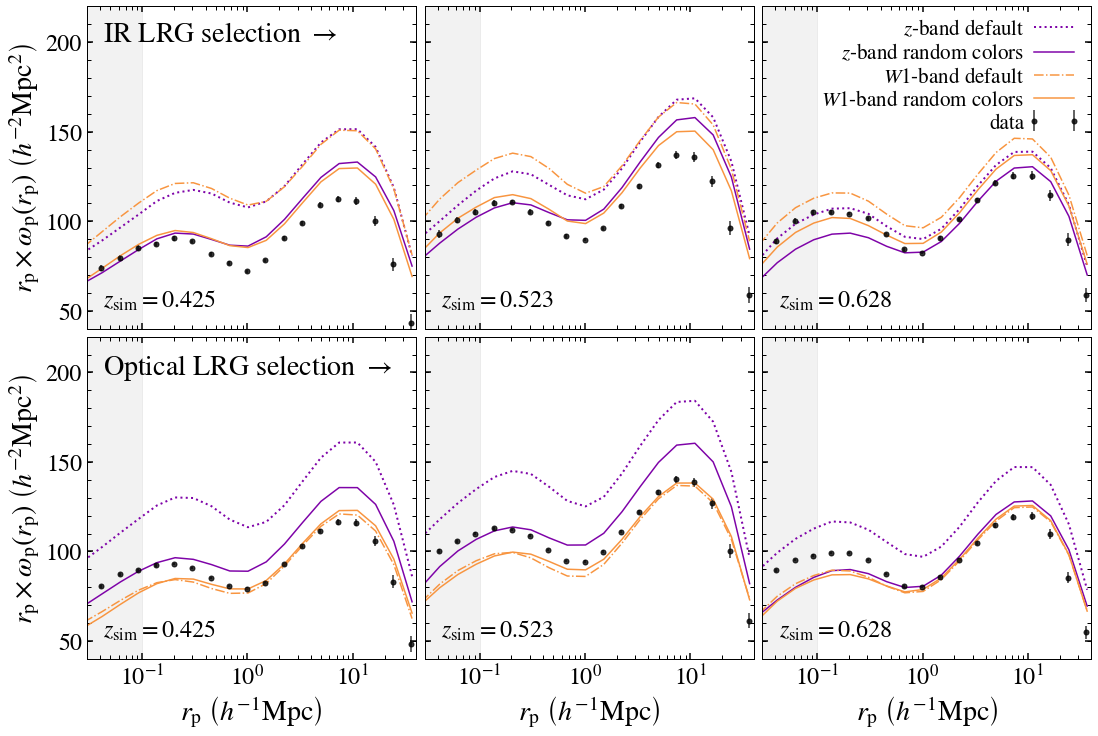

CPU times: user 2min 29s, sys: 15.9 s, total: 2min 45s
Wall time: 2min 46s


In [63]:
%%time

from scipy.signal import savgol_filter
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

c_opt, c_IR = get_colors(2)

n_iter   = 1
nthreads = 2
pimax    = 150.
rp_use_range = (0.1,None)
rp_use_min, rp_use_max = rp_use_range
boxsize = get_boxsize("mdpl2")

#-- rp bins used to measure model clustering already have units of comoving Mpc, so do NOT multiply by h
b = ascii.read(bin_file_comoving)
rp_bins = np.concatenate([b["col1"],[b["col2"][-1]]])
rp_mids = 0.5*(rp_bins[1:] + rp_bins[:-1])


fig, axes = plt.subplots(2, 3, figsize=(18,12), sharex=True, sharey=True)

for ax in axes.flat:
    ax.semilogx()
    ax.set_xlim(0.03,40)
    ax.set_ylim(40,220)
    ax.tick_params(axis="both", which="major", labelsize=24)
    ax.fill_between((ax.get_xlim()[0],rp_use_min), ax.get_ylim()[1]*np.ones(2), color="gray", alpha=0.1)
    ax.yaxis.set_major_locator(MultipleLocator(50))
    ax.yaxis.set_minor_locator(MultipleLocator(10))

for ax in axes[1,:]:
    ax.set_xlabel(fig_labels["rp"], fontsize=28)
for ax in axes[:,0]:
    ax.set_ylabel(fig_labels["rpwp"], fontsize=28)

for row,sel in zip((0,1),("IR","Optical")):
    axes[row][0].text(*get_corners(axes[row][0],logx=True)["upper_left"], f"{sel} LRG selection " + r"$\rightarrow$", va="top", ha="left", fontsize=28)

for row,lrg_selection in zip((0,1),("IR","opt")):
    for col,this_zmin in zip((0,1,2),(0.4,0.5,0.6)):
        ax = axes[row,col]
        
        this_MW1lim = get_abs_mag_lim(this_zmin,"MW1")
        this_Mzlim  = get_abs_mag_lim(this_zmin,"Mz")
        this_MW1_abs_mag_lim_tag = get_MW1_tag(this_MW1lim)
        this_Mz_abs_mag_lim_tag  = get_Mz_tag(this_Mzlim)

        #-- DATA clustering measurements
        this_cat_tag = get_cat_tag("south", (this_zmin,this_zmin+0.1))
        cross_data   = "LXL" if lrg_selection=="IR" else "LXLopt"
        print(this_cat_tag, cross_data)
        fpath    = f"{BASEDIR}/clustering/zmaglim20p7/{this_MW1_abs_mag_lim_tag}/no_abs_mag_bins"
        wp_fname = f"{fpath}/wp/{this_cat_tag}_{cross_data}_pimax{int(pimax)}.txt"
        assert(os.path.exists(wp_fname))
        data   = ascii.read(wp_fname)
        #-- units of rp used for data clustering measurements are Mpc (not comoving)
        #-- multiply by h to convert to comoving Mpc and compare to model
        rp_cen = h*data["rp_cen"]
        #-- wp has same units as rp, so multiply by h as well (same for wp error)
        wp_dat = h*data["wp"]
        wp_err = h*np.sqrt(data["wp_err"])

        zphot_label = f"$({this_zmin}$" + r"$<z_{\rm phot}<\ $" + f"${this_zmin + 0.1})$"
        this_zsim  = np.array(z_snaps)[ np.round(z_snaps,1)==this_zmin ][0]
        zsim_label = r"$z_{\rm sim}=$" + f"${this_zsim:.3f}$"
        ax.text(*get_corners(ax, logx=True, margin=0.05)["lower_left"], zsim_label, fontsize=24, va="bottom", ha="left")

        ax.errorbar(rp_cen, rp_cen*wp_dat, yerr=rp_cen*wp_err, label="data", color="black", marker="o", ms=5, ls="", ecolor="black", alpha=0.8)

        #-- MODEL clustering measurements
        zsnap_tag = get_zsnap_tag(this_zsim)
        galcat_fname_MW1 = f"{BASEDIR}/mocks/mdpl2/vpeak/south/color_scatter/{zsnap_tag}_{this_MW1_abs_mag_lim_tag}_galcat-LRG.npy"
        galcat_fname_Mz  = f"{BASEDIR}/mocks/mdpl2/vpeak/south/color_scatter/{zsnap_tag}_{this_Mz_abs_mag_lim_tag}_galcat-LRG.npy"
        # print(galcat_fname_MW1.split("/")[-1])
        # print(galcat_fname_Mz.split("/")[-1])
        
        cat_MW1 = Table(np.load(galcat_fname_MW1))
        cat_Mz  = Table(np.load(galcat_fname_Mz))
        
        one_halo = (rp_cen > 0.1) & (rp_cen < 1.0)
        two_halo = (rp_cen > 1.0)
        
        for this_band,this_mock,color in zip(("Mz","MW1"),(cat_Mz,cat_MW1),(c_opt,c_IR)):
            #cs = get_cs(band=this_band, zmin=this_zmin)
            cs_tag = "csrand" #f"cs{cs}".replace(".","p")

            #-- compute sigma_los for specified parameterization
            m_los, b_los = popt[this_band][this_zmin]
            sigma_los = m_los*this_mock[this_band].data + b_los
            sigma_los[sigma_los <= 0.0] = 0.0

            #-- "LXL" for IR DESI LRG selection
            if lrg_selection=="IR":
                print(f"{this_band}\t{this_zmin}\tIR LRG selection\t{m_los,b_los}\t{cs_tag}")
                cross = "LXL"
                this_lrg_mask    = this_mock["LRG_IR"]==True
                this_lrg_mask_cs = this_mock[f"LRG_IR_{cs_tag}"]==True
            #-- "LXLopt" for optical DESI LRG selection
            elif ("opt" in lrg_selection) | (lrg_selection=="optical"):
                lrg_selection = "opt"
                print(f"{this_band}\t{this_zmin}\toptical LRG selection\t{m_los,b_los}\t{cs_tag}")
                cross = "LXLopt"
                this_lrg_mask    = this_mock["LRG_opt"]==True
                this_lrg_mask_cs = this_mock[f"LRG_opt_{cs_tag}"]==True
            else:
                raise Exception()

            for lrg_mask,show_cs in zip((this_lrg_mask,this_lrg_mask_cs),(False,True)):
                out = []
                for (u,v,w) in (("x","y","z"),("y","z","x"),("z","x","y")):
                    xx = this_mock[u][lrg_mask]
                    yy = this_mock[v][lrg_mask]
                    zz = this_mock[w][lrg_mask]
                    z_scatter = np.array([np.random.normal(zz, sigma_los[lrg_mask], len(zz)) for idx in range(n_iter)])
                    z_scatter[z_scatter < 0] = np.array(boxsize - np.abs(z_scatter[z_scatter < 0])%boxsize)
                    z_scatter[z_scatter > boxsize] = np.array(z_scatter[z_scatter > boxsize]%boxsize)

                    out.append([wp_corrfunc(boxsize, pimax, nthreads, bin_file_comoving, xx, yy, z_s, output_rpavg=False)["wp"] for z_s in z_scatter])

                out = np.concatenate(out).T

                wp_mean = np.mean(out, axis=1)
                wp_mod  = wp_mean

                pct_diff = (wp_mod - wp_dat) / wp_dat
                pct_diff_str = f"({np.mean(pct_diff[one_halo]):.2f}, {np.mean(pct_diff[two_halo]):.2f})"

                labels = {"MW1":r"$W1$-band default",# + pct_diff_str,
                          "Mz":r"$z$-band default"}# + pct_diff_str}
                labels_cs = {"MW1":r"$W1$-band random colors",# + pct_diff_str,
                             "Mz":r"$z$-band random colors"}# + pct_diff_str}
                if show_cs==False:
                    ls = ":" if this_band=="Mz" else "dashdot"
                    lw = 2 if this_band=="Mz" else 1.5
                    ax.plot(rp_mids, savgol_filter(rp_mids*wp_mod,7,3), color=color, label=labels[this_band], ls=ls, lw=lw)
                    #print(f"{(rp_mids*wp_mod)[5]:.3f}\t{(rp_mids*wp_mod)[-5]:.3f}")
                else:
                    ax.plot(rp_mids, savgol_filter(rp_mids*wp_mod,7,3), color=color, label=labels_cs[this_band], ls="-", lw=1.5)
                    #print(f"{(rp_mids*wp_mod)[5]:.3f}\t{(rp_mids*wp_mod)[-5]:.3f}")

axes[0][-1].legend(numpoints=2, handlelength=2.5, fontsize=21, loc=1, borderpad=0.05, handletextpad=0.15, labelspacing=0.15, markerfirst=False)

plt.subplots_adjust(hspace=0.025, wspace=0.025)

figname = f"{BASEDIR}/figures/wp_data-vs-mock/lrg_csrand.png"
print(figname)
#plt.savefig(figname, dpi=200, bbox_inches="tight", pad_inches=0.1)

plt.show()
    


<a class="anchor" id="not_lrg"></a>

# What's the deal with those central galaxies in massive halos that aren't LRGs?

[BACK TO TOP](#outline)

In [ ]:
parent_mvir_14p5 = log_parent_mvir > 14.5

not_lrg_opt = cat[~lrg_mask_opt & cenmask & parent_mvir_14p5]
not_lrg_IR  = cat[~lrg_mask_IR & cenmask & parent_mvir_14p5]



In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))

try:
    colors
except:
    colors = get_colors(2)

ax.scatter(not_lrg_IR[band], not_lrg_IR[f"r-{band[1:]}"], s=100, marker="+", color=colors[1], label=r"${\rm IR\ selection}$ " + f"$(N={len(not_lrg_IR)})$")
ax.scatter(not_lrg_opt[band], not_lrg_opt[f"r-{band[1:]}"], s=25, alpha=0.4, color=colors[0], label=r"${\rm optical\ selection}$ " + f"$(N={len(not_lrg_opt)})$")

ax.tick_params(axis="both", which="major", labelsize=20, direction="in")

ax.legend(handletextpad=0.1, borderpad=0.25, labelspacing=0.25, fontsize=18, frameon=True, loc=3)

mag_label = r"${\rm model}\ M_{\rm z}$" if (band=="Mz") else r"$M_{\rm W1}$"
ax.set_xlabel(mag_label, fontsize=20)
if band=="Mz":
    ax.set_xlim(-20.5,-25.5)
    ax.set_ylim(0.25,3)
elif band=="MW1":
    ax.set_xlim(-22.5,-26.2)
    ax.set_ylim(2.25,5.75)
ax.set_ylabel(r"${\rm model}\ $" + f"$(r-{band[1:]})$", fontsize=20)

ax.text(*get_corners(ax)["upper_left"], r"$z_{\rm sim}=\ $" + f"${zsim:.3f}$", fontsize=20, ha="left", va="top")
plt.tight_layout()

figname = f"{BASEDIR}/figures/notLRG-outliers_{zsnap_tag}_{abs_mag_lim_tag}_{rp_use_tag}.png"
print(figname)
# plt.savefig(figname, bbox_inches="tight", pad_inches=0.1, dpi=200)

plt.show()


<a class="anchor" id="dr9"></a>

## Load DR9 data

[BACK TO TOP](#outline)

In [ ]:
data_table = vstack([Table(np.load(f"{BASEDIR}/mags_z0p40-0p50_south.npy")),
                     Table(np.load(f"{BASEDIR}/mags_z0p50-0p60_south.npy")),
                     Table(np.load(f"{BASEDIR}/mags_z0p60-0p70_south.npy")),]
                   )
# print(data_table.colnames)

g, r, z, W1 = data_table["g"], data_table["r"], data_table["z"], data_table["W1"]
Mg, Mr, Mz, MW1 = data_table["Mg"], data_table["Mr"], data_table["Mz"], data_table["MW1"]
zfiber, pz = data_table["zfiber"], data_table["pz"]

lrg_opt = data_table["LRG_opt"]==True
lrg_IR  = data_table["LRG_IR"]==True

lrg_opt_mask = lrg_opt # & (Mz < -23.8)
lrg_IR_mask  = lrg_IR # & (Mz < -23.8)

#-- OPTICAL SELECTION MASKS
mask_stellar = z-W1 > 0.8*(r-z) - 0.6
mask_lowz    = ( (g-W1 > 2.6) & (g-r > 1.4) ) | (r-W1 > 1.8)
mask_color   = ( r-z > 0.45*(z-16.83) ) & ( r-z > 0.19*(z - 13.80) ) & ( r-z > 0.7 )
mask_zfiber  = zfiber < 21.5

#-- NOT LRG MASKS FOR OPTICAL SPACE
not_lrg_opt_mask = ~lrg_opt & (Mz < -23.8)# & mask_zfiber
not_lrg_IR_mask  = ~lrg_IR & (Mz < -23.8) # & mask_zfiber


def lrg_contour(ax, x, y, bg_mask=bg_mask, bg_DS=bg_DS, colors="black", colorsf="gray", leg=False):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    if xlim[0] > xlim[1]:
        xlim = xlim[::-1]
    if ylim[0] > ylim[1]:
        ylim = ylim[::-1]
    H, X, Y = np.histogram2d( x[bg_mask][::bg_DS], y[bg_mask][::bg_DS], bins=(80,80), range=(xlim,ylim) )
    XX = 0.5*(X[:-1]+X[1:])
    YY = 0.5*(Y[:-1]+Y[1:])
    #print(np.max(H))
    levels = np.logspace(1.,np.log10(1.5*np.max(H)),5)
    #print(levels)
    ax.contourf(XX, YY, H.T, colors=colorsf, alpha=0.2, levels=levels)
    ax.contour(XX, YY, H.T, colors=colors, linewidths=1, levels=levels)



In [ ]:
# selection = "optical"

# kwargs = dict(s=3, alpha=0.8, cmap="plasma")
# DS     = 2

# bg_kwargs = dict(s=3, alpha=0.05, color="gray")
# bg_DS     = 10

# line_kwargs = dict(lw=3, color="k")

# if selection=="IR":
#     mask    = not_lrg_IR_mask
#     bg_mask = lrg_IR_mask
#     title   = r"${\rm IR\ Selection\ (gray=LRG;\ color}={\rm bright}\ (M_z < -23.8)\ {\rm but\ NOT\ LRG)}$"
# else:
#     selection = "optical"
#     mask    = not_lrg_opt_mask
#     bg_mask = lrg_opt_mask
#     title   = r"${\rm Optical\ Selection\ (gray=LRG;\ color}={\rm bright}\ (M_z < -23.8)\ {\rm but\ NOT\ LRG)}$"  

# fig, axes = plt.subplots(1,4, figsize=(18,5.5))
# #fig, axes = plt.subplots(2, 2, figsize=(10,10))

# ax = axes[0] #axes[0][0]
# ax.set_xlim(0.2, 2.8)
# ax.set_ylim(-1, 3)
# ax.set_xlabel("$r-z$")
# ax.set_ylabel("$z-W1$")
# ax.set_xticks(np.arange(0.5,3.0,0.5))
# ax.set_title("Stellar rejection cut", fontsize=18)

# x, y = r-z, z-W1
# lrg_contour(ax, x, y)
# # ax.scatter(x[bg_mask][::bg_DS], y[bg_mask][::bg_DS], **bg_kwargs)
# ax.scatter(x[mask][::DS], y[mask][::DS], c=pz[mask][::DS], **kwargs)
# # stellar rejection cut
# # z - W1 > 0.8*(r - z) - 0.6
# xx = np.linspace(*ax.get_xlim())
# yy = 0.8*xx - 0.6
# ax.plot(xx, yy, **line_kwargs)

# xt = 0.3
# ax.text(xt, 2.8, "Gray contours: optical LRG targets", ha="left", va="top", fontsize=16)
# ax.text(xt, 2.45, "Color points: bright $(M_z < -23.8)$", ha="left", va="top", fontsize=16)
# ax.text(xt, 2.2, " red-sequence but $not$ LRG target", ha="left", va="top", fontsize=16)


# ax = axes[1] #axes[0][1]
# ax.set_xlim(-0.1, 4.5)
# ax.set_ylim(0, 2.7)
# ax.set_xlabel("$r-W1$")
# ax.set_ylabel("$g-r$")
# ax.set_xticks(np.arange(0,5,1))
# ax.set_title("Faint or blue galaxy cut", fontsize=18)

# x, y = r-W1, g-r
# lrg_contour(ax, x, y)    
# # ax.scatter(x[bg_mask][::bg_DS], y[bg_mask][: :bg_DS], **bg_kwargs)
# ax.scatter(x[mask][::DS], y[mask][::DS], c=pz[mask][::DS], **kwargs)
# # eliminate low-redshift or bluer objects
# # ( (g - W1 > 2.6) AND (g - r > 1.4) ) OR (r - W1 > 1.8)
# g_r  = np.linspace(*ax.get_ylim(), 100)
# r_W1 = np.linspace(*ax.get_xlim(), 100)
# line_mask = ( (g_r < 2.6 - r_W1) & (g_r < 1.4) ) | (r_W1 < 1.8)
# ax.plot( r_W1[ r_W1 <= 1.2 ], (-r_W1 + 2.6)[ r_W1 <= 1.2 ], **line_kwargs )
# ax.plot( r_W1[ (r_W1 >= 1.2) & (r_W1 <= 1.8) ], 1.4*np.ones(len(r_W1))[ (r_W1 >= 1.2) & (r_W1 <= 1.8) ], **line_kwargs )
# ax.plot( 1.8*np.ones(len(g_r))[ g_r <= 1.4 ], g_r[ g_r <= 1.4 ], **line_kwargs )


# ax = axes[2] #axes[1][0]
# ax.set_xlim(16.5, 21.6)
# ax.set_ylim(0.25, 2.75)
# ax.set_xlabel("$z$")
# ax.set_ylabel("$r-z$")
# ax.set_xticks(np.arange(17,22,1))
# ax.text(*get_corners(ax, margin=0.04)["lower_right"], "Color-dependent\nmagnitude cut\n(brightest galaxies)", ha="right", va="bottom", fontsize=18)

# x, y = z, r-z
# lrg_contour(ax, x, y)    
# # ax.scatter(x[bg_mask][::bg_DS], y[bg_mask][::bg_DS], **bg_kwargs)
# cbar = ax.scatter(x[mask][::DS], y[mask][::DS], c=pz[mask][::DS], **kwargs)
# # color-dependent magnitude limit selects only most luminous objects at given redshift
# # ( r - z > 0.45*(z - 16.83) ) AND (r - z > 0.19*(z - 13.80) )
# # r - z > 0.7
# xx = np.linspace(*ax.get_xlim(), 100)
# m1, m2, m3 = (xx <= 17.48), ((xx >= 17.48) & (xx <= 19.04)), (xx >= 19.04)
# ax.plot(xx[m1], 0.7*np.ones(len(xx))[m1], **line_kwargs)
# ax.plot(xx[m2], 0.19*(xx - 13.80)[m2], **line_kwargs)
# ax.plot(xx[m3], 0.45*(xx - 16.83)[m3], **line_kwargs)


# ax = axes[3] #axes[1][1]
# ax.set_xlim(17, 21.7)
# ax.set_ylim(18, 23)
# ax.set_xlabel("$z$")
# ax.set_ylabel(r"$z_{\rm fiber}$")
# ax.set_xticks(np.arange(17,22,1))
# ax.text(*get_corners(ax, margin=0.04)["lower_right"], r"DESI fiber mag. cut" + "\n(secure spec. redshifts)", ha="right", va="bottom", fontsize=18)

# x, y = z, zfiber
# lrg_contour(ax, x, y, leg=True)
# # ax.scatter(x[bg_mask][::bg_DS], y[bg_mask][::bg_DS], **bg_kwargs)
# ax.scatter(x[mask][::DS], y[mask][::DS], c=pz[mask][::DS], **kwargs)
# # ensure targets yield secure spec-z measurements
# # zfiber < 21.5
# ax.plot(ax.get_xlim(), 21.5*np.ones(2), **line_kwargs)

# # ax = axes[1][0]
# # ax.set_xlim(16.2, 20.5)
# # ax.set_ylim(0.3, 5)
# # ax.set_xlabel("$W1$")
# # ax.set_ylabel("$r-W1$")
# # ax.set_xticks(np.arange(17,21,1))

# # x, y = W1, r-W1
# # ax.scatter(x[bg_mask][::bg_DS], y[bg_mask][::bg_DS], **bg_kwargs)
# # ax.scatter(x[mask][::DS], y[mask][::DS], c=pz[mask][::DS], **kwargs)

# # ax = axes[1][2]
# # ax.set_xlim(-20.5,-25.5)
# # ax.set_ylim(0, 2.7)
# # ax.set_xlabel("$M_z$")
# # ax.set_ylabel("$r-z$")
# # ax.set_xticks(np.arange(-25,-20,1))

# # x, y = Mz, r-z
# # ax.scatter(x[bg_mask][::bg_DS], y[bg_mask][::bg_DS], **bg_kwargs)
# # ax.scatter(x[mask][::DS], y[mask][::DS], c=pz[mask][::DS], **kwargs)


# #cax = plt.axes([0.9125,0.125,0.020,0.755])
# cax = plt.axes([0.995,0.1625,0.0115,0.75])
# fig.colorbar(cbar, cax=cax).set_ticks(np.arange(0.4,0.71,0.05))
# cax.tick_params(axis="both", which="both", labelsize=20)
# cax.set_ylabel(r"$z_{\rm phot}$", fontsize=30)
# #cax.yaxis.label.set_size(32)

# for ax in axes:
# #for ax in np.concatenate(axes):
#     ax.tick_params(axis="both", which="both", labelsize=20)
#     ax.xaxis.label.set_size(24)
#     ax.yaxis.label.set_size(24)
    
# #plt.subplots_adjust(hspace=0.2, wspace=0.25)
# plt.tight_layout()
# plt.subplots_adjust(wspace=0.25)

# figname = f"{BASEDIR}/figures/notLRG-outliers_{selection}_4x1.png"
# print(figname)

# #plt.savefig(figname, bbox_inches="tight", pad_inches=0.1, dpi=300)

# plt.show()


In [ ]:
# selection = "IR"

# #-- IR SELECTION MASKS
# mask_stellar = z-W1 > 0.8*(r-z) - 0.6
# mask_lowz    = (g-W1 > 2.9) | (r-W1 > 1.8)
# mask_color   = ( (r-W1 > 1.8*(W1-17.14)) & (r-W1 > W1-16.33) ) | ( r-W1 > 3.3 )
# mask_zfiber  = zfiber < 21.6

# #-- NOT LRG MASKS FOR IR SPACE
# not_lrg_opt_mask = ~lrg_opt & (MW1 < -24.8)# & mask_zfiber
# not_lrg_IR_mask  = ~lrg_IR & (MW1 < -24.8) # & mask_zfiber


# if selection=="IR":
#     mask    = not_lrg_IR_mask
#     bg_mask = lrg_IR_mask
#     title   = r"${\rm IR\ Selection\ (gray=LRG;\ color}={\rm bright}\ (M_{W1} < -24.8)\ {\rm but\ NOT\ LRG)}$"
# else:
#     selection = "optical"
#     mask    = not_lrg_opt_mask
#     bg_mask = lrg_opt_mask
#     title   = r"${\rm Optical\ Selection\ (gray=LRG;\ color}={\rm bright}\ (M_{W1} < -24.8)\ {\rm but\ NOT\ LRG)}$"
    

# fig, axes = plt.subplots(1,4, figsize=(18,5.5))

# ax = axes[0]
# ax.set_xlim(0.4, 2.8)
# ax.set_ylim(-1, 3)
# ax.set_xlabel("$r-z$")
# ax.set_ylabel("$z-W1$")
# ax.set_xticks(np.arange(0.5,3.0,0.5))
# ax.set_title("Stellar rejection cut", fontsize=18)

# x, y = r-z, z-W1
# lrg_contour(ax, x, y)
# ax.scatter(x[mask][::DS], y[mask][::DS], c=pz[mask][::DS], **kwargs)
# # stellar rejection cut
# # z - W1 > 0.8*(r - z) - 0.6
# xx = np.linspace(*ax.get_xlim())
# yy = 0.8*xx - 0.6
# ax.plot(xx, yy, **line_kwargs)

# xt = 0.55
# ax.text(xt, -0.2, "Gray contours: IR LRG targets", ha="left", va="top", fontsize=16)
# ax.text(xt, -0.45, "Color points: bright $(M_{W1} < -24.8)$", ha="left", va="top", fontsize=16)
# ax.text(xt, -0.65, " red-sequence but $not$ LRG target", ha="left", va="top", fontsize=16)


# ax = axes[1]
# ax.set_xlim(-0.2, 4.5)
# ax.set_ylim(0, 2.7)
# ax.set_xlabel("$r-W1$")
# ax.set_ylabel("$g-r$")
# ax.set_xticks(np.arange(0,5,1))
# ax.set_title("Faint or blue galaxy cut", fontsize=18)

# x, y = r-W1, g-r
# lrg_contour(ax, x, y)
# ax.scatter(x[mask][::DS], y[mask][::DS], c=pz[mask][::DS], **kwargs)
# # eliminate low-redshift or bluer objects
# # (g - W1 > 2.9) OR (r - W1 > 1.8)
# # mask_stellar = z-W1 > 0.8*(r-z) - 0.6
# # mask_lowz    = (g-W1 > 2.9) | (r-W1 > 1.8)
# # mask_color   = ( (r-W1 > 1.8*(W1-17.14)) & (r-W1 > W1-16.33) ) | ( r-W1 > 3.3 )

# g_r  = np.linspace(*ax.get_ylim(), 100)
# r_W1 = np.linspace(*ax.get_xlim(), 100)
# line_mask = (g-W1 > 2.9) | (r-W1 > 1.8)
# ax.plot( r_W1[ g_r <= 1.1 ], (-r_W1 + 2.9)[ g_r <= 1.1 ], **line_kwargs )
# ax.plot( 1.8*np.ones(len(g_r))[ g_r <= 1.1 ], g_r[ g_r <= 1.1 ], **line_kwargs )


# ax = axes[2]
# ax.set_xlim(16.25, 20.2)
# ax.set_ylim(0.25, 5)
# ax.set_xlabel("$W1$")
# ax.set_ylabel("$r-W1$")
# ax.set_xticks(np.arange(17,21,1))
# ax.text(*get_corners(ax, margin=0.04)["upper_right"], "Color-dependent\nmagnitude cut\n(brightest galaxies)", ha="right", va="top", fontsize=18)

# x, y = W1, r-W1
# lrg_contour(ax, x, y)    
# cbar = ax.scatter(x[mask][::DS], y[mask][::DS], c=pz[mask][::DS], **kwargs)
# # color-dependent magnitude limit selects only most luminous objects at given redshift
# # ( r-W1 > 3.3 ) | ( (r-W1 > 1.8*(W1-17.14)) & (r-W1 > W1-16.33) )
# xx = np.linspace(*ax.get_xlim(), 100)
# m1, m2, m3 = (xx >= 18.97), ((xx <= 18.97) & (xx >= 18.15)), (xx <= 18.15)
# ax.plot(xx[m1], 3.3*np.ones(len(xx))[m1], **line_kwargs)
# ax.plot(xx[m2], 1.8*(xx - 17.14)[m2], **line_kwargs)
# ax.plot(xx[m3], (xx - 16.33)[m3], **line_kwargs)


# ax = axes[3]
# ax.set_xlim(16.5, 21.6)
# ax.set_ylim(17.5, 22.5)
# ax.set_xlabel("$z$")
# ax.set_ylabel(r"$z_{\rm fiber}$")
# ax.set_xticks(np.arange(17,22,1))
# ax.text(*get_corners(ax, margin=0.04)["lower_right"], r"DESI fiber mag. cut" + "\n(secure spec. redshifts)", ha="right", va="bottom", fontsize=18)

# x, y = z, zfiber
# lrg_contour(ax, x, y, leg=True)
# ax.scatter(x[mask][::DS], y[mask][::DS], c=pz[mask][::DS], **kwargs)
# # ensure targets yield secure spec-z measurements
# # zfiber < 21.6
# ax.plot(ax.get_xlim(), 21.6*np.ones(2), **line_kwargs)


# cax = plt.axes([0.995,0.1625,0.0115,0.75])
# fig.colorbar(cbar, cax=cax).set_ticks(np.arange(0.4,0.71,0.05))
# cax.tick_params(axis="both", which="both", labelsize=20)
# cax.set_ylabel(r"$z_{\rm phot}$", fontsize=30)

# for ax in axes:
#     ax.tick_params(axis="both", which="both", labelsize=20)
#     ax.xaxis.label.set_size(24)
#     ax.yaxis.label.set_size(24)
    
# plt.tight_layout()
# plt.subplots_adjust(wspace=0.25)

# figname = f"{BASEDIR}/figures/notLRG-outliers_IR-space_{selection}_4x1.png"
# print(figname)
# #plt.savefig(figname, bbox_inches="tight", pad_inches=0.1, dpi=300)

# plt.show()


In [ ]:
%%time

from matplotlib.patches import Patch
from matplotlib import colors

lrg_IR_not_opt = (data_table["LRG_IR"]==True) & (data_table["LRG_opt"]==False)
lrg_opt_not_IR = (data_table["LRG_IR"]==False) & (data_table["LRG_opt"]==True)

lrg_not_opt_not_IR = (data_table["LRG_IR"]==False) & (data_table["LRG_opt"]==False)

is_bright = Mz < -23.7

pass_stellar = z - W1 > 0.8*(r - z) - 0.6

# color-dependent magnitude limit selects only most luminous objects at given redshift
pass_IR_sliding  = ( r-W1 > 3.3 ) | ( (r-W1 > 1.8*(W1-17.14)) & (r-W1 > W1-16.33) )
pass_opt_sliding = (r - z > 0.45*(z - 16.83)) & (r - z > 0.19*(z - 13.80)) & (r - z > 0.7)

# low-z and/or blue cut
pass_IR_blue  = (g-W1 > 2.9) | (r-W1 > 1.8)
pass_opt_blue = ( (g-r < 2.6 - r-W1) & (g-r < 1.4) ) | (r-W1 < 1.8)

bg_DS = 1

kwargs = dict(s=5, alpha=1.0, cmap="plasma")

cc_opt  = "darkslategray"
ccf_opt = "c"

line_kwargs_opt = dict(lw=2.5, color="k", ls="--")
line_kwargs     = dict(lw=2.5, color="k")


#-- NOT IR LRG & NOT OPTICAL LRG & IS BRIGHT
mask    = lrg_not_opt_not_IR & is_bright & pass_stellar & (pass_IR_sliding & pass_opt_sliding) & (zfiber < 21.5)
bg_mask = lrg_IR
title   = "color points: (not LRG) & ($M_z < -23.7$) & (pass stellar cut) & (pass sliding cuts) & (pass zfiber cut)" #; gray contours: all IR LRGs"
# figname = f"{BASEDIR}/figures/not-LRG_is-bright.pdf"
# figname = f"{BASEDIR}/figures/not-LRG_is-bright_pass-stellar.pdf"
# figname = f"{BASEDIR}/figures/not-LRG_is-bright_pass-stellar-sliding.pdf"
figname = f"{BASEDIR}/figures/not-LRG_is-bright_pass-stellar-sliding-zfiber.pdf"
DS      = 1


# #-- IS IR LRG & NOT OPTICAL LRG
# mask    = lrg_IR_not_opt
# bg_mask = lrg_IR
# title   = "color points: (is IR LRG) & (not optical LRG); gray contours: all IR LRGs"
# figname = f"{BASEDIR}/figures/not-opt_is-IR_LRG.png"
# DS      = 2

# #-- IS OPTICAL LRG & NOT IR LRG
# mask    = lrg_opt_not_IR
# bg_mask = lrg_opt
# title   = "color points: (is optical LRG) & (not IR LRG); gray contours: all optical LRGs"
# figname = f"{BASEDIR}/figures/not-IR_is-opt_LRG.png"
# DS      = 2

# #-- IS IR LRG & NOT OPTICAL LRG & IS BRIGHT
# mask    = lrg_IR_not_opt & is_bright
# bg_mask = lrg_IR
# title   = "color points: (is IR LRG) & (not optical LRG) & ($M_z < -23.8$); gray contours: all IR LRGs"
# figname = f"{BASEDIR}/figures/not-opt_is-IR_is-bright_LRG.png"
# DS      = 1

# #-- IS OPTICAL LRG & NOT IR LRG & IS BRIGHT
# mask    = lrg_opt_not_IR & is_bright
# bg_mask = lrg_opt
# title   = "color points: (is optical LRG) & (not IR LRG) & ($M_z < -23.8$); gray contours: all optical LRGs"
# figname = f"{BASEDIR}/figures/not-IR_is-opt_is-bright_LRG.png"
# DS      = 1


fig, axes = plt.subplots(2,3, figsize=(13.5,9))

####################################################################
####################################################################

ax = axes[0][0]
ax.set_xlim(0.2,2) #(0.4, 2.8)
ax.set_ylim(-1, 3)
ax.set_xlabel("$r-z$")
ax.set_ylabel("$z-W1$")
#ax.set_xticks(np.arange(0.5,2.5,0.5))
ax.text(*get_corners(ax)["lower_right"], "Stellar rejection cut\n(IR and optical selections)", fontsize=18, ha="right", va="bottom")

x, y = r-z, z-W1
lrg_contour(ax, x, y, bg_mask=lrg_IR, bg_DS=bg_DS)
lrg_contour(ax, x, y, bg_mask=lrg_opt, bg_DS=bg_DS, colors=cc_opt, colorsf=ccf_opt)
ax.scatter(x[mask][::DS], y[mask][::DS], c=pz[mask][::DS], **kwargs)

# stellar rejection cut
# z - W1 > 0.8*(r - z) - 0.6
xx = np.linspace(*ax.get_xlim())
yy = 0.8*xx - 0.6
ax.plot(xx, yy, **line_kwargs)

#ax.text(0.3, 3.2, title, ha="left", va="bottom")

####################################################################

ax = axes[0][1]
ax.set_xlim(15.8,19.2) #(16.25, 20.2)
ax.set_ylim(0, 4.5)
ax.set_xlabel("$W1$")
ax.set_ylabel("$r-W1$")
#ax.set_xticks(np.arange(16,20,1))
ax.text(*get_corners(ax)["upper_right"], "Sliding color-mag cut (IR)", fontsize=18, ha="right", va="top")
#ax.text(np.mean(ax.get_xlim()), 5.5, title, fontsize=22, ha="center", va="top")

x, y = W1, r-W1
lrg_contour(ax, x, y, bg_mask=lrg_IR, bg_DS=bg_DS)
ax.scatter(x[mask][::DS], y[mask][::DS], c=pz[mask][::DS], **kwargs)

# IR color-dependent magnitude limit selects only most luminous objects at given redshift
# ( r-W1 > 3.3 ) | ( (r-W1 > 1.8*(W1-17.14)) & (r-W1 > W1-16.33) )
xx = np.linspace(*ax.get_xlim(), 100)
m1, m2, m3 = (xx >= 18.97), ((xx <= 18.97) & (xx >= 18.15)), (xx <= 18.15)
ax.plot(xx[m1], 3.3*np.ones(len(xx))[m1], **line_kwargs)
ax.plot(xx[m2], 1.8*(xx - 17.14)[m2], **line_kwargs)
ax.plot(xx[m3], (xx - 16.33)[m3], **line_kwargs)

####################################################################

ax = axes[0][2]
ax.set_xlim(-22.5, -26)
ax.set_ylim(axes[0][1].get_ylim())
ax.set_xlabel("$M_{W1}$")
ax.set_ylabel("$M_r-M_{W1}$")

x, y = MW1, r-W1
lrg_contour(ax, x, y, bg_mask=lrg_IR, bg_DS=bg_DS)
ax.scatter(x[mask][::DS], y[mask][::DS], c=pz[mask][::DS], **kwargs)

cont_IR = [Patch(fc=((*colors.to_rgba("gray")[:-1]),0.2), ec=((*colors.to_rgba("black")[:-1]),1.0))]
ax.legend(cont_IR, ["all IR LRGs"], fontsize=20, handletextpad=0.4, loc=(0.02,0.01))

####################################################################
####################################################################

ax = axes[1][0]
ax.set_xlim(0.2, 4.5)
ax.set_ylim(0, 3.2)
ax.set_xlabel("$r-W1$")
ax.set_ylabel("$g-r$")
ax.set_xticks(np.arange(1,5,1))
ax.set_yticks(np.arange(0,3.5,0.5))
ax.text(*get_corners(ax)["upper_right"], "Low-$z$ or blue galaxy cut", fontsize=18, ha="right", va="top")

x, y = r-W1, g-r
lrg_contour(ax, x, y, bg_mask=lrg_IR, bg_DS=bg_DS)
lrg_contour(ax, x, y, bg_mask=lrg_opt, bg_DS=bg_DS, colors=cc_opt, colorsf=ccf_opt)
cbar = ax.scatter(x[mask][::DS], y[mask][::DS], c=pz[mask][::DS], **kwargs, label="")

# eliminate low-redshift or bluer objects
g_r  = np.linspace(*ax.get_ylim(), 100)
r_W1 = np.linspace(*ax.get_xlim(), 100)
# IR: (g − W1 > 2.9) OR (r − W1 > 1.8)
line_mask = (g-W1 > 2.9) | (r-W1 > 1.8)
ax.plot( r_W1[ r_W1 <= 1.8 ], (-r_W1 + 2.9)[ r_W1 <= 1.8 ], **line_kwargs, label="IR" )
ax.plot( 1.8*np.ones(len(g_r))[ g_r <= 1.1 ], g_r[ g_r <= 1.1 ], **line_kwargs )
# OPTICAL: ( (g - W1 > 2.6) AND (g - r > 1.4) ) OR (r - W1 > 1.8)
line_mask = ( (g_r < 2.6 - r_W1) & (g_r < 1.4) ) | (r_W1 < 1.8)
ax.plot( r_W1[ r_W1 <= 1.2 ], (-r_W1 + 2.6)[ r_W1 <= 1.2 ], **line_kwargs_opt, label="optical" )
ax.plot( r_W1[ (r_W1 >= 1.2) & (r_W1 <= 1.8) ], 1.4*np.ones(len(r_W1))[ (r_W1 >= 1.2) & (r_W1 <= 1.8) ], **line_kwargs_opt )
ax.plot( 1.8*np.ones(len(g_r))[ g_r <= 1.4 ], g_r[ g_r <= 1.4 ], **line_kwargs_opt )

ax.legend(loc=(0.55,0.01), fontsize=18, labelspacing=0.25, markerfirst=False, handletextpad=0.4)

####################################################################

ax = axes[1][1]
ax.set_xlim(16,20.6) #(16.5, 21.6)
ax.set_ylim(axes[0][0].get_xlim()[0],2.5)
ax.set_xlabel("$z$")
ax.set_ylabel("$r-z$")
ax.set_xticks(np.arange(16,21,1))
ax.text(*get_corners(ax)["lower_left"], "Sliding color-mag cut (optical)", fontsize=18, ha="left", va="bottom")

x, y = z, r-z
lrg_contour(ax, x, y, bg_mask=lrg_opt, bg_DS=bg_DS, colors=cc_opt, colorsf=ccf_opt)
ax.scatter(x[mask][::DS], y[mask][::DS], c=pz[mask][::DS], **kwargs)

# optical color-dependent magnitude limit selects only most luminous objects at given redshift
# (r - z > 0.45*(z - 16.83)) AND (r - z > 0.19*(z - 13.80)) AND (r - z > 0.7)
xx = np.linspace(*ax.get_xlim(), 100)
m1, m2, m3 = (xx <= 17.48), ((xx >= 17.48) & (xx <= 19.04)), (xx >= 19.04)
ax.plot(xx[m1], 0.7*np.ones(len(xx))[m1], **line_kwargs_opt)
ax.plot(xx[m2], 0.19*(xx - 13.80)[m2], **line_kwargs_opt)
ax.plot(xx[m3], 0.45*(xx - 16.83)[m3], **line_kwargs_opt)

####################################################################

ax = axes[1][2]
ax.set_xlim(-21.6, -25)
ax.set_ylim(axes[1][1].get_ylim())
ax.set_xlabel("$M_z$")
ax.set_ylabel("$M_r-M_z$")

x, y = Mz, r-z
lrg_contour(ax, x, y, bg_mask=lrg_opt, bg_DS=bg_DS, colors=cc_opt, colorsf=ccf_opt)
ax.scatter(x[mask][::DS], y[mask][::DS], c=pz[mask][::DS], **kwargs)

cont_opt = [Patch(fc=((*colors.to_rgba(ccf_opt)[:-1]),0.2), ec=((*colors.to_rgba(cc_opt)[:-1]),1.0))]
ax.legend(cont_opt, ["all optical LRGs"], fontsize=20, loc=(0.02,0.01), handletextpad=0.4)

####################################################################
####################################################################

cax = plt.axes([0.99,0.1,0.02,0.8625])
fig.colorbar(cbar, cax=cax).set_ticks(np.arange(0.4,0.71,0.05))
cax.tick_params(axis="both", which="both", labelsize=20)
cax.set_ylabel(r"$z_{\rm phot}$", fontsize=30)

####################################################################
####################################################################

for ax in axes.flat:
    ax.tick_params(axis="both", which="both", labelsize=20)
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)

for ax,letter in zip(axes.flat,("(a)","(b)","(c)","(d)","(e)","(f)")):
    ax.text(*get_corners(ax, margin=0.04)["upper_left"], letter, fontsize=22, ha="left", va="top")

plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.20)

print(figname)
#plt.savefig(figname, bbox_inches="tight", pad_inches=0.1)#, dpi=300)

plt.show()


<a class="anchor" id="color-color_mag-mag"></a>

# Data LRG color-color mag-mag comparison

[BACK TO TOP](#outline)

In [ ]:
def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s}\%" if plt.rcParams["text.usetex"] else f"{s}%"


def cont(ax, x, y, mask=None, colors="black", colorsf="gray", leg=False):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    if xlim[0] > xlim[1]:
        xlim = xlim[::-1]
    if ylim[0] > ylim[1]:
        ylim = ylim[::-1]
    H, X, Y = np.histogram2d( x[mask], y[mask], bins=(40,40), range=(xlim,ylim), density=True)
    Hflat = np.concatenate(H)
    XX = 0.5*(X[:-1]+X[1:])
    YY = 0.5*(Y[:-1]+Y[1:])
    qtiles = np.arange(0.1,1.01,0.1)
    levels  = np.quantile(Hflat[Hflat > 0], qtiles)
    ax.contour(XX, YY, H.T, colors=colors, linewidths=1, levels=levels)
    ax.contourf(XX, YY, H.T, colors="white", levels=levels)
    ax.contourf(XX, YY, H.T, colors=colorsf, levels=levels, alpha=0.2)
#     fmt = {}
#     for l,s in zip(cs.levels, pctiles):
#         fmt[l] = rf"{s}"
#     ax.clabel(cs, cs.levels, inline=True, fontsize=14)
    return np.concatenate(H)


In [ ]:
#-- data for relevant photo-z bin

this_zmin = 0.4

this_cat_tag = f"z{this_zmin:.2f}-{(this_zmin+0.1):.2f}_south"
this_cat_tag = this_cat_tag.replace(".","p")
print(this_cat_tag)

t = Table(np.load(f"{BASEDIR}/mags_{this_cat_tag}.npy"))
# t = vstack([Table(np.load(f"{BASEDIR}/mags_z0p40-0p50_south.npy")),
#             Table(np.load(f"{BASEDIR}/mags_z0p50-0p60_south.npy")),
#             Table(np.load(f"{BASEDIR}/mags_z0p60-0p70_south.npy")),]
#            )

r  = t["r"] - t["Kr"]
z  = t["z"] - t["Kz"]
W1 = t["W1"] - t["KW1"]

Mz  = t["Mz"]
MW1 = t["MW1"]

is_lrg_IR  = (t["LRG_IR"]==True)
is_lrg_opt = (t["LRG_opt"]==True)


In [ ]:
DS = 1
pkwargs = dict(color="gray", s=2, alpha=0.5)

fig, axes = plt.subplots(2, 2, figsize=(10,10))

####################################################################
####################################################################

ax = axes[0][0]
ax.set_xlim(1, 5)
ax.set_ylim(0, 2.1)
ax.set_ylabel("$r-z$")
ax.set_xlabel("$r-W1$")

hexkwargs = dict(xscale="linear", yscale="linear", gridsize=80, cmap="binary", bins="log", mincnt=1)

x, y = r-W1, r-z

# xpts  = np.arange(*ax.get_xlim(),0.1)
# ypts  = [np.mean(y[(x > xpts[i]) & (x <= xpts[i+1])]) for i in range(len(xline)-1)]
# xcens = 0.5*(xpts[1:]+xpts[:-1])

mask = is_lrg_IR
#H00 = cont(ax, x, y, mask=mask)
ax.hexbin(x[mask][::DS], y[mask][::DS], **hexkwargs)
ax.set_title("IR LRG selection", fontsize=22)

####################################################################

ax = axes[0][1]
ax.set_xlim(1, 5)
ax.set_ylim(0, 2.1)
#ax.set_ylabel("$r-z$")
ax.set_xlabel("$r-W1$")
ax.set_yticklabels([])

x, y = r-W1, r-z
mask = is_lrg_opt
# H10  = cont(ax, x, y, mask=mask)
ax.hexbin(x[mask][::DS], y[mask][::DS], **hexkwargs)
ax.set_title(r"Optical LRG selection", fontsize=22)
ax.text(*get_corners(ax)["lower_right"], f"{this_zmin}" + r"$< z_{\rm phot} <$" + f"{this_zmin+0.1}", ha="right", va="bottom", fontsize=20)

####################################################################
####################################################################

ax = axes[1][0]
ax.set_xlim(16, 20)
ax.set_ylim(16.5,21.5)
ax.set_ylabel("$z$")
ax.set_xlabel("$W1$")

x, y = W1, z

xpts  = np.arange(*ax.get_xlim(),0.1)
xcens = 0.5*(xpts[1:]+xpts[:-1])

mask = is_lrg_IR
# H01 = cont(ax, x, y, mask=mask)
ax.hexbin(x[mask][::DS], y[mask][::DS], **hexkwargs)

####################################################################

ax = axes[1][1]
ax.set_xlim(16, 20)
ax.set_ylim(16.5,21.5)
#ax.set_ylabel("$z$")
ax.set_xlabel("$W1$")
ax.set_yticklabels([])

x, y = W1, z
mask = is_lrg_opt
# H11 = cont(ax, x, y, mask=mask)
ax.hexbin(x[mask][::DS], y[mask][::DS], **hexkwargs)

####################################################################
####################################################################

for ax in np.concatenate(axes):
    ax.tick_params(axis="both", which="both", labelsize=20)
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    
plt.tight_layout()
plt.subplots_adjust(wspace=0.0, hspace=0.20)

figname = f"{BASEDIR}/figures/color-color_mag-mag_IR-opt_compare_{this_cat_tag[:-6]}.png"
print(figname)

#plt.savefig(figname, bbox_inches="tight", pad_inches=0.1, dpi=300)

plt.show()


In [ ]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
DS = 1

fig, axes = plt.subplots(1, 2, figsize=(9,5), sharex=True, sharey=True)

####################################################################
####################################################################

ax = axes[0]
ax.set_xlim(0.9, 4.2)
ax.set_ylim(0.4, 1.5)
ax.set_xlabel("$r-W1$")
ax.set_ylabel("$r-z$")

hexkwargs = dict(xscale="linear", yscale="linear", gridsize=80, cmap="binary", bins="log", mincnt=1)

x, y = r-W1, r-z

mask = is_lrg_IR
#ax.hexbin(x[mask][::DS], y[mask][::DS], **hexkwargs)
ax.scatter(x[mask][::DS], y[mask][::DS], color="lightgray", s=5, alpha=0.3)
ax.text(*get_corners(ax)["upper_left"], r"IR LRGs", fontsize=24, ha="left", va="top")

H, X, Y = np.histogram2d(x[mask], y[mask], bins=50, range=(ax.get_xlim(), ax.get_ylim()), density=True)
x_cen = [np.mean([X[i],X[i+1]]) for i in range(len(X)-1)]
y_cen = [np.mean([Y[i],Y[i+1]]) for i in range(len(Y)-1)]

levels = np.logspace(-1.5,1,6)
ax.contour(x_cen, y_cen, H.T, colors="k", levels=levels, linewidths=1, density=True)#, label=label)

####################################################################

ax = axes[1]
#ax.set_ylabel("$r-z$")
ax.set_xlabel("$r-W1$")

x, y = r-W1, r-z
mask = is_lrg_opt
#ax.hexbin(x[mask][::DS], y[mask][::DS], **hexkwargs)
ax.scatter(x[mask][::DS], y[mask][::DS], color="lightgray", s=5, alpha=0.3)
ax.text(*get_corners(ax)["upper_left"], r"Optical LRGs", fontsize=24, ha="left", va="top")
ax.text(*get_corners(ax)["lower_right"], f"{this_zmin}" + r"$< z_{\rm phot} <$" + f"{this_zmin+0.1}", ha="right", va="bottom", fontsize=24)

H, X, Y = np.histogram2d(x[mask], y[mask], bins=50, range=(ax.get_xlim(), ax.get_ylim()), density=True)

ax.contour(x_cen, y_cen, H.T, colors="k", levels=levels, linewidths=1, density=True)#, label=label)

####################################################################
####################################################################

for ax in axes:
    ax.tick_params(axis="both", which="both", labelsize=20)
    ax.xaxis.label.set_size(24)
    ax.yaxis.label.set_size(24)
    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    ax.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax.yaxis.set_major_locator(MultipleLocator(0.2))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    
plt.tight_layout()
plt.subplots_adjust(wspace=0)

figname = f"{BASEDIR}/figures/color-color_IR-opt_compare_{this_cat_tag[:-6]}.png"
print(figname)

plt.savefig(figname, bbox_inches="tight", pad_inches=0.1, dpi=300)

plt.show()


<a class="anchor" id="dim_not-lrg"></a>
# Dim red not LRG $W$1-band model test

[BACK TO TOP](#outline)

In [ ]:
from matplotlib.patches import Patch

def cont(x, y, ax, color, alpha=0.3, label=None, trim_levels=True):
    H, X, Y = np.histogram2d(x, y, bins=30, range=(ax.get_xlim()[::-1], ax.get_ylim()), density=True)
    x_cen = [np.mean([X[i],X[i+1]]) for i in range(len(X)-1)]
    y_cen = [np.mean([Y[i],Y[i+1]]) for i in range(len(Y)-1)]

    levels = np.linspace(np.min(H),np.max(H),50)
    if trim_levels==True:
        levels = levels[1:][::6]
    else:
        levels = np.linspace(np.min(H),np.max(H),200)
        levels = np.concatenate([levels[1:][::24],[np.max(H)]])
    ax.contour(x_cen, y_cen, H.T, colors=color, levels=levels, linewidths=1, density=True, label=label)
    ax.contourf(x_cen, y_cen, H.T, colors=color, alpha=alpha, levels=levels, density=True, label=label)

    
fig, axes = plt.subplots(1, 3, figsize=(15,5), sharex=True, sharey=True)

ax = axes[0]
ax.set_xlim(-22.25,-25.5)
ax.set_ylim(1.4,3.5)
ax.set_yticks(np.arange(1.4,3.5,0.2))
ax.set_ylabel("$r - W1$")

for this_zmin,ax in zip((0.4,0.5,0.6),axes):
    this_cat_tag = f"z{this_zmin:.2f}-{(this_zmin+0.1):.2f}_south"
    this_cat_tag = this_cat_tag.replace(".","p")
    print(this_cat_tag)

    t = Table(np.load(f"{BASEDIR}/mags_{this_cat_tag}.npy"))
    t = t[t["MW1"] <= get_abs_mag_lim(this_zmin,"MW1")]
    
    g  = t["g"] - t["Kg"]
    r  = t["r"] - t["Kr"]
    z  = t["z"] - t["Kz"]
    W1 = t["W1"] - t["KW1"]

    MW1 = t["MW1"]
    
    lrg_opt = t["LRG_opt"]==True
    lrg_IR  = t["LRG_IR"]==True

    if (this_zmin==0.4):
        color_cut = 2.0 
        MW1_min = -22.5
        MW1_max = -23.9
    elif (this_zmin==0.5):
        color_cut = 2.4
        MW1_min = -22.8
        MW1_max = -24.2
    else:
        color_cut = 2.8
        MW1_min = -23.1
        MW1_max = -24.5

    box_mask = (MW1 < MW1_min) & (MW1 > MW1_max) & ((r-W1) > color_cut)# & ((r-W1) > (color_cut-0.6))

    x, y = MW1, (r-W1)
    cont(x, y, ax, "gray", alpha=0.1, trim_levels=False)
#     x, y = MW1[box_mask & ~lrg_IR & ~lrg_opt], (r-W1)[box_mask & ~lrg_IR & ~lrg_opt]
#     cont(x, y, ax, "b", alpha=0.1, label="not LRG")
    x, y = MW1[box_mask & lrg_IR], (r-W1)[box_mask & lrg_IR]
    cont(x, y, ax, "darkorange", label="IR LRG")
    x, y = MW1[box_mask & lrg_opt], (r-W1)[box_mask & lrg_opt]
    cont(x, y, ax, "purple", label="optical LRG", alpha=0.2)
    
    ax.set_xlabel("$M_{W1}$")
    zphot_label = f"${this_zmin}$" + r"$<z_{\rm phot}<$" + f"${this_zmin+0.1}$"
    ax.text(-25.3, get_corners(ax, margin=0.025)["lower_right"][-1], zphot_label, ha="right", va="bottom", fontsize=20)
    
handles = [Patch(facecolor="darkorange", edgecolor="darkorange", alpha=0.3, label="IR LRG"),
           Patch(facecolor="purple", edgecolor="purple", alpha=0.2, label="optical LRG"),
           #Patch(facecolor="b", edgecolor="b", alpha=0.2, label="not LRG"),
           Patch(facecolor="k", edgecolor="k", alpha=0.2, label="all galaxies"),
          ]

axes[0].legend(handles=handles, loc=2, handletextpad=0.5, ncol=2, columnspacing=1.5)

plt.subplots_adjust(wspace=0.025)

# figname = f"{BASEDIR}/figures/data_LRG-color-mag-space_redder.png"
# fig.savefig(figname, bbox_inches="tight", pad_inches=0.1, dpi=200)

plt.show()


In [ ]:
from scipy.stats import skew, kurtosis

def print_stats(dist, key=""):
    num  = len(dist)
    mean = np.mean(dist)
    med  = np.median(dist)
    skw  = skew(dist)
    kurt = kurtosis(dist)

    print(f"\tnum\t mean\t med\t skew\t kurt")
    print(f"{key}\t{num}\t{mean:.2f}\t{med:.2f}\t{skw:.2f}\t{kurt:.3f}")
    

In [ ]:
from matplotlib.patches import Patch

fig, axes = plt.subplots(3, 1, figsize=(20,20), sharex=True)

bins = np.arange(0.5,3.5,0.02)
cens = 0.5*(bins[1:]+bins[:-1])

#figname = f"{BASEDIR}/figures/data_LRG-SED_bluer.png"
figname = f"{BASEDIR}/figures/data_LRG-SED_redder.png"

if "bluer" in figname:
    axes[0].set_ylim(0,8.5e4)
    axes[1].set_ylim(0,6.5e4)
    axes[2].set_ylim(0,1.3e5)
    box_label = "box B"
elif "redder" in figname:
    axes[0].set_ylim(0,2.2e4)
    axes[1].set_ylim(0,1.4e4)
    axes[2].set_ylim(0,2.8e4)
    box_label = "box A"

ax1 = axes[0].twiny()
ax1.set_xlim(axes[0].get_xlim())
ax1.set_xticks(axes[0].get_xticks())
ax1.set_xticklabels([])

for ax in np.concatenate([axes,[ax1]]):
    ax.tick_params(axis="both", which="major", labelsize=16)
    if "bluer" in figname:
        ax.yaxis.set_major_locator(MultipleLocator(2e4))
        ax.yaxis.set_minor_locator(MultipleLocator(5e3))
    elif "redder" in figname:
        ax.yaxis.set_major_locator(MultipleLocator(5e3))
        ax.yaxis.set_minor_locator(MultipleLocator(1e3))
    ax.set_xlim(0.55,3.5)
    ax.set_xticks(np.arange(0.6,3.41,0.2))

cg = "blue"
cr = "green"
cz = "red"

for this_zmin,ax in zip((0.4,0.5,0.6),axes):
    this_cat_tag = f"z{this_zmin:.2f}-{(this_zmin+0.1):.2f}_south"
    this_cat_tag = this_cat_tag.replace(".","p")
    #print(this_cat_tag)

    t = Table(np.load(f"{BASEDIR}/mags_{this_cat_tag}.npy"))
    t = t[t["MW1"] <= get_abs_mag_lim(this_zmin,"MW1")]
    
    g  = t["g"] - t["Kg"]
    r  = t["r"] - t["Kr"]
    z  = t["z"] - t["Kz"]
    W1 = t["W1"] - t["KW1"]

    MW1 = t["MW1"]
    
    lrg_opt = t["LRG_opt"]==True
    lrg_IR  = t["LRG_IR"]==True

    if (this_zmin==0.4):
        color_cut = 2.0 
        MW1_min = -22.7
        MW1_max = -23.9
    elif (this_zmin==0.5):
        color_cut = 2.4
        MW1_min = -23.0
        MW1_max = -24.2
    else:
        color_cut = 2.8
        MW1_min = -23.3
        MW1_max = -24.5

    if "bluer" in figname:
        box_mask = (MW1 < MW1_min) & (MW1 > MW1_max) & ((r-W1) < color_cut) & ((r-W1) > (color_cut-0.8))
    elif "redder" in figname:    
        box_mask = (MW1 < MW1_min) & (MW1 > MW1_max) & ((r-W1) > color_cut)

    #############################################################################################################
    kwargs = dict(alpha=0.3, zorder=1)
    line_kwargs = dict(color="k", ls=":", lw=1, zorder=3)
    pt_kwargs = dict(marker="^", s=70, zorder=4)

    mask = box_mask & lrg_opt
    
    print(f"{this_zmin}\toptical")
    print_stats( (g-r)[mask], key="g_r" )
    print_stats( (r-z)[mask], key="r_z"  )
    print_stats( (r-W1)[mask], key="r_W1"  )

#     height = np.histogram((g-r)[mask], bins=bins)[0][mean < cens][0]
#     ax.plot(mean*np.ones(2), (0,height), **line_kwargs)
#     ax.scatter(mean, height, color=cg, **pt_kwargs)

#     mean   = np.mean((r-z)[mask])
#     height = np.histogram((r-z)[mask], bins=bins)[0][mean < cens][0]
#     ax.plot(mean*np.ones(2), (0,height), **line_kwargs)
#     ax.scatter(mean, height, color=cr, **pt_kwargs)
    
#     mean   = np.mean((r-W1)[mask])
#     height = np.histogram((r-W1)[mask], bins=bins)[0][mean < cens][0]
#     ax.plot(mean*np.ones(2), (0,height), **line_kwargs)
#     ax.scatter(mean, height, color=cz, **pt_kwargs)

    ax.hist( (g-r)[mask], bins=bins, **kwargs, color=cg)
    ax.hist( (r-z)[mask], bins=bins, **kwargs, color=cr)
    ax.hist( (r-W1)[mask], bins=bins, **kwargs, color=cz)

    #############################################################################################################
    kwargs = dict(alpha=1.0, histtype="step", lw=1.5, zorder=2)
    pt_kwargs = dict(marker="s", s=50, zorder=4)

    mask = box_mask & lrg_IR
    
    print(f"{this_zmin}\tIR")
    print_stats( (g-r)[mask], key="g_r" )
    print_stats( (r-z)[mask], key="r_z"  )
    print_stats( (r-W1)[mask], key="r_W1"  )

#     mean   = np.mean((g-r)[mask])
#     height = np.histogram((g-r)[mask], bins=bins)[0][mean < cens][0]
#     ax.plot(mean*np.ones(2), (0,height), **line_kwargs)
#     ax.scatter(mean, height, color=cg, **pt_kwargs)

#     mean   = np.mean((r-z)[mask])
#     height = np.histogram((r-z)[mask], bins=bins)[0][mean < cens][0]
#     ax.plot(mean*np.ones(2), (0,height), **line_kwargs)
#     ax.scatter(mean, height, color=cr, **pt_kwargs)
    
#     mean   = np.mean((r-W1)[mask])
#     height = np.histogram((r-W1)[mask], bins=bins)[0][mean < cens][0]
#     ax.plot(mean*np.ones(2), (0,height), **line_kwargs)
#     ax.scatter(mean, height, color=cz, **pt_kwargs)
    
    ax.hist( (g-r)[mask], bins=bins, **kwargs, color=cg)
    ax.hist( (r-z)[mask], bins=bins, **kwargs, color=cr)
    ax.hist( (r-W1)[mask], bins=bins, **kwargs, color=cz)
    
    #############################################################################################################
    
    ax.set_ylabel(r"$N_{\rm gal}\ (\times10^4)$", fontsize=22)

    title = "Box A" if "redder" in figname else "Box B"
    ax.text(0.6, 0.95*ax.get_ylim()[1], title, ha="left", va="top", fontsize=26)
    
    zphot_label = f"$({this_zmin}$" + r"$<z_{\rm phot}<$" + f"${this_zmin+0.1})$"
    
    if this_zmin==0.6:
        ax.text(0.6, 0.825*ax.get_ylim()[1], zphot_label, ha="left", va="top", fontsize=22)
    else:
        ax.text(1.0, get_corners(ax)["upper_left"][1], zphot_label, ha="left", va="top", fontsize=22)

    ll = [int(i/(1e4)) for i in ax.get_yticks()] if "bluer" in figname else [i/(1e4) for i in ax.get_yticks()]
    ax.set_yticklabels(ll)

handles = [Patch(facecolor=cr, edgecolor=cr, alpha=0.3, label="$r-z$"),
           Patch(facecolor=cg, edgecolor=cg, alpha=0.3, label="$g-r$"),
           Patch(facecolor=cz, edgecolor=cz, alpha=0.3, label="$r-W1$"),
          ]
axes[0].legend(handles=handles, loc=1, markerfirst=False, fontsize=20, handletextpad=0.4, labelspacing=0.25, borderpad=0.05)

axes[-1].set_xlabel("color", fontsize=20)

handles = [Patch(facecolor="white", edgecolor="k", alpha=1.0, lw=2, label=f"IR LRG"),
           Patch(facecolor="k", edgecolor="k", alpha=0.25, label=f"optical LRG"),]
ax1.legend(handles=handles, loc=(0.5,0.65), markerfirst=False, fontsize=20, handletextpad=0.4,
           labelspacing=0.3).set_zorder(0)

# (x0,y1,y2) = (2.7,2e4,1.75e4) if "redder" in figname else (2.7,7.73e4,6.78e4)
# ax1.scatter(x0, y1, marker="s", s=50, color="k", zorder=4)
# axes[0].scatter(x0, y2, marker="^", s=70, color="k")

plt.subplots_adjust(hspace=0.04)

print(figname)
#fig.savefig(figname, bbox_inches="tight", pad_inches=0.1, dpi=200)

plt.show()


In [ ]:
# fig, axes = plt.subplots(2,3, figsize=(13.5,9))

# line_kwargs_opt = dict(lw=2.5, color="k", ls="--")
# line_kwargs     = dict(lw=2.5, color="k")

# DS = 100

# ####################################################################
# ####################################################################

# ax = axes[0][0]
# ax.set_xlim(0.2,2)
# ax.set_ylim(-1, 3)
# ax.set_xlabel("$r-z$")
# ax.set_ylabel("$z-W1$")
# ax.text(*get_corners(ax)["lower_right"], "Stellar rejection cut\n(IR and optical selections)", fontsize=18, ha="right", va="bottom")

# # stellar rejection cut
# # z - W1 > 0.8*(r - z) - 0.6
# xx = np.linspace(*ax.get_xlim())
# yy = 0.8*xx - 0.6
# ax.plot(xx, yy, **line_kwargs)

# ####################################################################

# ax = axes[0][1]
# ax.set_xlim(15.8,19.2)
# ax.set_ylim(0, 4.5)
# ax.set_xlabel("$W1$")
# ax.set_ylabel("$r-W1$")
# ax.text(*get_corners(ax)["upper_right"], "Sliding color-mag cut (IR)", fontsize=18, ha="right", va="top")

# # IR color-dependent magnitude limit selects only most luminous objects at given redshift
# # ( r-W1 > 3.3 ) | ( (r-W1 > 1.8*(W1-17.14)) & (r-W1 > W1-16.33) )
# xx = np.linspace(*ax.get_xlim(), 100)
# m1, m2, m3 = (xx >= 18.97), ((xx <= 18.97) & (xx >= 18.15)), (xx <= 18.15)
# ax.plot(xx[m1], 3.3*np.ones(len(xx))[m1], **line_kwargs)
# ax.plot(xx[m2], 1.8*(xx - 17.14)[m2], **line_kwargs)
# ax.plot(xx[m3], (xx - 16.33)[m3], **line_kwargs)

# ####################################################################

# ax = axes[0][2]
# ax.set_xlim(-22.5, -26)
# ax.set_ylim(axes[0][1].get_ylim())
# ax.set_xlabel("$M_{W1}$")
# ax.set_ylabel("$r-W1$")

# # cont_IR = [Patch(fc=((*colors.to_rgba("gray")[:-1]),0.2), ec=((*colors.to_rgba("black")[:-1]),1.0))]
# # ax.legend(cont_IR, ["all IR LRGs"], fontsize=20, handletextpad=0.4, loc=(0.02,0.01))

# ####################################################################
# ####################################################################

# ax = axes[1][0]
# ax.set_xlim(0.2, 4.5)
# ax.set_ylim(0, 3.2)
# ax.set_xlabel("$r-W1$")
# ax.set_ylabel("$g-r$")
# ax.set_xticks(np.arange(1,5,1))
# ax.set_yticks(np.arange(0,3.5,0.5))
# ax.text(*get_corners(ax)["upper_right"], "Low-$z$ or blue galaxy cut", fontsize=18, ha="right", va="top")

# # eliminate low-redshift or bluer objects
# g_r  = np.linspace(*ax.get_ylim(), 100)
# r_W1 = np.linspace(*ax.get_xlim(), 100)
# # IR: (g − W1 > 2.9) OR (r − W1 > 1.8)
# line_mask = (g-W1 > 2.9) | (r-W1 > 1.8)
# ax.plot( r_W1[ r_W1 <= 1.8 ], (-r_W1 + 2.9)[ r_W1 <= 1.8 ], **line_kwargs, label="IR" )
# ax.plot( 1.8*np.ones(len(g_r))[ g_r <= 1.1 ], g_r[ g_r <= 1.1 ], **line_kwargs )
# # OPTICAL: ( (g - W1 > 2.6) AND (g - r > 1.4) ) OR (r - W1 > 1.8)
# line_mask = ( (g_r < 2.6 - r_W1) & (g_r < 1.4) ) | (r_W1 < 1.8)
# ax.plot( r_W1[ r_W1 <= 1.2 ], (-r_W1 + 2.6)[ r_W1 <= 1.2 ], **line_kwargs_opt, label="optical" )
# ax.plot( r_W1[ (r_W1 >= 1.2) & (r_W1 <= 1.8) ], 1.4*np.ones(len(r_W1))[ (r_W1 >= 1.2) & (r_W1 <= 1.8) ], **line_kwargs_opt )
# ax.plot( 1.8*np.ones(len(g_r))[ g_r <= 1.4 ], g_r[ g_r <= 1.4 ], **line_kwargs_opt )

# ax.legend(loc=(0.55,0.01), fontsize=18, labelspacing=0.25, markerfirst=False, handletextpad=0.4)

# ####################################################################

# ax = axes[1][1]
# ax.set_xlim(16,20.6)
# ax.set_ylim(axes[0][0].get_xlim()[0],2.5)
# ax.set_xlabel("$z$")
# ax.set_ylabel("$r-z$")
# ax.set_xticks(np.arange(16,21,1))
# ax.text(*get_corners(ax)["lower_left"], "Sliding color-mag cut (optical)", fontsize=18, ha="left", va="bottom")

# # optical color-dependent magnitude limit selects only most luminous objects at given redshift
# # (r - z > 0.45*(z - 16.83)) AND (r - z > 0.19*(z - 13.80)) AND (r - z > 0.7)
# xx = np.linspace(*ax.get_xlim(), 100)
# m1, m2, m3 = (xx <= 17.48), ((xx >= 17.48) & (xx <= 19.04)), (xx >= 19.04)
# ax.plot(xx[m1], 0.7*np.ones(len(xx))[m1], **line_kwargs_opt)
# ax.plot(xx[m2], 0.19*(xx - 13.80)[m2], **line_kwargs_opt)
# ax.plot(xx[m3], 0.45*(xx - 16.83)[m3], **line_kwargs_opt)

# ####################################################################

# ax = axes[1][2]
# ax.set_xlim(-21.6, -25)
# ax.set_ylim(axes[1][1].get_ylim())
# ax.set_xlabel("$M_z$")
# ax.set_ylabel("$r-z$")

# # cont_opt = [Patch(fc=((*colors.to_rgba(ccf_opt)[:-1]),0.2), ec=((*colors.to_rgba(cc_opt)[:-1]),1.0))]
# # ax.legend(cont_opt, ["all optical LRGs"], fontsize=20, loc=(0.02,0.01), handletextpad=0.4)

# ####################################################################
# ####################################################################

# for ax in axes.flat:
#     ax.tick_params(axis="both", which="both", labelsize=20)
#     ax.xaxis.label.set_size(20)
#     ax.yaxis.label.set_size(20)

# for ax,letter in zip(axes.flat,("(a)","(b)","(c)","(d)","(e)","(f)")):
#     ax.text(*get_corners(ax, margin=0.04)["upper_left"], letter, fontsize=22, ha="left", va="top")


# for this_zmin,color in zip((0.4,0.5,0.6),("blue","blueviolet","magenta")):
#     this_cat_tag = f"z{this_zmin:.2f}-{(this_zmin+0.1):.2f}_south"
#     this_cat_tag = this_cat_tag.replace(".","p")
#     print(this_cat_tag)

#     t = Table(np.load(f"{BASEDIR}/mags_{this_cat_tag}.npy"))
#     t = t[t["MW1"] <= get_abs_mag_lim(this_zmin,"MW1")]
    
#     g  = t["g"]# - t["Kg"]
#     r  = t["r"]# - t["Kr"]
#     z  = t["z"]# - t["Kz"]
#     W1 = t["W1"]# - t["KW1"]

#     Mz  = t["Mz"]
#     MW1 = t["MW1"]
    
#     lrg_opt = t["LRG_opt"]==True
#     lrg_IR  = t["LRG_IR"]==True

#     if (this_zmin==0.4):
#         color_cut = 2.0 
#         MW1_max = -23.6
#     elif (this_zmin==0.5):
#         color_cut = 2.4
#         MW1_max = -23.9
#     else:
#         color_cut = 2.8
#         MW1_max = -24.2

#     box_mask = (MW1 < -22.25) & (MW1 > MW1_max) & ((r-W1) < color_cut) & ((r-W1) > (color_cut-0.6))
    
#     mask = box_mask & ~lrg_opt

#     pass_stellar = z - W1 > 0.8*(r - z) - 0.6

#     # color-dependent magnitude limit selects only most luminous objects at given redshift
#     pass_IR_sliding  = ( r-W1 > 3.3 ) | ( (r-W1 > 1.8*(W1-17.14)) & (r-W1 > W1-16.33) )
#     pass_opt_sliding = (r - z > 0.45*(z - 16.83)) & (r - z > 0.19*(z - 13.80)) & (r - z > 0.7)

#     # low-z and/or blue cut
#     pass_IR_blue  = (g-W1 > 2.9) | (r-W1 > 1.8)
#     pass_opt_blue = ( (g-r < 2.6 - r-W1) & (g-r < 1.4) ) | (r-W1 < 1.8)
        
#     kwargs = dict(color=color, alpha=0.1, s=5)
    
#     ####################################################################

#     ax = axes[0][0]
#     x, y = r-z, z-W1
#     ax.scatter(x[mask][::DS], y[mask][::DS], **kwargs)

#     ax = axes[0][1]
#     x, y = W1, r-W1
#     ax.scatter(x[mask][::DS], y[mask][::DS], **kwargs)

#     ax = axes[0][2]
#     x, y = MW1, r-W1
#     ax.scatter(x[mask][::DS], y[mask][::DS], **kwargs)

#     ####################################################################

#     ax = axes[1][0]
#     x, y = r-W1, g-r
#     ax.scatter(x[mask][::DS], y[mask][::DS], **kwargs)

#     ax = axes[1][1]
#     x, y = z, r-z
#     ax.scatter(x[mask][::DS], y[mask][::DS], **kwargs)

#     ax = axes[1][2]
#     x, y = Mz, r-z
#     ax.scatter(x[mask][::DS], y[mask][::DS], **kwargs)

#     ####################################################################
    
# handles = [Patch(facecolor="blue", edgecolor="blue", label="$0.4<z<0.5$"),
#            Patch(facecolor="blueviolet", edgecolor="blueviolet", label="$0.5<z<0.6$"),
#            Patch(facecolor="magenta", edgecolor="magenta", label="$0.6<z<0.7$")]
# axes.flat[-1].legend(handles=handles, loc=4, markerfirst=False, fontsize=18, handletextpad=0.25, borderpad=0.1, labelspacing=0.25)

# plt.tight_layout()
# plt.subplots_adjust(wspace=0.25, hspace=0.20)

# figname = f"{BASEDIR}/figures/data_not-opt-LRG_bluer.png"
# fig.savefig(figname, bbox_inches="tight", pad_inches=0.1, dpi=200)

# plt.show()
    

<a class="anchor" id="mag_fig"></a>
# K-corrected magnitude vs photo-$z$ figure

[BACK TO TOP](#outline)


In [ ]:
# t = Table(np.load(f"{BASEDIR}/mags_z0p40-0p70.npy"))


In [ ]:
# DS = 100
# zz = (0.4,0.5,0.6,0.7)
# fig, axes = plt.subplots(2, 1, figsize=(8,8), sharex=True)

# kwargs = dict(s=2, color="gray", alpha=0.02)
# line_kwargs = dict(color="orangered", lw=2)

# nbin = 3
# zp = t["pz"]

# ylims = ((-20.8,-23.0), (-21.4,-24.5))

# for idx,ax,b,dmag,ylim in zip(range(3),axes,("Mz","MW1"),(0.25,0.3),ylims):
#     mags = t[b]
#     ax.set_xlim(0.395,0.705)
#     ax.set_ylim(ylim)
#     ax.tick_params(axis="both", which="major", labelsize=20)
#     ax.hexbin(zp[::DS], mags[::DS], cmap="gray_r", gridsize=(500,500), bins="log")#, **kwargs)
    
#     hlines = [[(i,i+0.1), get_abs_mag_lim(i,b)*np.ones(2)] for i in zz[:-1]]
#     vlines = [[i*np.ones(2), (get_abs_mag_lim(np.round(i-0.1,1),b),ax.get_ylim()[1])] for i in zz]
#     ax.plot(vlines[0][0], vlines[1][1], **line_kwargs)
#     for j in vlines[1:]:
#         ax.plot(*j, **line_kwargs)
#     for h in hlines:
#         for k in range(nbin+1):
#             ax.plot(h[0],h[1]-dmag*k, **line_kwargs)
        
# axes[0].set_yticks(np.arange(-21.0,-23.1,-0.5))
# axes[0].set_ylabel(r"${\rm K}$-${\rm corrected}\ M_{\rm z}$", fontsize=22)
# axes[1].set_yticks(np.arange(-21.5,-24.6,-0.5))
# axes[1].set_ylabel(r"${\rm K}$-${\rm corrected}\ M_{\rm W1}$", fontsize=22)
# axes[1].set_xlabel(r"$z_{\rm phot}$", fontsize=24)

# for ax in axes:
#     ymin, ymax = ax.get_ylim()
#     yt = ymax - 0.02*(ymax-ymin)
#     ax.scatter(zz, yt*np.ones(len(zz)), marker="^", color="orangered", s=80)

# plt.tight_layout()
# plt.subplots_adjust(hspace=0.05)

# figname = f"{BASEDIR}/figures/abs_mag_bins_vs_zphot_z0p4-0p7.png"
# fig.savefig(figname, bbox_inches="tight", pad_inches=0.1, dpi=200)

# plt.show()


In [ ]:
# fig, axes = plt.subplots(1,2, figsize=(12,4), sharex=True, sharey=True)

# DS = 100

# zfiber_mask = t["zfiber"] > 21
# ax = axes[0]
# ax.scatter(t["pz"][zfiber_mask][::DS],t["z"][zfiber_mask][::DS], s=5, alpha=0.2)
# ax.set_ylim(22,16)

# ax = axes[1]
# ax.scatter(t["pz"][zfiber_mask][::DS],t["W1"][zfiber_mask][::DS], s=5, alpha=0.2)

# plt.tight_layout()

# plt.show()


In [ ]:
# %%time

# # from matplotlib.backends.backend_pdf import PdfPages

# DS  = 10
# dzp = 0.01
# G, R, Z, W, zphot = t["Mg"], t["Mr"], t["Mz"], t["MW1"], t["zphot"]

# for minzp in np.arange(0.4,0.7,dzp):
#     minzp = np.round(minzp,2)
#     maxzp = minzp + dzp
    
#     this_fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

#     zphot_mask = (zphot > minzp) & (zphot < maxzp)

#     ax = axes[0][0]
#     xmin, xmax = -19.5, -25.5
#     ymin, ymax = -1, 5.5
#     ax.set_xlim(xmax, xmin)
#     ax.set_ylim(ymin, ymax)

#     x, y = Z[zphot_mask], (R-Z)[zphot_mask]

#     x0, y0 = np.mean(ax.get_xlim()), np.mean(ax.get_ylim())
#     xs, ys = np.abs(xmax-xmin), np.abs(ymax-ymin)
#     cmask  = (x < xmin) & (x > xmax) & (y > ymin) & (y < ymax)
#     colors = (((x[cmask]-x0)/xs)**2 + ((y[cmask]-y0)/ys)**2)**0.25

#     kwargs = dict(s=10, c=colors[::DS], cmap="gnuplot2", alpha=0.2)

#     ax.scatter(x[cmask][::DS], y[cmask][::DS], **kwargs)
#     ax.set_facecolor("black")
#     ax.set_xlabel("$Z$")
#     ax.set_ylabel("$R-Z$")
#     ax.text(*get_corners(ax)["lower_left"], f"${minzp:.2f} <\ $zphot$\ < {maxzp:.2f}$", ha="left", va="bottom", color="white", fontsize=20)

#     ax = axes[0][1]
#     x, y = W[zphot_mask], (R-W)[zphot_mask]
#     ax.scatter(x[cmask][::DS], y[cmask][::DS], **kwargs)
#     ax.set_facecolor("black")
#     ax.set_xlabel("$W$")
#     ax.set_ylabel("$R-W$")

#     ax = axes[1][0]
#     x, y = R[zphot_mask], (G-R)[zphot_mask]
#     ax.scatter(x[cmask][::DS], y[cmask][::DS], **kwargs)
#     ax.set_facecolor("black")
#     ax.set_xlabel("$R$")
#     ax.set_ylabel("$G-R$")

#     ax = axes[1][1]
#     x, y = W[zphot_mask], (Z-W)[zphot_mask]
#     ax.scatter(x[cmask][::DS], y[cmask][::DS], **kwargs)
#     ax.set_facecolor("black")
#     ax.set_xlabel("$W$")
#     ax.set_ylabel("$Z-W$")

#     plt.tight_layout()

#     zphot_tag = f"z{minzp:.2f}-{maxzp:.2f}"
#     zphot_tag = zphot_tag.replace('.',"p")

#     figname = f"{BASEDIR}/figures/cmd_smear/{zphot_tag}.png"
#     print(figname)
#     this_fig.savefig(figname, bbox_inches="tight", pad_inches=0.1, dpi=100)

# # plt.show()

# # fname = f"{BASEDIR}/figures/cmd_smear.pdf"
# # print("Writing...")
# # with PdfPages(fname) as pdf:
# #     for f in figs:
# #         pdf.savefig(f)

